## Time Series Analysis

**Структура:**   
1. Особенности работы с временными рядами: разложение временного ряда, стационарность, тест Дикки-Фуллера, тест KPSS    
2. Базовые подходы для прогнозирования временных рядов: cтатистический и адаптивный подходы, машинное обучение, основные фреймворки для работы с ts    

**Полезные материалы**:         
- <a href="https://www.statsmodels.org/stable/index.html">www.statsmodels.org</a> - документация библиотеки Statsmodels
- <a href="https://www.statsmodels.org/dev/examples/notebooks/generated/exponential_smoothing.html#The-Internals/  ">statsmodels.exponential smoothing</a> - пример использования метода из библиотека statsmodels
- <a href="https://orbit-ml.readthedocs.io/en/latest/about.html">orbit-ml</a> - документация библиотеки Orbit
- <a href="https://docs.etna.ai/stable/">etna.ai</a> - документация библиотеки Etna
- <a href="https://www.sktime.net/en/stable/">sktime.net</a> - документация библиотеки Sktime
- <a href="https://featuretools.alteryx.com/en/stable/index.html">featuretools.alteryx.com</a> - документация библиотеки Featuretools
- <a href="https://github.com/alteryx/featuretools">github.com/alteryx/featuretools</a> - github фреймворка Featuretools
- <a href="https://tsfresh.com/">tsfresh.com</a> - документация библиотеки TsFresh
- <a href="https://tsfresh.readthedocs.io/en/stable/text/introduction.html">tsfresh.readthedocs.io</a> - материалы по TsFresh
- <a href="https://github.com/tinkoff-ai/etna/blob/master/examples/EDA.ipynb">github.com/tinkoff-ai</a> - github фреймворка ETNA
- <a href="https://github.com/huggingface/notebooks/blob/main/examples/time_series_datasets.ipynb">github.com/huggingface</a> - Туториал по Hugging Face datasets для временных рядов
- <a href="https://ts.gluon.ai/stable/tutorials/forecasting/extended_tutorial.html#What-is-in-a-dataset?">ts.gluon.ai</a> - Туториал по GluonTS для временных рядов
- <a href="https://github.com/hse-ds/iad-applied-ds/blob/master/2023/seminars/sem07_ts2/sem07_ts2.ipynb">github.com/hse-ds</a> - Семинар по работе с временными рядами
  

In [36]:
# Импорт библиотек
import pandas as pd
import numpy as np
from pprint import pprint
import gdown, zipfile, os, sys, re, gdown
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
from copy import deepcopy
import optuna, logging

import etna
from etna.datasets.tsdataset import TSDataset
from etna.models import (NaiveModel, CatBoostMultiSegmentModel, LinearPerSegmentModel, SARIMAXModel, ProphetModel, AutoARIMAModel, 
                         ElasticPerSegmentModel, LinearMultiSegmentModel, HoltWintersModel, SeasonalMovingAverageModel)
from etna.models.nn.utils import PytorchForecastingDatasetBuilder
# from etna.models.nn import TFTModel, RNNModel, DeepARModel, NBeatsGenericModel
from etna.transforms import (STLTransform, LagTransform, LinearTrendTransform, MeanSegmentEncoderTransform, DensityOutliersTransform, 
                             FourierTransform, DateFlagsTransform, HolidayTransform, MeanTransform, SegmentEncoderTransform, 
                             TimeSeriesImputerTransform, TrendTransform, StandardScalerTransform)
from etna.analysis import plot_forecast, plot_backtest, plot_residuals, acf_plot, get_residuals, plot_anomalies, stl_plot
from etna.pipeline import Pipeline
from etna.metrics import SMAPE, MAPE, MAE, MSE
from tqdm import tqdm

import orbit
from orbit.utils.dataset import load_iclaims
from orbit.models import ETS, DLT, LGT
from orbit.diagnostics.plot import plot_predicted_data

import tsfresh
from tsfresh.feature_selection.relevance import calculate_relevance_table
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import settings

import featuretools as ft
from woodwork.logical_types import Categorical, PostalCode

import statsmodels.api as sm
from statsmodels.tsa import stattools
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.feature_selection import GenericUnivariateSelect, f_classif, mutual_info_classif, SelectFromModel

from catboost import CatBoostRegressor
import warnings
warnings.filterwarnings('ignore')

In [158]:
from IPython.display import display           # импортируем метод дисплей для вывода таблиц
pd.set_option('display.max_columns', None)    # реализуем возможность вывода всех столбцов на экран 
pd.set_option('display.float_format', '{:.6f}'.format)   # реализуем возможность вывода значений float до 3 знаков после запятой

In [38]:
# import pkg_resources
# installed_packages = pkg_resources.working_set
# installed_packages_list = sorted([f"{i.key}=={i.version}" for i in installed_packages], key=lambda x: x.lower())
# for package in installed_packages_list:
#     print(package)

## 1. Особенности работы с временными рядами: разложение временного ряда, стационарность, тест Дикки-Фуллера, тест KPSS      

#### Основные компоненты временного ряда:  

- Тренд (T)- плавное долгосрочное изменение уровня ряда
- Сезонность (S) – циклические изменения уровня ряда с постоянным периодом
- Ошибка /шум (I) – непрогнозируемая случайная компонента ряда   
- Циклы (C) – также выделяют циклическую компоненту временного ряда. Это изменения уровня ряда с переменным периодом (цикл жизни товара, экономические волны, периоды солнечной активности)  

Ряд можно разложить в сумму (аддитивнная модель ряда) или в произведение своих компонент (мультипликативная модель ряда).     
*Аддитивнная модель ряда (Additive model)*:   
$$y_t = T_t + S_t + R_t$$  

*Мультипликативная модель ряда (Multiplicative model)*:   
$$y_t = T_t \cdot S_t \cdot R_t$$

#### Стационарный временной ряд

Стационарный временной ряд - это временной ряд, у которого статистические свойства не меняются со временем.  
Формально, стационарный временной ряд должен удовлетворять следующим условиям:
- Постоянное среднее значение: среднее значение ряда должно быть постоянным и не зависеть от времени. Это означает, что в разные моменты времени ряд не должен демонстрировать систематический тренд вверх или вниз.
- Постоянная вариация: дисперсия ряда должна быть постоянной и не зависеть от времени. Это означает, что в разные моменты времени амплитуда колебаний ряда не должна изменяться.
- Некоррелированность: корреляция между значениями ряда на разных временных отрезках должна быть незначительной или отсутствовать вовсе. Это означает, что отсутствуют систематические зависимости или паттерны, которые повторяются во времени.  

Признаки нестационарности ряда:  
- наличие тренда;     
- наличие сезонности;      
- дисперсия значений ряда меняется со временем.   
Однако, наличие циклов в ряде (в отличие от сезонной компоненты) ничего не говорит о стационарности или нестационарности ряда.   

Стационарность временного ряда является важным предположением для многих методов анализа временных рядов - ведь если ряд не меняет своего поведения во времени, то его легко исследовать и предсказывать.    

#### Критерии стационарности временного ряда

**1) Критерий Дики-Фуллера (Dickey-Fuller test)**  
Критерий Дики-Фуллера (Dickey-Fuller test) - это статистический тест, который используется для проверки стационарности временного ряда.   
Цель критерия Дики-Фуллера состоит в проверке наличия единичного корня во временном ряде. Единичный корень указывает на нестационарность ряда, что означает наличие систематического изменения среднего значения или тренда в данных.  

Пусть значение временного ряда Yt зависит от Yt-1 по формуле: Yt = p * Yt-1 + Et(шум), Тогда если p=1, то считается, что ряд имеет единичный корень. Ряды с p>1 встречаются в анализе крайне редко - это взрывные процессы.        

- Нулевая гипотеза (H_0) состоит в том, что в ряде есть единичный корень (ряд нестационарен).  
- Альтернативная гипотеза (H_a) единичного корня нет (скорее всего  - ряд стационарен).    
- Если p-значение, полученное при применении теста, меньше определенного уровня значимости (допустим, 0.05), то нулевая гипотеза отвергается в пользу альтернативной гипотезы о стационарности ряда.  
- Цель критерия Дики-Фуллера состоит в проверке наличия единичного корня во временном ряде. Единичный корень указывает на нестационарность ряда, что означает наличие систематического изменения среднего значения или тренда в данных.  

В действительности, тест Дики-Фуллера не дает гарантии стационарности ряда. Тест Дики-Фуллера проверяет нулевую гипотезу H_0: есть единичный корень (что гарантирует нестационарность ряда). Но альтернативная гипотеза H_A: нет единичного корня - не гарантирует, что ряд стационарен!       

**2) Критерий KPSS (Kwiatkowski–Phillips–Schmidt–Shin test)**   
Тест проверяет нулевую гипотезу H_0, что ряд стационарен.

#### Разложение временного ряда на компоненты

In [ ]:
ts_wage = pd.read_csv('https://raw.githubusercontent.com/aiedu-courses/stepik_applied_tasks/main/datasets/monthly_wage.csv',  sep=';')
print(ts_wage.info())
display(ts_wage.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289 entries, 0 to 288
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Month      289 non-null    object 
 1   Real wage  289 non-null    float64
dtypes: float64(1), object(1)
memory usage: 4.6+ KB
None


Month  Real wage
0  1993-01     100.00
1  1993-02      99.04
2  1993-03     101.77
3  1993-04     110.05
4  1993-05     115.47

In [ ]:
# Распарсим даты, отправим в индекс колонку Month
ts_wage = pd.read_csv('https://raw.githubusercontent.com/aiedu-courses/stepik_applied_tasks/main/datasets/monthly_wage.csv',
                      sep=';', decimal = '.', parse_dates = True, index_col = 'Month')  
# Для универсальности переименуем индексы в Timestamp и отсортируем 
ts_wage.index.names = ['Timestamp']  
ts_wage = ts_wage.sort_index() 
display(ts_wage.head())

Real wage
Timestamp            
1993-01-01     100.00
1993-02-01      99.04
1993-03-01     101.77
1993-04-01     110.05
1993-05-01     115.47

<Axes: xlabel='Timestamp'>

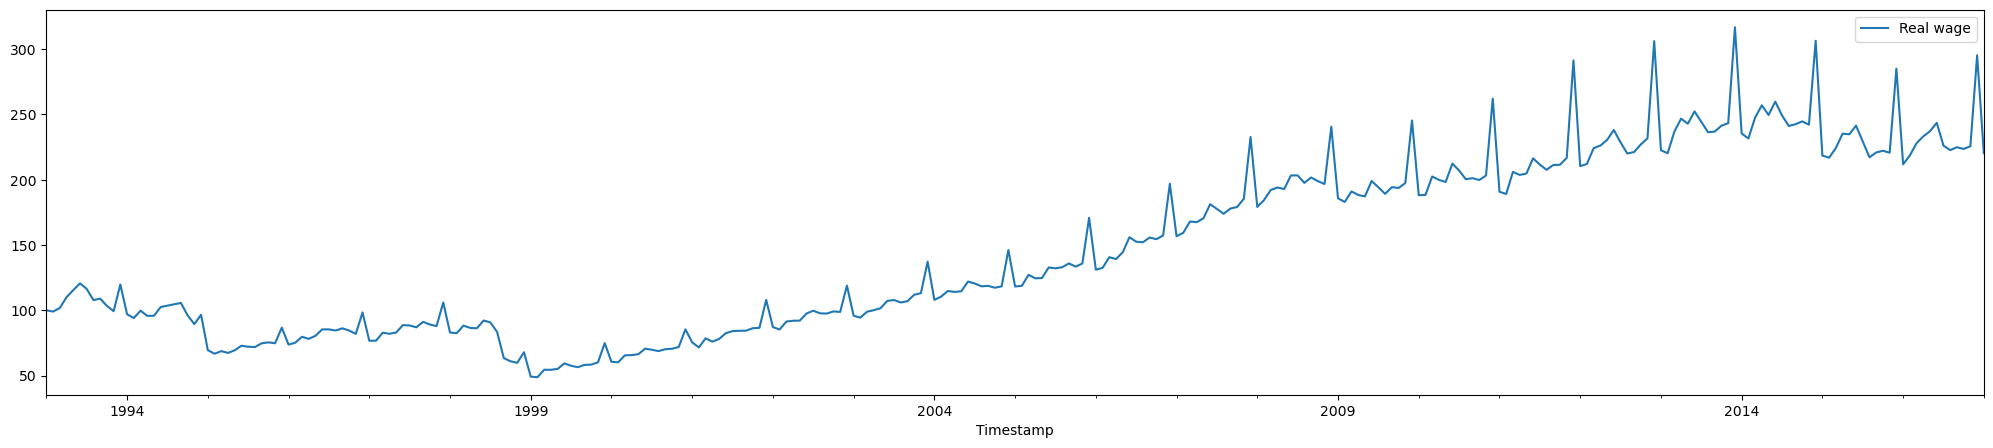

In [ ]:
ts_wage.plot(figsize = (25, 5))

В данных наблюдается тренд. Начиная с 1999 значения ряда возрастают, также заметна сезонность (регулярные пики), присутствует некий шум.

Основные компоненты временного ряда:  
- Тренд (trend) - плавное долгосрочное изменение значений ряда  
- Сезонность (seasonality) - сезонные колебания ряда  
- Шум (noise) - шумовая/случайная компонента ряда  

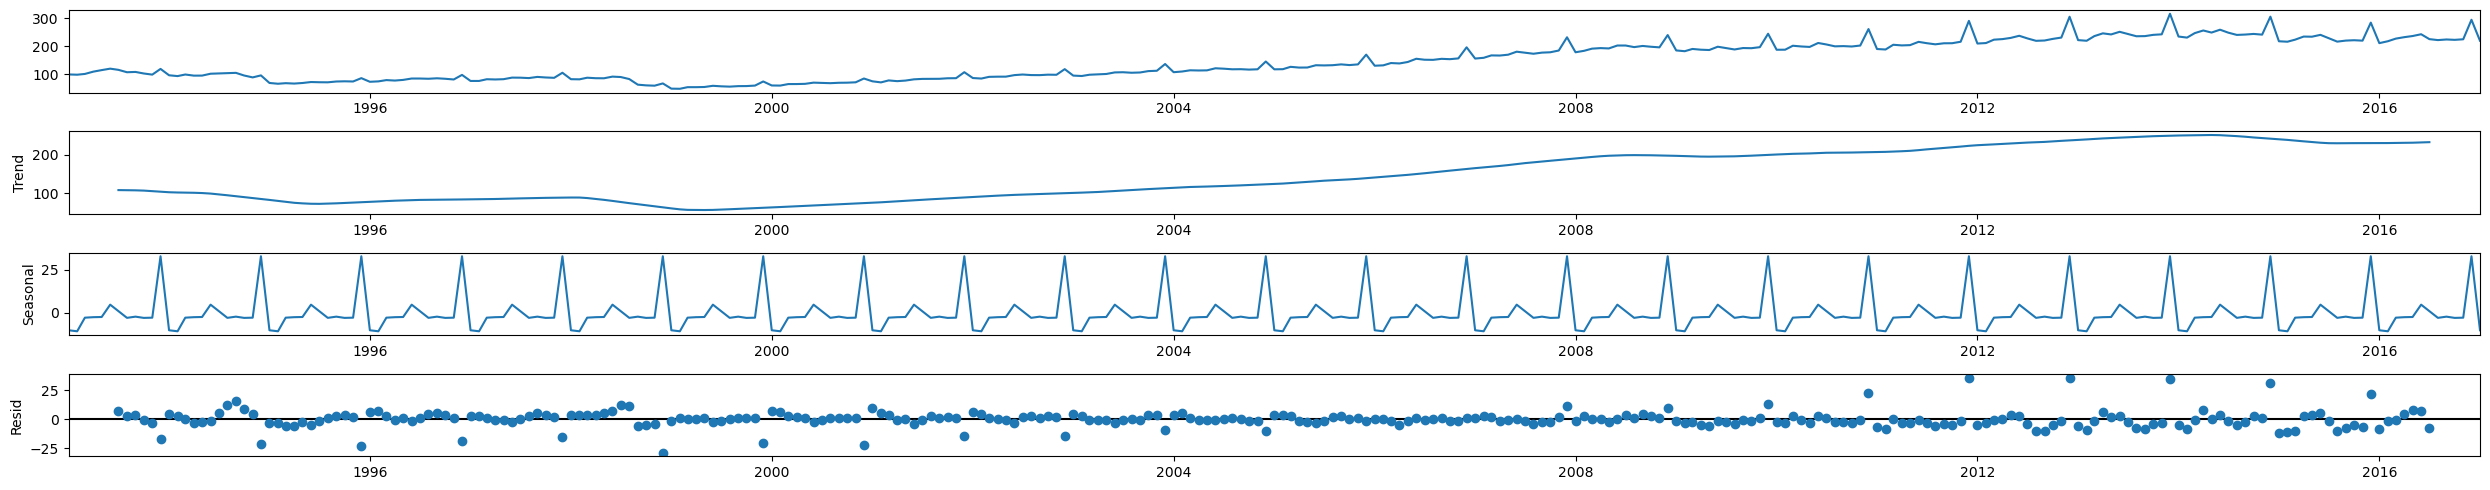

In [ ]:
# Выделим основные компоненты временного ряда, используя statsmodels time series analysis
import statsmodels.api as sm
res = sm.tsa.seasonal_decompose(ts_wage)  # main params:  model (additive - default, multiplicative), peiod
plt.rc('figure', figsize=(25, 5))
resplot = res.plot()

В ряде выраженные компоненты тренда и сезонности - значит, он нестационарный.   
Проверим это при помощи двух наиболее часто используемых тестов:  
- тест Дики-Фуллера (Dickey-Fuller test, проверяет нулевую гипотезу H_0: во временном ряде есть единичный корень - ряд нестационарен)
- тест KPSS (Kwiatkowski–Phillips–Schmidt–Shin test, проверяет нулевую гипотезу H_0: временной ряд стационарен)

#### Тест Дики-Фуллера (Dickey-Fuller test)   
**H_0: существует единичный корень - ряд нестационарен**

In [ ]:
from statsmodels.tsa import stattools
df_stat = stattools.adfuller(ts_wage)
df_stat

(-0.23089129820625137,
 0.9347378832321221,
 15,
 273,
 {'1%': -3.45453261164607,
  '5%': -2.8721859575020017,
  '10%': -2.572442854861866},
 1591.0996110746626)

In [ ]:
print(f'1) The Augmented Dikkey-Fuller test statistic: {df_stat[0]:.3f} \n2) p_value: {df_stat[1]:.3f} \n3) Critical values: {df_stat[4]}')
if df_stat[0] > df_stat[4]['5%']: print('\nЕсть единичные корни - ряд нестационарный')
else: print('\nЕдиничных корней нет - возможно, ряд стационарный')

1) The Augmented Dikkey-Fuller test statistic: -0.231 
2) p_value: 0.935 
3) Critical values: {'1%': -3.45453261164607, '5%': -2.8721859575020017, '10%': -2.572442854861866}

Есть единичные корни - ряд нестационарный


Проверим на стационарность временной ряд динамики солнечных пятен.

In [ ]:
# Временной ряд динамики солнечных пятен
ss_df = pd.read_csv('https://raw.githubusercontent.com/aiedu-courses/stepik_applied_tasks/main/datasets/sunspots.csv', 
                    decimal='.', parse_dates=['Date'], dayfirst=False, index_col='Date')
ss_df = ss_df[[ss_df.columns[1]]]
print(ss_df.shape)
ss_df.tail(10)

(3265, 1)


Monthly Mean Total Sunspot Number
Date                                         
2020-04-30                                5.2
2020-05-31                                0.2
2020-06-30                                5.8
2020-07-31                                6.1
2020-08-31                                7.5
2020-09-30                                0.6
2020-10-31                               14.4
2020-11-30                               34.0
2020-12-31                               21.8
2021-01-31                               10.4

In [ ]:
ss_df['Monthly Mean Total Sunspot Number'].describe()

count    3265.000000
mean       81.778775
std        67.889277
min         0.000000
25%        23.900000
50%        67.200000
75%       122.500000
max       398.200000
Name: Monthly Mean Total Sunspot Number, dtype: float64

<Axes: xlabel='Date'>

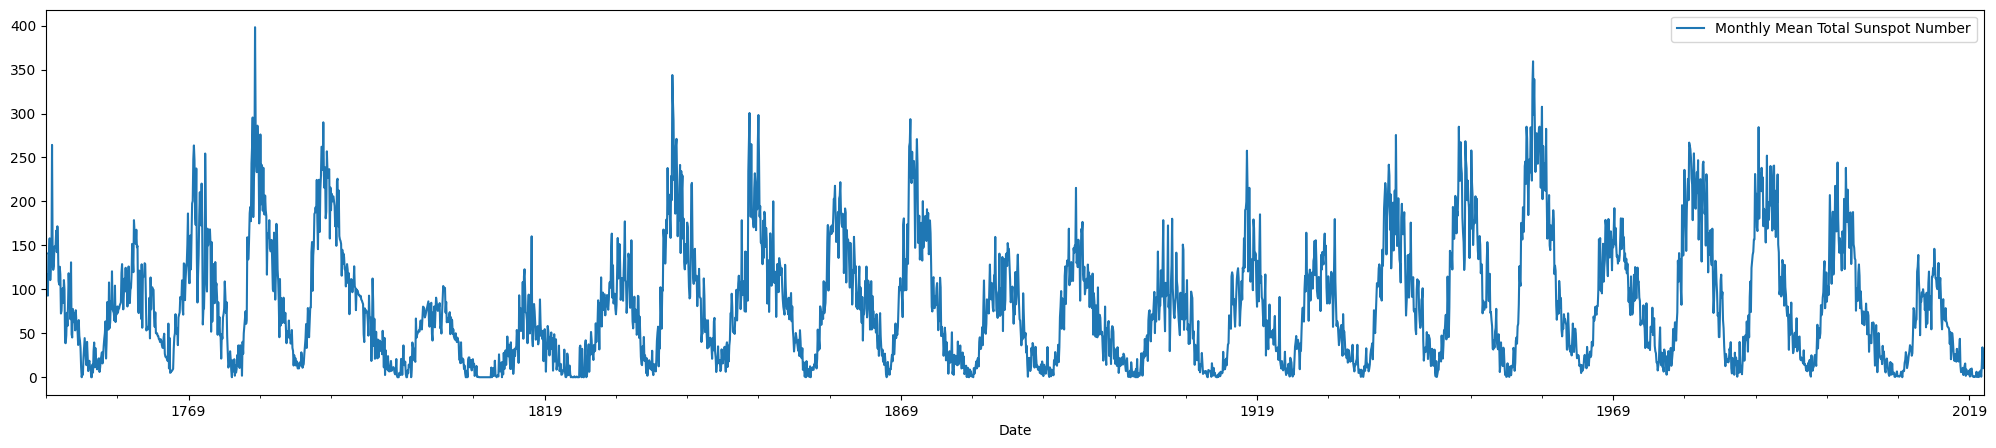

In [ ]:
ss_df.plot(figsize = (25,5))

В ряде наблюдается выраженная компонента сезонности. Значит, он нестационарный. Проверим это при помощи теста Дики-Фуллера.

In [ ]:
from statsmodels.tsa import stattools
stat_df = stattools.adfuller(ss_df[-1500:])
stat_df

(-6.7145256245665,
 3.6100759916851085e-09,
 24,
 1475,
 {'1%': -3.434791163965702,
  '5%': -2.8635014840083945,
  '10%': -2.5678142741740877},
 13561.290573093145)

In [ ]:
print(f'The Augmented Dickey-Fuller test statistic: {stat_df[0]:.3f} \np_value: {stat_df[1]:.5f} \ncritical values: {stat_df[4]}')
if stat_df[0] > stat_df[4]['5%']: print('Есть единичные корни - ряд нестационарный')
else: print('Единичных корней нет (возможно, ряд стационарен)')

The Augmented Dickey-Fuller test statistic: -6.715 
p_value: 0.00000 
critical values: {'1%': -3.434791163965702, '5%': -2.8635014840083945, '10%': -2.5678142741740877}
Единичных корней нет (возможно, ряд стационарен)


Тест Дики-Фуллера привел нас к неверному результату! Применим тест KPSS.

#### Тест KPSS (Kwiatkowski–Phillips–Schmidt–Shin test)    
**H_0: ряд стационарен**

In [ ]:
from statsmodels.tsa import stattools
kpss_stat = stattools.kpss(ss_df[-1000:])
kpss_stat

(0.4686152087510591,
 0.04873531334435607,
 19,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [ ]:
print('The KPSS test statistic %.2f, \npvalue: %.4f \ntable distribution: %s' % (kpss_stat[0], kpss_stat[1], kpss_stat[3]))
if kpss_stat[0] > kpss_stat[3]['5%']: print('Отвергаем H0! Временной ряд нестационарный.')
else: print('Ряд стационарный.')

The KPSS test statistic 0.47, 
pvalue: 0.0487 
table distribution: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Отвергаем H0! Временной ряд нестационарный.


## 2. Базовые подходы для прогнозирования временных рядов: cтатистический и адаптивный подходы, машинное обучение, основные фреймворки для работы с ts  

- Статистический подход (ARIMA, SARIMA, SARIMAX и др)
- Адаптивный подход (Экспоненциальное скользящее среднее, модель Хольта, модель Винтерса, модель Хольта-Винтерса)
- Машинное обучение (линейная регрессия, дерево решений, случайный лес, градиентный бустинг) / Глубокое обучение
- Основные фреймворки для работы с ts (ETNA, Orbit, SkTime, Prophet, Tsfresh, FeatureTools и др.)

### Статистический подход

Статистический подход основан на понятии стационарного временного ряда.  
Стационарный временной ряд - временной ряд, у которого стат. свойства не меняются со временем. Если в ряде присутствует тренд, сезонность (не цикл) или наблюдается неравномерная дисперсия - ряд нестационарен.   
Идея статистического подхода – при помощи некоторых преобразований привести ряд к стационарному и сделать прогноз для стационарного ряда. Такой ряд прогнозировать достаточно легко. Существуют преобразования, удаляющие из ряда тренд, сезонность и нормализующие дисперсию. Любой временной ряд можно сделать стационарным с помощью таких преобразований. На преобразованном стационарном ряде обучаются простые модели, как правило линейные, затем к прогнозу применяется обратное преобразование.      

**ARMA (Autoregression Moving Average)** – классическая линейная модель для построения прогнозов. Её модификации: ARIMA, AUTOARIMA, SARIMA, SARIMAX.    
- ARIMA - учитывает наличие тренда,   
- SARIMA (сезонная ARIMA) - учитывает наличие тренда и сезонности,    
- SARIMAX - помимо основных компонентов ряда, учитывает наличие экзогенных переменных (внешние факторы).

In [190]:
# Прогнозирование объема продаж
df = pd.read_csv("https://raw.githubusercontent.com/aiedu-courses/stepik_applied_tasks/main/datasets/market_arrivals_ind.csv")
df['date'] = pd.DatetimeIndex(df['date'])  #.to_period('M')
df = df.sort_values('date')
df.index = pd.PeriodIndex(df['date'], freq = 'M')
ts = df.loc[df.city == "BANGALORE"][['quantity', 'priceMod']].copy()
ts[:3]

quantity  priceMod
date                       
2004-01    227832       991
2004-02    225133       793
2004-03    221952       556

MAPE (SARIMAX): 0.14


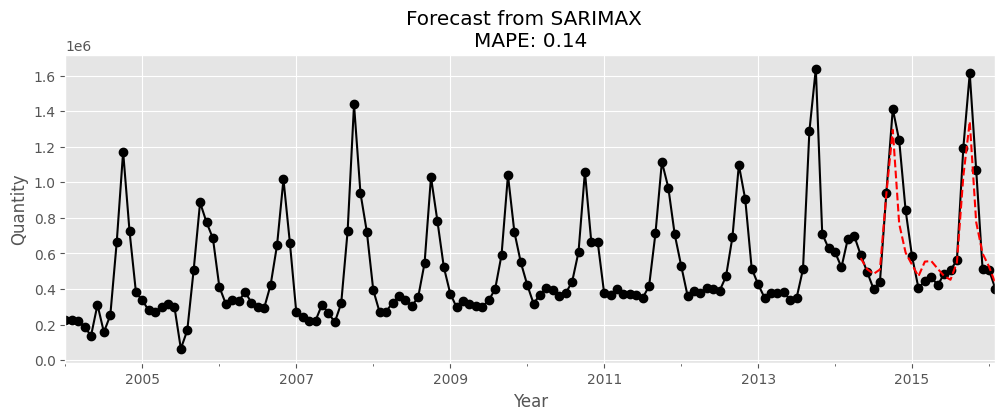

In [ ]:
# Построим модель с экзогенным фактором, используя statsmodels SARIMAX
cut_ind = int(ts.shape[0] * 0.85)
train = ts.iloc[:cut_ind]
test = ts.iloc[cut_ind:]

sarimax_model = sm.tsa.SARIMAX(train['quantity'], exog=train[['priceMod']],  seasonal_order=(1, 1, 1, 12)).fit()
forecast = sarimax_model.get_forecast(steps=22, exog=test[['priceMod']])
predicted_mean = forecast.predicted_mean
print('MAPE (SARIMAX):', round(mean_absolute_percentage_error(test['quantity'], predicted_mean), 2))

ax = ts['quantity'].plot(figsize=(12, 4), marker="o", color="black", title=f"Forecast from SARIMAX  \nMAPE: {round(mean_absolute_percentage_error(test['quantity'], predicted_mean), 2)}",)
ax.set_ylabel("Quantity")
ax.set_xlabel("Year")
predicted_mean.plot(ax=ax, style="--", color="red")
plt.show()

### Адаптивный подход 

Адаптивные методы прогнозирования временных рядов - методы, цель которых заключается в построении самокорректирующихся моделей, которые способны отражать изменяющееся во времени поведение ряда.     

Простые модели адаптивного подхода (реализованы в библиотеке statsmodels.tsa.api):  
- Модель скользящего среднего
- Модель экспоненциального скользящего среднего (ЭСС)  
- Модель Хольта     
- Модель Винтерса  
- Модель Хольта-Винтерса   

Продвинутые адаптивные модели (реализованы в библиотеке Orbit):  
- Damped Local Trend (DLT)  
- Local Global Trend (LGT)   

Простые адаптивные модели достаточно хорошо работают на коротком горизонте прогнозирования.   
Продвинутые адаптивные модели помимо стандартных эффектов (наличие тренда, сезонности) могут учитывать затухание тренда (Damped Trend), локальные и глобальные тренды и тд.    

- **Модель скользящего среднего** - самая простая адаптивная модель прогнозирования (прогноз на следующий период - среднее арифметическое последних n значений ряда).      
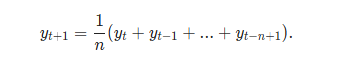   
- **Модель экспоненциального скользящего среднего (ЭСС)** - одна из наиболее простых моделей адаптивного подхода.    
В каждый следующий момент времени пересчитывается прогноз, без предположения, что в ряде есть тренд, сезонность и тд. Модель постепенно адаптруется под изменение ряда. На прогноз сегодня больше всего влияет значение ряда вчера, чуть меньше - позавчера и так далее. Для такого подхода лучше всего подходят веса, убывающие по геометрической прогрессии. Экспоненциальное скользящее среднее - это сумма значений ряда с весами, убывающими в прошлое. Его можно использовать для удаления шумов в данных. Чем меньше α тем сильнее сглаживание. В такой постановке мы не учитываем такие особенности поведения ряда как тренд и сезонность.    
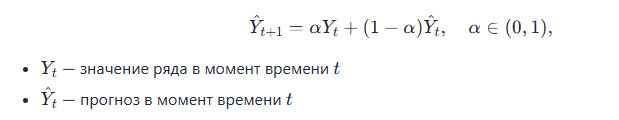


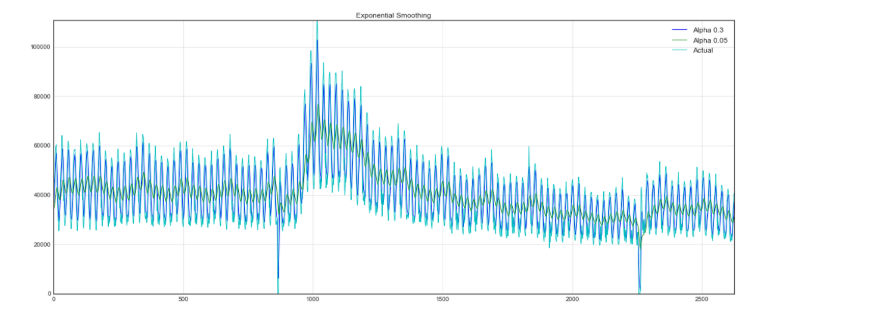

На картинке изображен временной ряд посещения Интернет-сайта (кол-во посещений сайта в каждый момент времени). Чтобы сделать прогноз на следующий день (t+1) используется истинное значение ряда на текущий день Yt, прогнозное значение на текущий день и их усреднение с некоторыми весами. В каждый следующий момент времени пересчитывается прогноз, без предположения, что в ряде есть тренд, сезонность и тд. Модель адаптруется под изменение ряда. Если в ряде есть тренд - модель под него адаптируется, но не сразу. Данная модель также довольно плохо улавливает сезонность.

- **Модель Хольта**  - модель линейного тренда. Она изначально предполагает, что в ряде есть тренд (тренд может меняться, и это не проблема для модели, так как компонента тренда все время пересчитывается):


  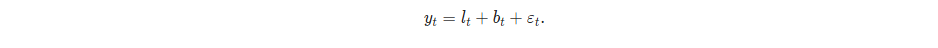

  Прогноз ряда осуществляется по формуле:

  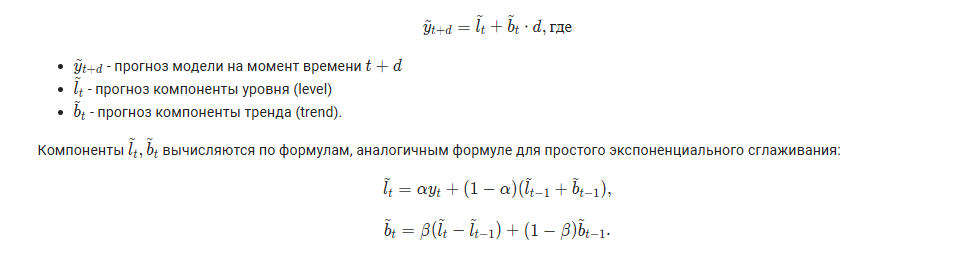



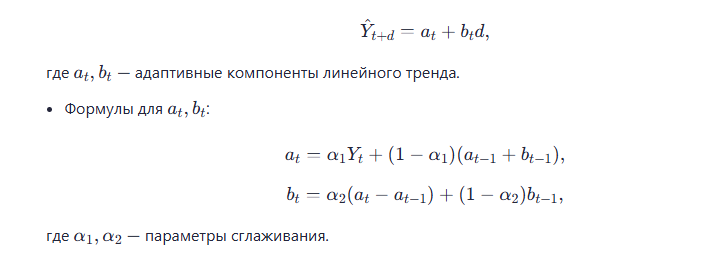

- **Модель Винтерса** - модель, которая учитывает сезонность (s_t с периодом p).

 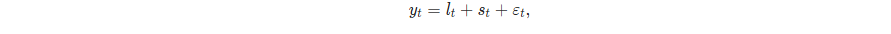

  Прогноз ряда осуществляется по формуле:

  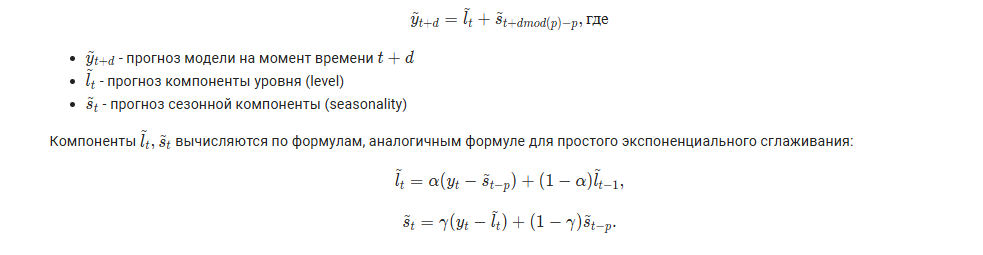

- **Модель Хольта-Винтерса (аддитивная)** - модель, которая хорошо учитывает тренд и сезонность.
  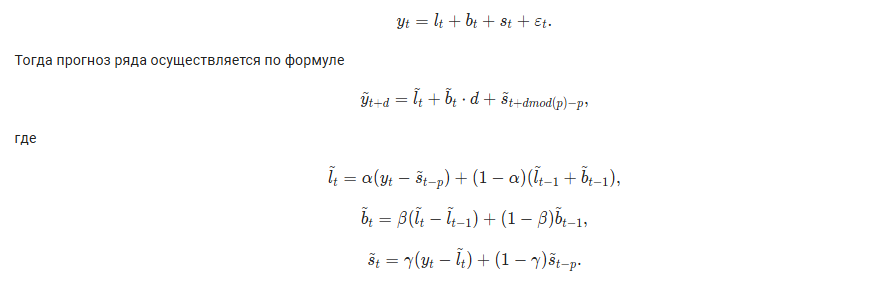


**Затухающий тренд (damped trend)**   
Damped trend в моделях экспоненциального сглаживания представляет собой модификацию классической модели ЭСС, в которой тренд затухает со временем. Эта модификация позволяет учесть изменение тренда во временных рядах и предсказывать его затухание по мере продвижения в будущее.   
В моделях экспоненциального сглаживания с затухающим трендом, изменение тренда со временем моделируется с помощью параметра затухания **damping parameter**. Параметр затухания определяет, насколько быстро тренд будет затухать по мере увеличения горизонта прогнозирования. Если значение параметра близко к нулю, то тренд будет затухать медленно, если близко к единице - быстрее. Модель с затухающим трендом позволяет учесть эффект затухания во временных рядах и предсказать его будущую динамику. Это может быть полезно в ситуациях, когда тренд в ряде имеет тенденцию к затуханию или изменению скорости. Общая формула модели с затухающим трендом:     
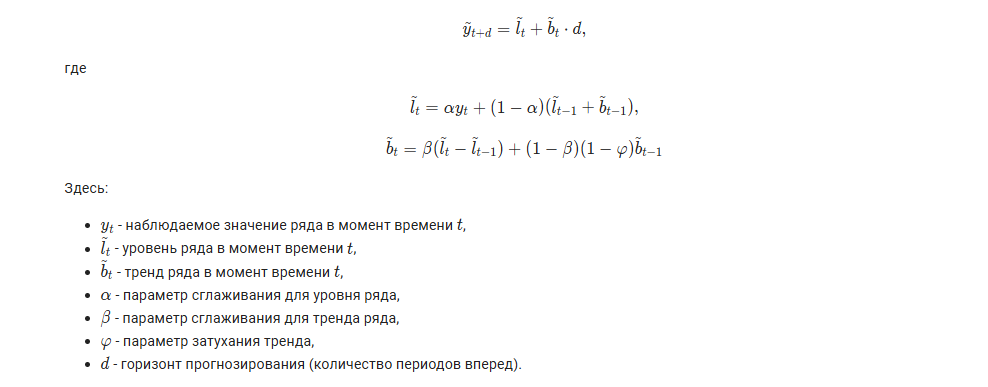   

**Продвинутые адаптивные модели (реализованы в библиотеке Orbit)**:
- Damped Local Trend (DLT)
- Local Global Trend (LGT)

**Компоненты ряда могут быть аддитивными (складываться), мультипликативными (перемножаться) или экспоненциальными (возводиться в степень)**. Для каждого из этих случаев существуют свои экспоненциальные модели. Пример двух мультипликативных моделей:      
- Модель Винтерса с мультипликативной сезонностью (периода p)

  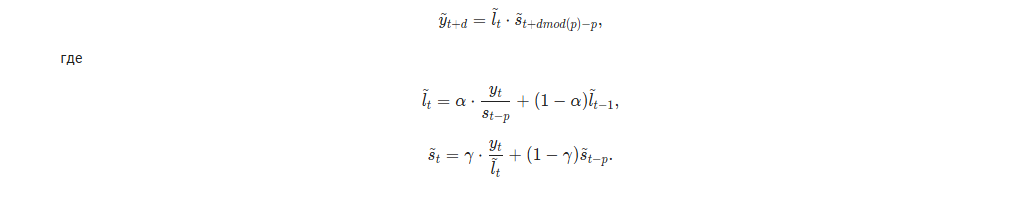

  
- Модель Винтерса с аддитивным трендом и мультипликативной сезонностью (периода p)

  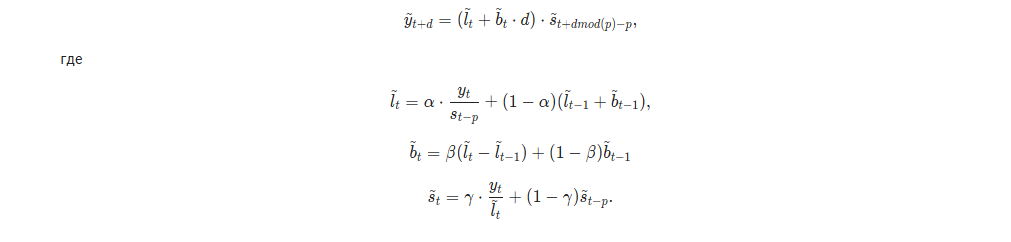

  


**Экспоненциальные компоненты ряда**  
Не всегда можно  знать заранее, какая модель подойдет больше: аддитивная, мультипликативная, экспоненциальная или смешанная. В таком случае можно обучить несколько моделей и выбрать ту, которая даст наименьшую ошибку на тестовых данных. Прогнозирующая модель для ряда с мультипликативной сезонностью (периода p) и экспоненциальным трендом будет иметь следующий вид:        

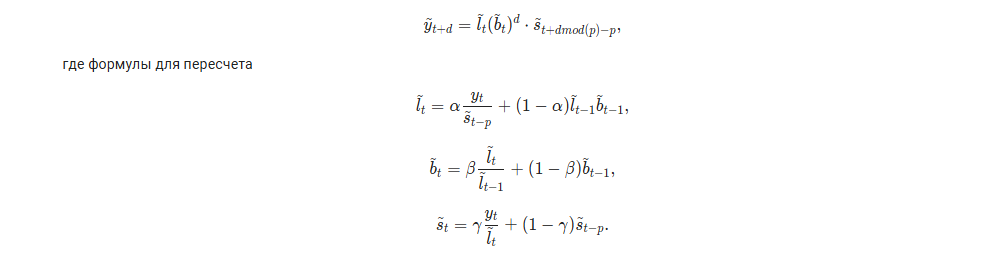

##### Модель простого экспоненциального сглаживания (statsmodels.tsa.api SimpleExpSmoothing)   
**Пример 1: [из документации](https://www.statsmodels.org/dev/examples/notebooks/generated/exponential_smoothing.html#The-Internals)**

Модель $$\tilde y_{t+d} = l,$$
где
$$\tilde y_{t+1} = \alpha y_t + (1-\alpha)\tilde y_t$$


Применим три варианта простого экспоненциального сглаживания:
1) значение $\alpha = 0.2$
2) значение $\alpha = 0.6$
3) определим $\alpha$ автоматически (рекомендованный вариант)

In [ ]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
data = [446.6565,
        454.4733,
        455.663,
        423.6322,
        456.2713,
        440.5881,
        425.3325,
        485.1494,
        506.0482,
        526.792,
        514.2689,
        494.211]
index = pd.date_range(start = '1996', end = '2008', freq = 'A')
oildata = pd.Series(data, index)
oildata

1996-12-31    446.6565
1997-12-31    454.4733
1998-12-31    455.6630
1999-12-31    423.6322
2000-12-31    456.2713
2001-12-31    440.5881
2002-12-31    425.3325
2003-12-31    485.1494
2004-12-31    506.0482
2005-12-31    526.7920
2006-12-31    514.2689
2007-12-31    494.2110
Freq: A-DEC, dtype: float64

Figure 7.1: Oil production in Saudi Arabia from 1996 to 2007.


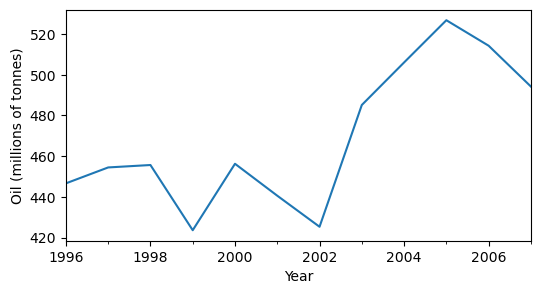

In [ ]:
ax = oildata.plot(figsize = (6, 3))
ax.set_xlabel('Year')
ax.set_ylabel('Oil (millions of tonnes)')
print("Figure 7.1: Oil production in Saudi Arabia from 1996 to 2007.")

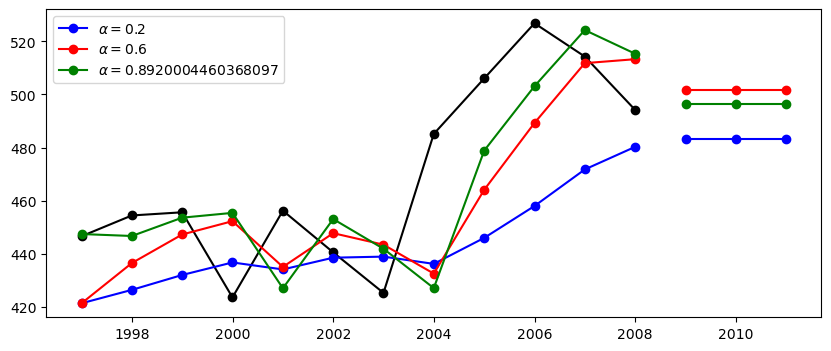

In [ ]:
simple_smooth1 = SimpleExpSmoothing(oildata, initialization_method = 'heuristic').fit(smoothing_level = 0.2, optimized = False)
fcast1 = simple_smooth1.forecast(3).rename(r'$\alpha=0.2$')  

simple_smooth2 = SimpleExpSmoothing(oildata, initialization_method = 'heuristic').fit(smoothing_level = 0.6, optimized = False)
fcast2 = simple_smooth2.forecast(3).rename(r'$\alpha=0.6$')

simple_smooth3 = SimpleExpSmoothing(oildata, initialization_method="estimated").fit()
fcast3 = simple_smooth3.forecast(3).rename(r"$\alpha=%s$" % simple_smooth3.model.params["smoothing_level"])

plt.figure(figsize=(10, 4))
plt.plot(oildata, marker="o", color="black")
plt.plot(simple_smooth1.fittedvalues, marker="o", color="blue")     # model 1
(line1,) = plt.plot(fcast1, marker="o", color="blue")
plt.plot(simple_smooth2.fittedvalues, marker="o", color="red")      # model 2
(line2,) = plt.plot(fcast2, marker="o", color="red")
plt.plot(simple_smooth3.fittedvalues, marker="o", color="green")    # model 3
(line3,) = plt.plot(fcast3, marker="o", color="green")
plt.legend([line1, line2, line3], [fcast1.name, fcast2.name, fcast3.name])

In [21]:
simple_smooth1.model.params

{'smoothing_level': 0.2,
 'smoothing_trend': None,
 'smoothing_seasonal': None,
 'damping_trend': nan,
 'initial_level': 421.42419999999976,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [20]:
simple_smooth3.model.params

{'smoothing_level': 0.8920004460368097,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 447.4784253206368,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

**Пример 2: временной ряд из ритейла**

In [ ]:
rt_df = pd.read_csv('https://raw.githubusercontent.com/aiedu-courses/stepik_applied_tasks/main/datasets/retail.csv', 
                    parse_dates=['Date']).set_index('Date')
print(rt_df.shape)
rt_df.head(3)

(92886, 6)


Store_id  SKU_id  Promo  Demand  Regular_Price  Promo_Price
Date                                                                   
2015-01-01         1       1    NaN    22.0         163.78          NaN
2015-01-02         1       1    NaN    41.0         163.78          NaN
2015-01-03         1       1    NaN    35.0         163.78          NaN

(506,)
min   2015-01-01
max   2016-05-20
Name: Date, dtype: datetime64[ns]


<Axes: xlabel='Date'>

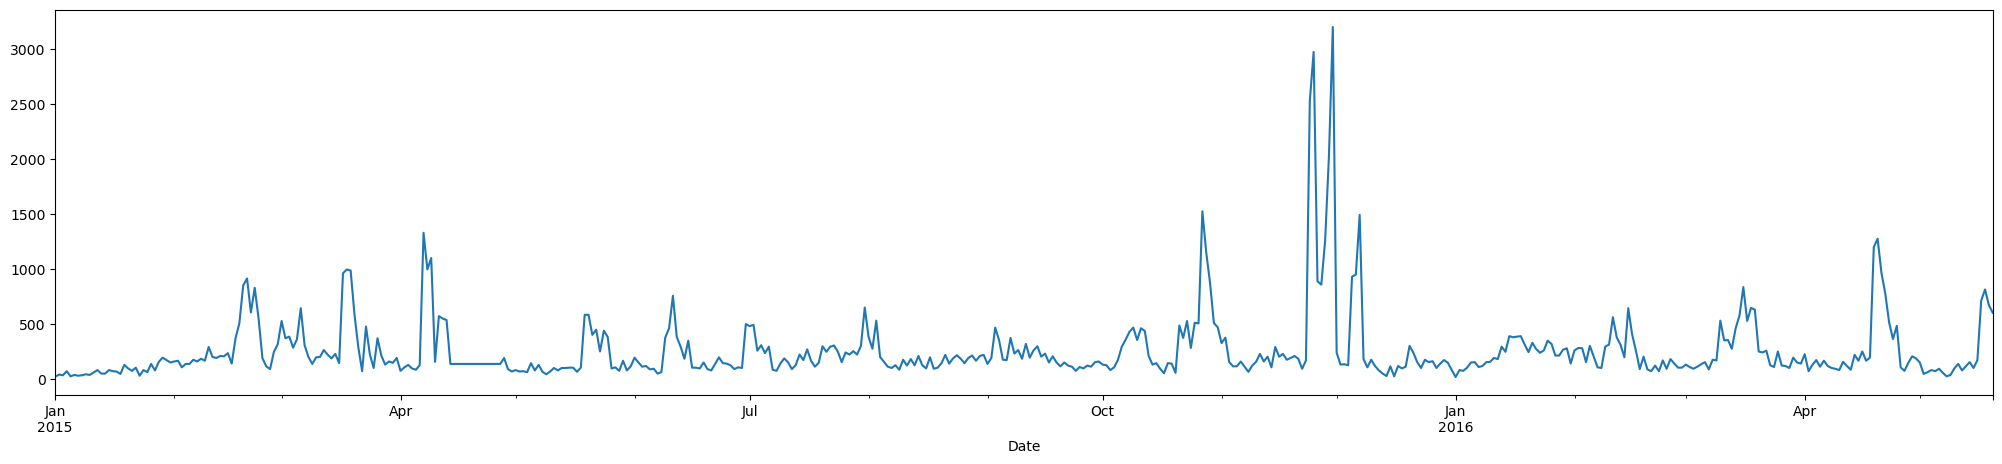

In [ ]:
ts = rt_df[(rt_df['Store_id']==1) & (rt_df['SKU_id']==1)]['Demand'].iloc[:-30]
print(ts.shape)
print(pd.Series(ts.index).agg(['min', 'max']))
ts.plot(figsize=(25, 5))

In [ ]:
print(ts.describe())

count     506.000000
mean      260.169960
std       316.268164
min        19.000000
25%       107.000000
50%       160.000000
75%       283.000000
max      3198.000000
Name: Demand, dtype: float64


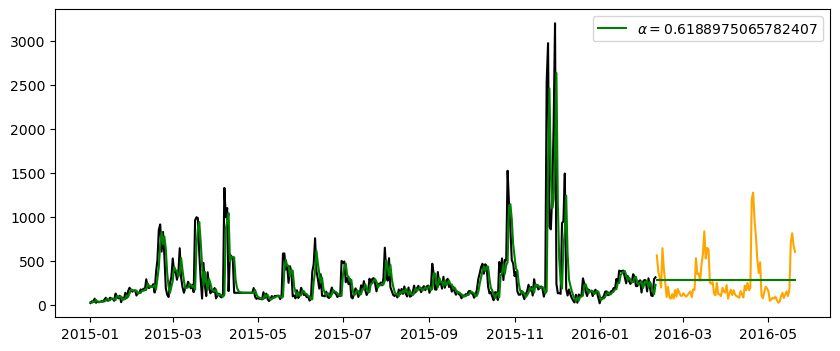

In [ ]:
# Разделим выбрку и обучим SimpleExpSmoothing c автоматическим подбором а
train = ts.iloc[:-100]
test = ts.iloc[-100:]

simple_smooth = SimpleExpSmoothing(train, initialization_method = 'estimated').fit()
fcast = simple_smooth.forecast(100).rename(r"$\alpha=%s$" % simple_smooth.model.params["smoothing_level"])

plt.figure(figsize = (10, 4))
plt.plot(train, color = 'black')
plt.plot(test, color = 'orange')
plt.plot(simple_smooth.fittedvalues, color = 'green')
(line,) = plt.plot(fcast, color = 'green')
plt.legend([line], [fcast.name])

In [ ]:
simple_smooth.model.params

{'smoothing_level': 0.6188975065782407,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 29.522973075648416,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

В обоих случаях мы получили константный прогноз

##### Модель Хольта (двойное экспоненциальное сглаживание) - модель линейного тренда. Она изначально предполагает, что в ряде есть тренд  (Holt)
В библиотеке также реализована модель с экспоненциальным трендом

In [46]:
from statsmodels.tsa.api import SimpleExpSmoothing, ExponentialSmoothing, Holt

data = [17.5534, 21.86, 23.8866, 26.9293, 26.8885, 28.8314, 30.0751, 30.9535, 30.1857, 31.5797, 32.5776, 33.4774, 39.0216, 41.3864, 41.5966]
index = pd.date_range(start="1990", end="2005", freq="A")
air = pd.Series(data, index)

data = [263.9177, 268.3072, 260.6626, 266.6394, 277.5158, 283.834, 290.309, 292.4742, 300.8307, 309.2867, 318.3311, 329.3724, 338.884, 339.2441,
        328.6006, 314.2554, 314.4597, 321.4138, 329.7893, 346.3852, 352.2979, 348.3705, 417.5629, 417.1236, 417.7495, 412.2339, 411.9468, 394.6971,
        401.4993, 408.2705, 414.2428]
index = pd.date_range(start="1970", end="2001", freq="A")
livestock2 = pd.Series(data, index)

data = [407.9979, 403.4608, 413.8249, 428.105, 445.3387, 452.9942, 455.7402]
index = pd.date_range(start="2001", end="2008", freq="A")
livestock3 = pd.Series(data, index)

data = [41.7275, 24.0418, 32.3281, 37.3287, 46.2132, 29.3463, 36.4829, 42.9777, 48.9015, 31.1802, 37.7179, 40.4202, 51.2069, 31.8872, 40.9783,
        43.7725, 55.5586, 33.8509, 42.0764, 45.6423, 59.7668, 35.1919, 44.3197, 47.9137]
index = pd.date_range(start="2005", end="2010-Q4", freq="QS-OCT")
aust = pd.Series(data, index)

print(air.shape)
display(air.head(3))

(15,)


1990-12-31    17.5534
1991-12-31    21.8600
1992-12-31    23.8866
Freq: A-DEC, dtype: float64

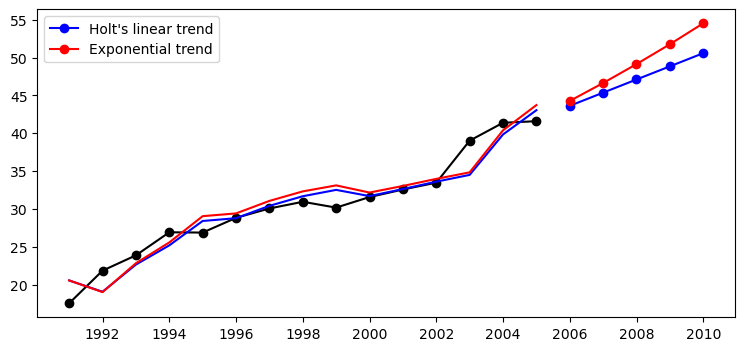

In [ ]:
holt_model1 = Holt(air, initialization_method = 'estimated').fit(smoothing_level = 0.8, smoothing_trend = 0.2, optimized = False)
fcast1 = holt_model1.forecast(5).rename("Holt's linear trend")

holt_model2 = Holt(air, exponential = True, initialization_method = 'estimated').fit(smoothing_level = 0.8, smoothing_trend = 0.2, optimized=False)
fcast2 = holt_model2.forecast(5).rename("Exponential trend")

plt.figure(figsize=(9, 4))
plt.plot(air, marker="o", color="black")
plt.plot(holt_model1.fittedvalues, color="blue")     
(line1,) = plt.plot(fcast1, marker="o", color="blue")
plt.plot(holt_model2.fittedvalues, color="red")       
(line2,) = plt.plot(fcast2, marker="o", color="red")
plt.legend([line1, line2], [fcast1.name, fcast2.name])

In [49]:
holt_model1.model.params

{'smoothing_level': 0.8,
 'smoothing_trend': 0.2,
 'smoothing_seasonal': None,
 'damping_trend': nan,
 'initial_level': 19.166606666666652,
 'initial_trend': 1.401402424242426,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [50]:
holt_model2.model.params

{'smoothing_level': 0.8,
 'smoothing_trend': 0.2,
 'smoothing_seasonal': None,
 'damping_trend': nan,
 'initial_level': 19.166606666666652,
 'initial_trend': 1.0731168771089594,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

##### Модель Хольта-Винтерса (тройное экспоненциальное сглаживание) - модель, которая хорошо учитывает тренд и сезонность  (ExponentialSmoothing)
Исследуем четыре модели:
1) Модель с аддитивными трендом и сезонностью
2) Модель с аддитивным трендом и мультипликативной сезонностью
3) Модель с аддитивными трендом и сезонностью и затухающим трендом (damped trend)
4) Модель с аддитивным трендом, мультипликативной сезонностью и затухающим трендом (damped trend)

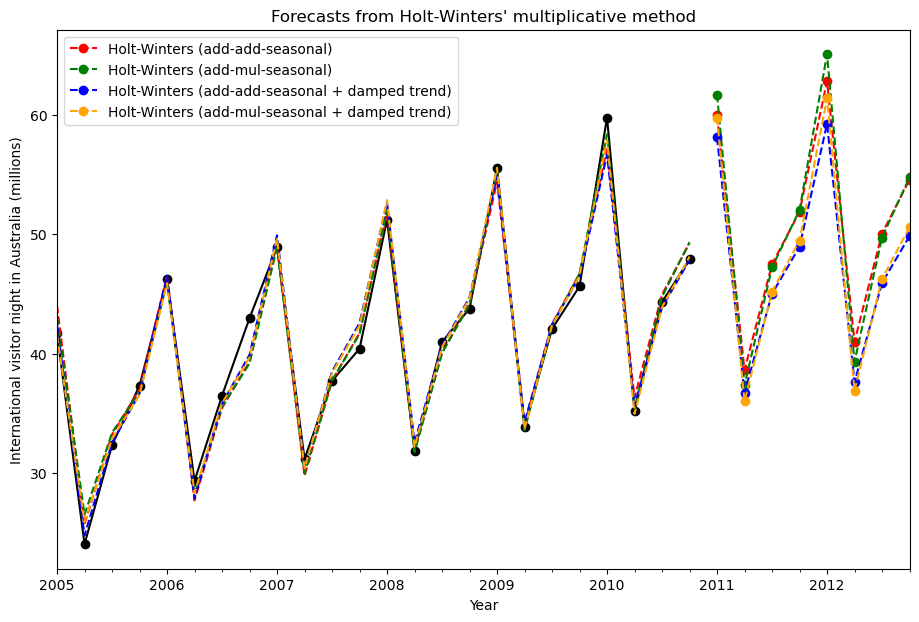

In [ ]:
# Модель с аддитивными трендом и сезонностью
holt_winters1 = ExponentialSmoothing(aust, seasonal_periods = 4, trend = 'add', seasonal = 'add',
                                     use_boxcox = True, initialization_method='estimated').fit()
# Модель с аддитивным трендом и мультипликативной сезонностью
holt_winters2 = ExponentialSmoothing(aust, seasonal_periods = 4, trend = 'add', seasonal = 'mul',
                                     use_boxcox = True, initialization_method = 'estimated').fit()
# Модель с аддитивными трендом и сезонностью и затухающим трендом (damped_trend)
holt_winters3 = ExponentialSmoothing(aust, seasonal_periods=4, trend="add", seasonal="add", damped_trend=True, 
                                     use_boxcox=True, initialization_method="estimated").fit()
# Модель с аддитивным трендом, мультипликативной сезонностью и затухающим трендом (damped_trend)
holt_winters4 = ExponentialSmoothing(aust, seasonal_periods=4, trend="add", seasonal="mul", damped_trend=True, 
                                     use_boxcox=True, initialization_method="estimated").fit()
# results = pd.DataFrame(index = [r"$\alpha$", r"$\beta$", r"$\phi$", r"$\gamma$", r"$l_0$", "$b_0$", "SSE"])

ax = aust.plot(figsize = (11, 7), marker = 'o', color = 'black', title = "Forecasts from Holt-Winters' multiplicative method")
ax.set_ylabel("International visitor night in Australia (millions)")
ax.set_xlabel("Year")

holt_winters1.fittedvalues.plot(ax = ax, style = '--', color = 'red')
holt_winters2.fittedvalues.plot(ax = ax, style = '--', color = 'green')
holt_winters3.fittedvalues.plot(ax = ax, style = '--', color = 'blue')
holt_winters4.fittedvalues.plot(ax = ax, style = '--', color = 'orange')

holt_winters1.forecast(8).rename("Holt-Winters (add-add-seasonal)").plot(ax=ax, style = '--', marker = 'o', color = 'red', legend = True)
holt_winters2.forecast(8).rename("Holt-Winters (add-mul-seasonal)").plot(ax=ax, style = '--', marker = 'o', color = 'green', legend = True)
holt_winters3.forecast(8).rename("Holt-Winters (add-add-seasonal + damped trend)").plot(ax=ax, style = '--', marker = 'o', color = 'blue', legend = True)
holt_winters4.forecast(8).rename("Holt-Winters (add-mul-seasonal + damped trend)").plot(ax=ax, style = '--', marker = 'o', color = 'orange', legend = True)
plt.show()

In [ ]:
train, test = train_test_split(aust, test_size = 0.30, shuffle = False)  
print(X_train.shape, X_test.shape)

(16,) (8,)


In [ ]:
X_test

2009-01-01    55.5586
2009-04-01    33.8509
2009-07-01    42.0764
2009-10-01    45.6423
2010-01-01    59.7668
2010-04-01    35.1919
2010-07-01    44.3197
2010-10-01    47.9137
Freq: QS-OCT, dtype: float64

train (16,) test (8,)


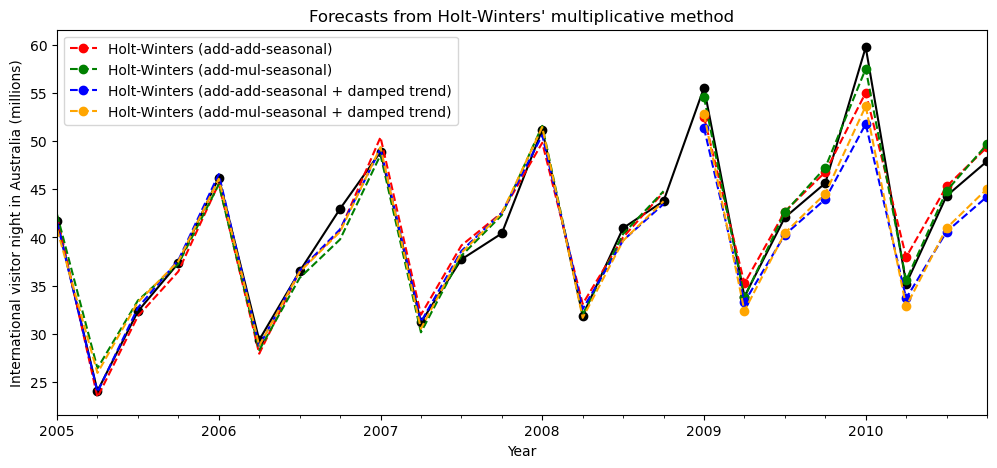

In [ ]:
# Разобьем данные на Train и Test и посмотрим как поведут себя эти модели
train, test = train_test_split(aust, test_size = 0.30, shuffle = False)
print('train', X_train.shape, 'test', X_test.shape)

# Модель с аддитивными трендом и сезонностью
holt_winters1 = ExponentialSmoothing(train, seasonal_periods = 4, trend = 'add', seasonal = 'add', 
                                     use_boxcox = True, initialization_method='estimated').fit()
# Модель с аддитивным трендом и мультипликативной сезонностью
holt_winters2 = ExponentialSmoothing(train, seasonal_periods = 4, trend = 'add', seasonal = 'mul', 
                                     use_boxcox = True, initialization_method = 'estimated').fit()
# Модель с аддитивными трендом и сезонностью и затухающим трендом (damped_trend)
holt_winters3 = ExponentialSmoothing(train, seasonal_periods=4, trend="add", seasonal="add", damped_trend=True,
                                     use_boxcox=True, initialization_method="estimated").fit()
# Модель с аддитивным трендом и мультипликативной сезонностью и затухающим трендом (damped_trend)
holt_winters4 = ExponentialSmoothing(train, seasonal_periods=4, trend="add", seasonal="mul", damped_trend=True,
                                    use_boxcox=True, initialization_method="estimated").fit()

# results = pd.DataFrame(index = [r"$\alpha$", r"$\beta$", r"$\phi$", r"$\gamma$", r"$l_0$", "$b_0$", "SSE"])

ax = aust.plot(figsize = (12, 5), marker = 'o', color = 'black', title = "Forecasts from Holt-Winters' multiplicative method")
ax.set_ylabel("International visitor night in Australia (millions)")
ax.set_xlabel("Year")

holt_winters1.fittedvalues.plot(ax = ax, style = '--', color = 'red')
holt_winters2.fittedvalues.plot(ax = ax, style = '--', color = 'green')
holt_winters3.fittedvalues.plot(ax = ax, style = '--', color = 'blue')
holt_winters4.fittedvalues.plot(ax = ax, style = '--', color = 'orange')

holt_winters1.forecast(8).rename("Holt-Winters (add-add-seasonal)").plot(ax=ax, style = '--', marker = 'o', color = 'red', legend = True)
holt_winters2.forecast(8).rename("Holt-Winters (add-mul-seasonal)").plot(ax=ax, style = '--', marker = 'o', color = 'green', legend = True)
holt_winters3.forecast(8).rename("Holt-Winters (add-add-seasonal + damped trend)").plot(ax=ax, style = '--', marker = 'o', color = 'blue', legend = True)
holt_winters4.forecast(8).rename("Holt-Winters (add-mul-seasonal + damped trend)").plot(ax=ax, style = '--', marker = 'o', color = 'orange', legend = True)
plt.show()

In [ ]:
mae1 = mean_absolute_error(test, holt_winters1.forecast(8))
mae2 = mean_absolute_error(test, holt_winters2.forecast(8))
mae3 = mean_absolute_error(test, holt_winters3.forecast(8))
mae4 = mean_absolute_error(test, holt_winters4.forecast(8))

print(f'MAE Holt-Winters add trend, add seasonal: {round(mae1, 3)}')
print(f'MAE Holt-Winters add trend, mul seasonal: {round(mae2, 3)}')
print(f'MAE Holt-Winters add trend, add seasonal, damped_trend: {round(mae3, 3)}')
print(f'MAE Holt-Winters add trend, mul seasonal, damped_trend: {round(mae4, 3)}')

MAE Holt-Winters add trend, add seasonal: 2.012
MAE Holt-Winters add trend, mul seasonal: 1.013
MAE Holt-Winters add trend, add seasonal, damped_trend: 3.136
MAE Holt-Winters add trend, mul seasonal, damped_trend: 2.704


In [ ]:
# Прогнозирование количества проданного товара в городе Бангалор, Индия (quantity)
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

pd.options.display.float_format = "{:.2f}".format
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (15, 15)

# Загрузка данных
df = pd.read_csv("https://raw.githubusercontent.com/aiedu-courses/stepik_applied_tasks/main/datasets/market_arrivals_ind.csv")
df['date'] = pd.DatetimeIndex(df['date'])  #.to_period('m')
df = df.sort_values('date')
df = df.set_index('date')
# df.index = pd.PeriodIndex(df['date'], freq = 'M')
print(df.shape)
df.head(2)

(10227, 9)


market     month  year  quantity  priceMin  priceMax  \
date                                                                      
1996-01-01  LASALGAON(MS)   January  1996    225063       160       257   
1996-02-01  LASALGAON(MS)  February  1996    196164       133       229   

            priceMod state       city  
date                                   
1996-01-01       226    MS  LASALGAON  
1996-02-01       186    MS  LASALGAON

(146, 1)


quantity
date                
2004-01-01    227832
2004-02-01    225133

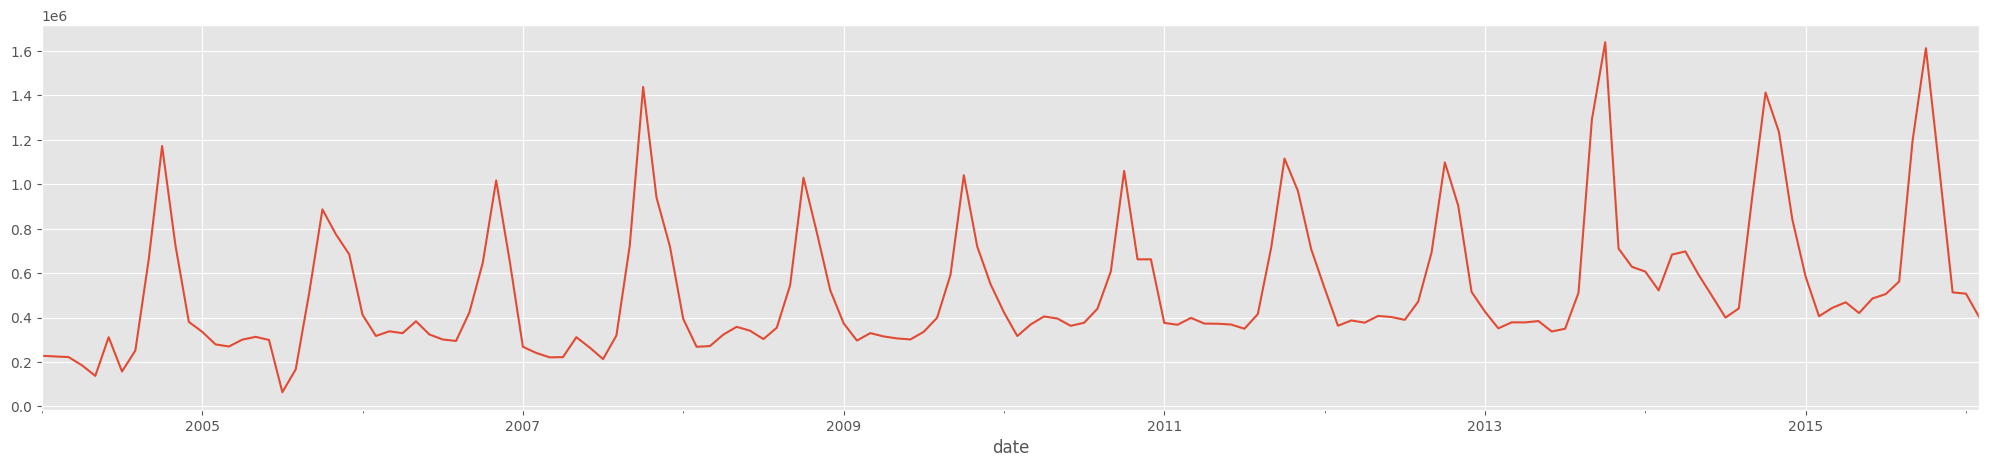

In [ ]:
# Оставим только данные по городу Бангалор
ts = df.loc[df.city == "BANGALORE"][['quantity']].copy()
print(ts.shape)
display(ts.head(2))
ts.quantity.plot(figsize=(25, 5));

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmode

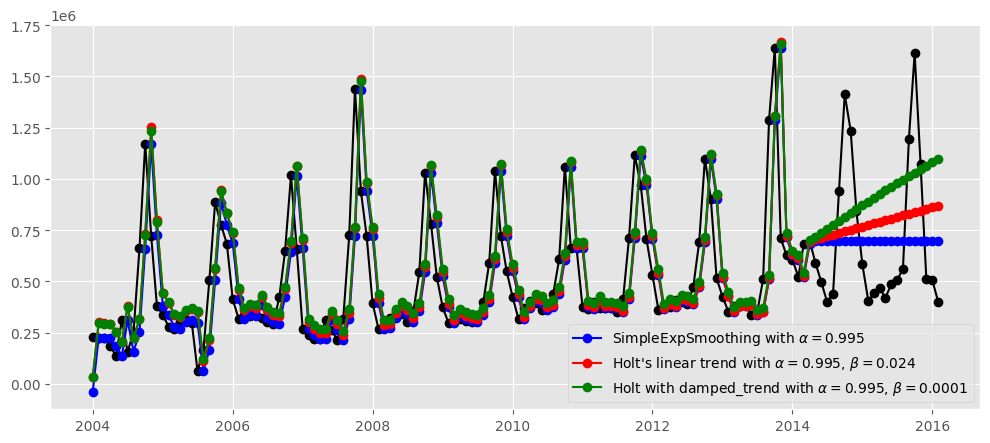

In [ ]:
# Разобьем данные на train и test (85/15)
cut_ind = int(ts.shape[0] * 0.85)
train = ts.iloc[:cut_ind]
test = ts.iloc[cut_ind:]

# Обучим следующие модели на тренировочных данных и сделаем прогноз на 22 шага вперед (величина тестовых данных):
# 1) Простое экспоненциальное сглаживание с автоматически подбираемым  α
# 2) Аддитивную Модель Хольта с автоподбором гиперпараметров
# 3) Аддитивную модель Хольта с автоподбором гиперпараметров и затухающим трендом

simple_exp = SimpleExpSmoothing(train, initialization_method = 'estimated').fit()
fcast1 = simple_exp.forecast(22).rename(r"SimpleExpSmoothing with $\alpha=%s$" % simple_exp.model.params["smoothing_level"])

holt = Holt(train, initialization_method = 'estimated').fit()
fcast2 = holt.forecast(22).rename(r"Holt's linear trend with $\alpha=%s$, $\beta=%s$" % (round(holt.params["smoothing_level"], 3), round(holt.params["smoothing_trend"], 3)))

holt2 = Holt(train, initialization_method = 'estimated', damped_trend = True).fit()
fcast3 = holt2.forecast(22).rename(r"Holt with damped_trend with $\alpha=%s$, $\beta=%s$" % (round(holt2.params["smoothing_level"], 3), round(holt2.params["smoothing_trend"], 10)))

plt.figure(figsize=(12, 5))
plt.plot(ts, marker="o", color="black")
plt.plot(simple_exp.fittedvalues, marker="o", color="blue")
(line1,) = plt.plot(fcast1, marker="o", color="blue")
plt.plot(holt.fittedvalues, marker="o", color="red")
(line2,) = plt.plot(fcast2, marker="o", color="red")
plt.plot(holt2.fittedvalues, marker="o", color="green")
(line3,) = plt.plot(fcast3, marker="o", color="green")
plt.legend([line1, line2, line3], [fcast1.name, fcast2.name, fcast3.name]);

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


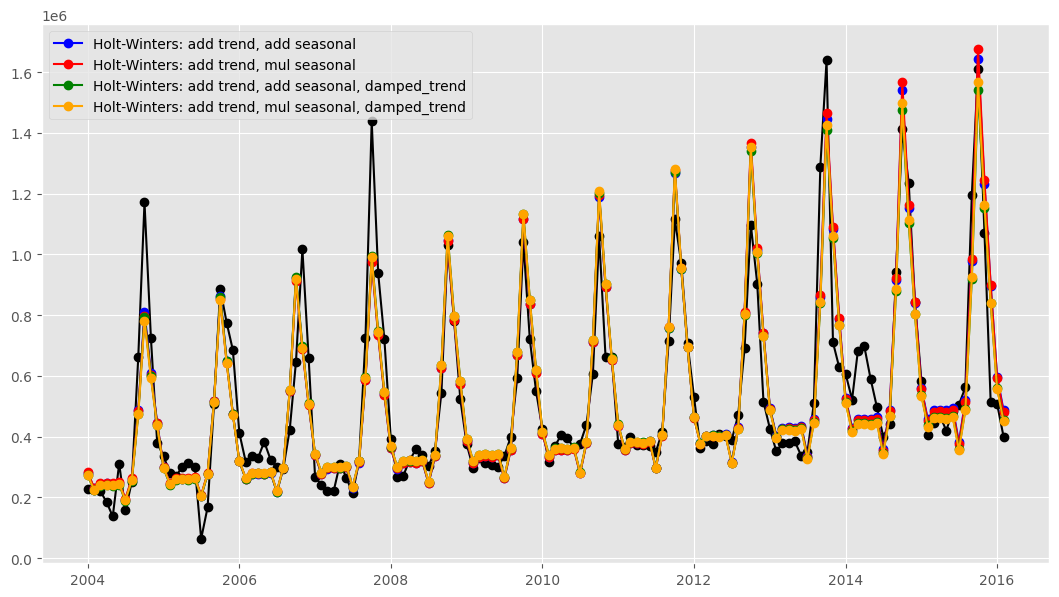

In [ ]:
# Обучим следующие модели на тренировочных данных и сделаем прогноз на 22 шага вперед (величина тестовых данных):
# 1) Модель с аддитивными трендом и сезонностью
# 2) Модель с аддитивным трендом и мультипликативной сезонностью
# 3) Модель с аддитивными трендом и сезонностью и затухающим трендом
# 4) Модель с аддитивным трендом, мультипликативной сезонностью и затухающим трендом

holt_winters1 = ExponentialSmoothing(train, seasonal_periods=12, initialization_method = 'estimated', trend="add", seasonal = 'add', use_boxcox=True).fit()
fcast1 = holt_winters1.forecast(22).rename("Holt-Winters: add trend, add seasonal")

holt_winters2 = ExponentialSmoothing(train, seasonal_periods=12, initialization_method = 'estimated', trend="add", seasonal = 'mul', use_boxcox=True).fit()
fcast2 = holt_winters2.forecast(22).rename("Holt-Winters: add trend, mul seasonal")

holt_winters3 = ExponentialSmoothing(train, seasonal_periods=12, initialization_method = 'estimated', trend="add", seasonal = 'add', damped_trend = True, use_boxcox=True).fit()
fcast3 = holt_winters3.forecast(22).rename("Holt-Winters: add trend, add seasonal, damped_trend")

holt_winters4 = ExponentialSmoothing(train, seasonal_periods=12, initialization_method = 'estimated', trend="add", seasonal = 'mul', damped_trend = True, use_boxcox=True).fit()
fcast4 = holt_winters4.forecast(22).rename("Holt-Winters: add trend, mul seasonal, damped_trend")

plt.figure(figsize=(13, 7))
plt.plot(ts, marker="o", color="black")
plt.plot(holt_winters1.fittedvalues, marker="o", color="blue")
(line1,) = plt.plot(fcast1, marker="o", color="blue")
plt.plot(holt_winters2.fittedvalues, marker="o", color="red")
(line2,) = plt.plot(fcast2, marker="o", color="red")
plt.plot(holt_winters3.fittedvalues, marker="o", color="green")
(line3,) = plt.plot(fcast3, marker="o", color="green")
plt.plot(holt_winters4.fittedvalues, marker="o", color="orange")
(line4,) = plt.plot(fcast4, marker="o", color="orange")
plt.legend([line1, line2, line3, line4], [fcast1.name, fcast2.name, fcast3.name, fcast4.name]);

# ax = ts.plot(figsize=(13, 7), marker="o", color="black", title="Forecasts from Holt-Winters' models",)
# ax.set_ylabel("Quantity")
# ax.set_xlabel("Year")
# holt_winters1.fittedvalues.plot(ax=ax, style="--", color="red")
# holt_winters2.fittedvalues.plot(ax=ax, style="--", color="orange")
# holt_winters3.fittedvalues.plot(ax=ax, style="--", color="blue")
# holt_winters4.fittedvalues.plot(ax=ax, style="--", color="green")
# fcast1.plot(ax=ax, style="--", marker="o", color="red", legend=True)
# fcast2.plot(ax=ax, style="--", marker="o", color="orange", legend=True)
# fcast3.plot(ax=ax, style="--", marker="o", color="blue", legend=True)
# fcast4.plot(ax=ax, style="--", marker="o", color="green", legend=True)
# plt.show()

In [ ]:
print(f'Holt-Winters: add trend, add seasonal  RMSE: {round(np.sqrt(mean_squared_error(test["quantity"], fcast1)), 2)}')
print(f'Holt-Winters: add trend, mul seasonal  RMSE: {round(np.sqrt(mean_squared_error(test["quantity"], fcast2)), 2)}')
print(f'Holt-Winters: add trend, add seasonal, damped_trend  RMSE: {round(np.sqrt(mean_squared_error(test["quantity"], fcast3)), 2)}')
print(f'Holt-Winters: add trend, mul seasonal, damped_trend  RMSE: {round(np.sqrt(mean_squared_error(test["quantity"], fcast4)), 2)}')

# model (Holt-Winters: add trend, mul seasonal, damped_trend) - the lowest rmse

Holt-Winters: add trend, add seasonal  RMSE: 118556.51
Holt-Winters: add trend, mul seasonal  RMSE: 120856.2
Holt-Winters: add trend, add seasonal, damped_trend  RMSE: 113919.65
Holt-Winters: add trend, mul seasonal, damped_trend  RMSE: 113896.88


###  Машинное обучение 

- Линейная регрессия
- Дерево решений / Случайный лес  
- Градиентный бустинг    

Подходы к прогнозирвоанию временных рядов можно комбинировать, результаты алгоритмов статистического и адаптивного подходов можно использовать как признаки для ML-модели. Существует множество фреймворков для работы с временными рядами, использующих различные ml-алгоритмы.    
Наиболее интересные фреймворки бля работы с Time Series: Orbit, ETNA, SkTime, Prophet, Tsfresh, FeatureTools и др.

**Признаки для прогноза временного ряда**

- Лаговые признаки (lags - значения ряда в предыдущие моменты времени)        
- Агрегированные признаки (подсчет различных статистик: mean, std, percentile и тд.)
- Экзогенные признаки (внешняя информация)  

При разбиении данных для прогнозирования временных рядов необходимо учитывать хронологию

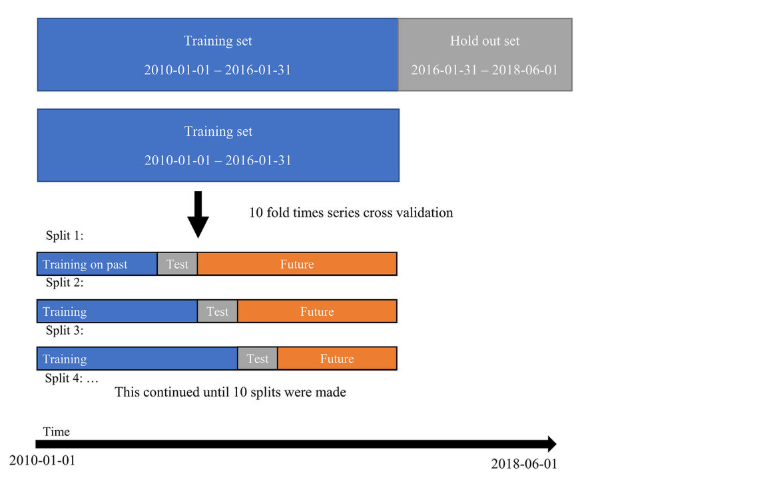

##### 1) Прогнозирование зарплаты сотрудников некоторой фирмы при помощи простой линейной регрессии

Real wage
Month                
1993-01-01     100.00
1993-02-01      99.04
1993-03-01     101.77
1993-04-01     110.05
1993-05-01     115.47

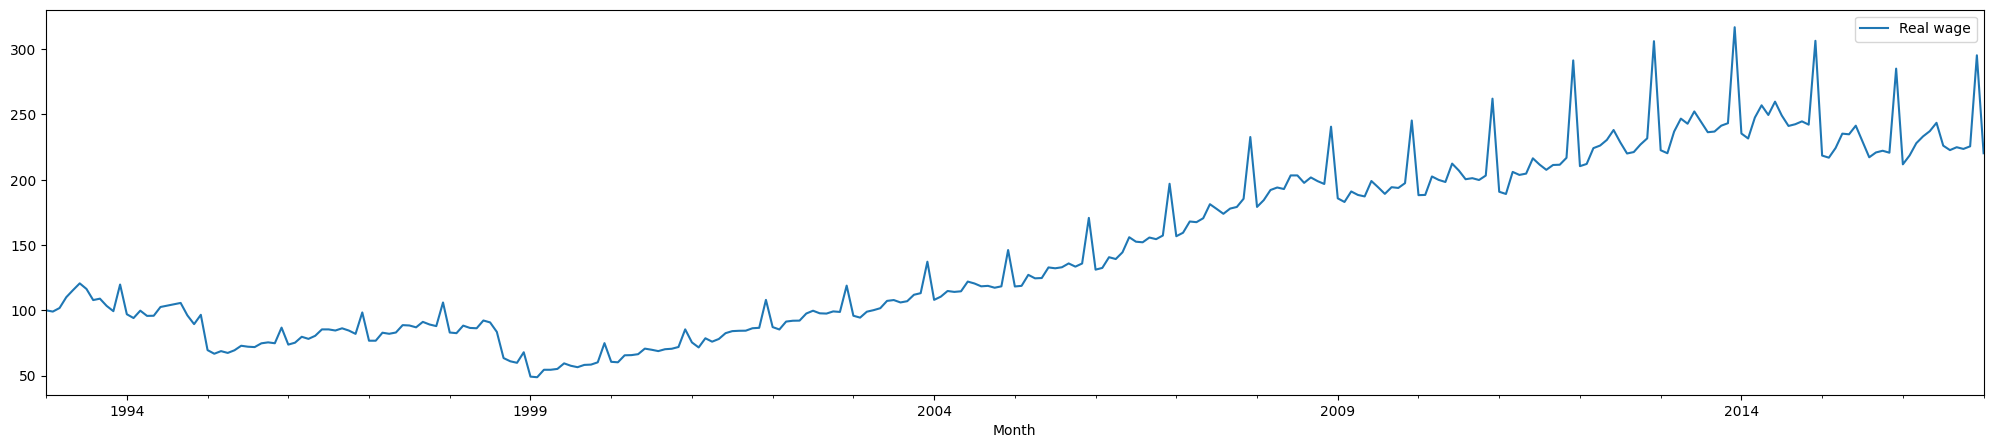

In [ ]:
ts_wage = pd.read_csv('https://raw.githubusercontent.com/aiedu-courses/stepik_applied_tasks/main/datasets/monthly_wage.csv',
                      sep=';', decimal = '.', parse_dates = True, index_col = 'Month')
ts_wage.plot(figsize = (25, 5))  # В приведенном ряде наблюдается тренд с 1999г, сезонность и увеличение расброса значений
display(ts_wage.head())

<Axes: xlabel='Timestamp'>

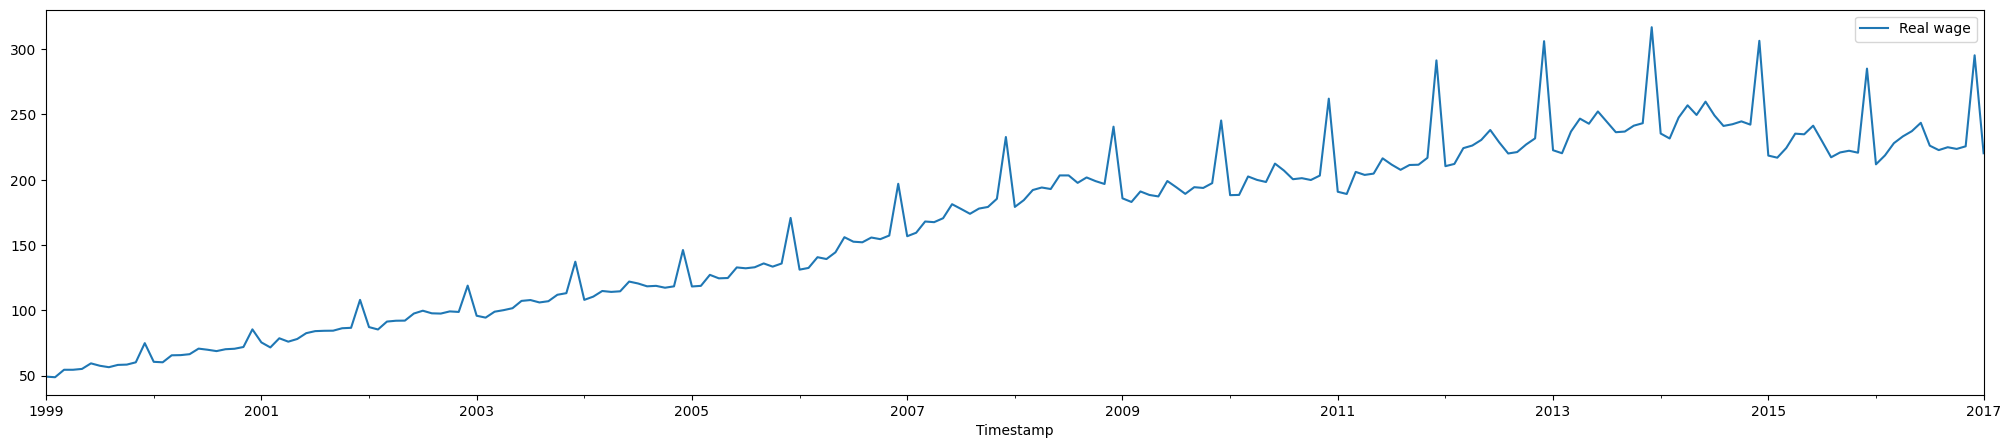

In [ ]:
ts_wage.index.names = ['Timestamp']
ts_wage = ts_wage.sort_index()
ts_wage = ts_wage.loc['01.01.1999':'01.01.2017']  # Оставим только данные с 1999г
ts_wage.plot(figsize = (25, 5))

In [ ]:
for i in range(1, 8):
    ts_wage[f'lag_{i}'] = ts_wage['Real wage'].shift(i)  
ts_wage

Real wage   lag_1   lag_2   lag_3   lag_4  lag_5  lag_6  lag_7
Timestamp                                                                 
1999-01-01      49.22     NaN     NaN     NaN     NaN    NaN    NaN    NaN
1999-02-01      48.77   49.22     NaN     NaN     NaN    NaN    NaN    NaN
1999-03-01      54.48   48.77   49.22     NaN     NaN    NaN    NaN    NaN
1999-04-01      54.48   54.48   48.77   49.22     NaN    NaN    NaN    NaN
1999-05-01      55.13   54.48   54.48   48.77   49.22    NaN    NaN    NaN
...               ...     ...     ...     ...     ...    ...    ...    ...
2016-09-01     224.90  222.70  226.10  243.60  237.20  233.2  228.0  218.6
2016-10-01     223.60  224.90  222.70  226.10  243.60  237.2  233.2  228.0
2016-11-01     225.60  223.60  224.90  222.70  226.10  243.6  237.2  233.2
2016-12-01     295.30  225.60  223.60  224.90  222.70  226.1  243.6  237.2
2017-01-01     220.30  295.30  225.60  223.60  224.90  222.7  226.1  243.6

[217 rows x 8 columns]

Text(0.5, 1.0, 'Linear Regression\nMAE: 17.41;  MAPE: 0.07')

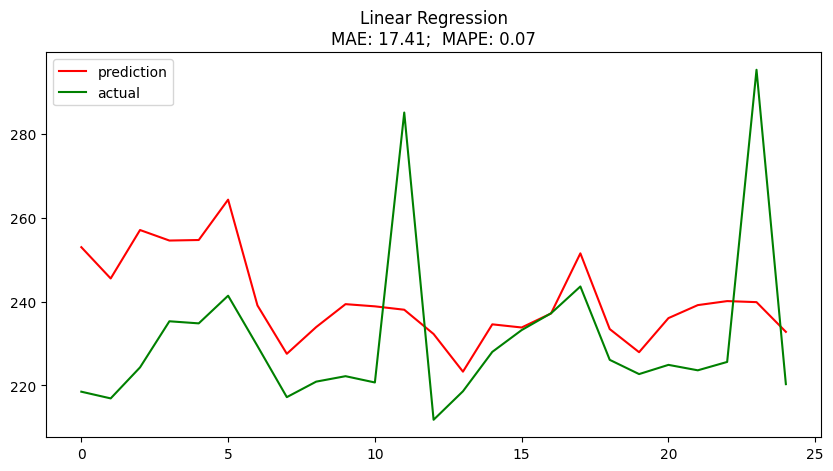

In [ ]:
ts_wage.dropna(inplace=True)

# Разобъем вручную данные на тренировочную и тестовую части (hold-out validation)
train = ts_wage.loc['01.01.1999':'31.12.2014']
test = ts_wage.loc['01.01.2015':'01.01.2017']

X_train = train.drop('Real wage', axis = 1)
y_train = train['Real wage']
X_test = test.drop('Real wage', axis = 1)
y_test = test['Real wage']

# Обучим линейную регрессию
lr = LinearRegression().fit(X_train, y_train)
preds = lr.predict(X_test)

plt.figure(figsize = (10, 5))
plt.plot(preds, color = 'red', label = 'prediction')
plt.plot(y_test.values, color = 'green', label = 'actual')
plt.grid = True
plt.legend(loc = 'best')
plt.title(f'Linear Regression\nMAE: {round(mean_absolute_error(y_test.values, preds), 2)};  MAPE: {round(mean_absolute_percentage_error(y_test.values, preds), 2)}')

Кросс-валидация на временных рядах  
  
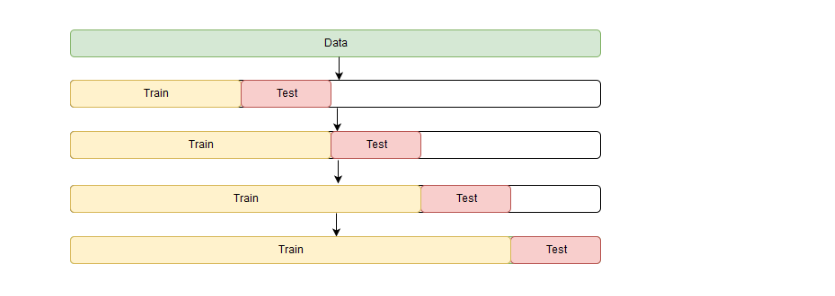

In [ ]:
X = ts_wage.drop('Real wage', axis=1)
y = ts_wage['Real wage']
mae_errors_list = []
mape_errors_list = []

tscv = TimeSeriesSplit(n_splits = 5)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]
    lr_model = LinearRegression().fit(X_train, y_train)
    lr_preds = lr_model.predict(X_test)
    mae_errors_list.append(mean_absolute_error(y_test, lr_preds))
    mape_errors_list.append(mean_absolute_percentage_error(y_test, lr_preds))

print([i.round(2) for i in mae_errors_list], [i.round(2) for i in mape_errors_list])
print(f'MAE: {round(np.mean(mae_errors_list), 2)};  MAPE: {round(np.mean(mape_errors_list), 2)}')

[5.35, 7.93, 16.28, 11.82, 16.92] [0.05, 0.05, 0.08, 0.05, 0.07]
MAE: 11.66;  MAPE: 0.06


In [ ]:
lr_m = LinearRegression()
ts = TimeSeriesSplit(n_splits = 5)

cross_mae_score = cross_val_score(lr_m, X, y, cv = ts, scoring = 'neg_mean_absolute_error')
cross_mape_score = cross_val_score(lr_m, X, y, cv = ts, scoring = 'neg_mean_absolute_percentage_error')
print(f'MAE: {-cross_mae_score.mean().round(2)};  MAPE: {-cross_mape_score.mean().round(2)}')

MAE: 11.66;  MAPE: 0.06


In [ ]:
# Добавим новый признак - среднее значение целевой переменной по месяцам
# Считаем средние только по тренировочной части, чтобы избежать data leak

def code_mean(data, cat_feature, real_feature):
    return dict(data.groupby(cat_feature)[real_feature].mean())
    
ts_wage["month"] = ts_wage.index.month
ts_wage["year"] = ts_wage.index.year
month_mean_dict = code_mean(ts_wage.loc[:'31.12.2014'], 'month', 'Real wage')
year_mean_dict = code_mean(ts_wage.loc[:'31.12.2014'], 'year', 'Real wage')
# ts_wage['month_average'] = ts_wage['month'].apply(lambda x: month_mean_dict[x])
ts_wage['month_average'] = ts_wage['month'].map(month_mean_dict)
ts_wage.drop(['month', 'year', 'Real wage'], axis = 1, inplace=True)
ts_wage[:2]

lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  month_average
Timestamp                                                                 
1999-08-01  57.54  59.38  55.13  54.48  54.48  48.77  49.22     155.198125
1999-09-01  56.45  57.54  59.38  55.13  54.48  54.48  48.77     157.175000

In [ ]:
pprint(month_mean_dict)  # В летние месяцы значения ряда повышаются, в декабре наблюдается пик (возможно, за счет премий)
print()
pprint(year_mean_dict)   # Наблюдается возрастающий тренд

{1: 149.70266666666666,
 2: 149.432,
 3: 159.036,
 4: 159.68266666666665,
 5: 159.90533333333332,
 6: 168.75799999999998,
 7: 165.51333333333332,
 8: 155.198125,
 9: 157.175,
 10: 157.99,
 11: 159.93125,
 12: 202.490625}

{1999: 61.626,
 2000: 68.81666666666666,
 2001: 82.98916666666666,
 2002: 96.44666666666666,
 2003: 106.78083333333332,
 2004: 118.6275,
 2005: 132.28666666666666,
 2006: 151.0925,
 2007: 177.52416666666667,
 2008: 198.74749999999997,
 2009: 195.715,
 2010: 205.28,
 2011: 213.40833333333333,
 2012: 231.35,
 2013: 245.07500000000002,
 2014: 250.6}


In [ ]:
# Обернем все шаги в функцию
def preprocess_data(data, real_feature = 'Real wage', lag_start = 1, lag_end = 8, date_cut = '31.12.2014'):
    data = pd.DataFrame(data.copy())

    # Добавляем лаговые признаки
    for i in range(lag_start, lag_end):  
        data[f'lag_{i}'] = data[real_feature].shift(i)
    data = data.dropna()

    # Считаем средние только по тренировочной части, чтобы избежать data leak
    def code_mean(data, cat_feature, real_feature):
        return dict(data.groupby(cat_feature)[real_feature].mean())
    data['month'] = data.index.month
    data['month_average'] = list(map(code_mean(data.loc[:date_cut], 'month', 'Real wage').get, data['month']))

    # разбиваем весь датасет на тренировочную и тестовую выборку
    data.drop(["month"], axis=1, inplace=True)
    X_train = data.loc[:date_cut].drop('Real wage', axis = 1)
    y_train = data.loc[:date_cut]['Real wage']

    X_test = data.loc[date_cut:].drop('Real wage', axis = 1)
    y_test = data.loc[date_cut:]['Real wage']

    return X_train, X_test, y_train, y_test

X_train: (185, 8) X_test: (25, 8)


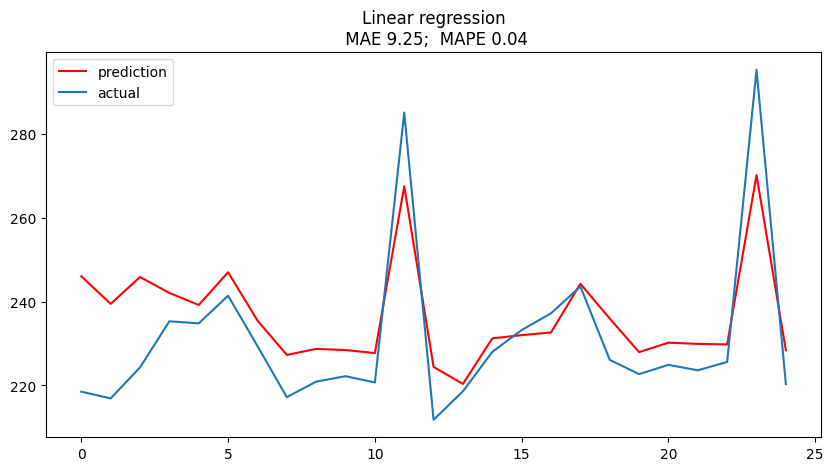

In [ ]:
ts_wage = pd.read_csv('https://raw.githubusercontent.com/aiedu-courses/stepik_applied_tasks/main/datasets/monthly_wage.csv',
                        sep=';', decimal='.', parse_dates=True, index_col='Month')
ts_wage.index.names=['Timestamp']
ts_wage = ts_wage.sort_index()
ts_wage = ts_wage.loc['01.01.1999':'01.01.2017']

# Разделим выборки и обучим модель
X_train, X_test, y_train, y_test = preprocess_data(ts_wage)
print('X_train:', X_train.shape, 'X_test:', X_test.shape)
lr = LinearRegression().fit(X_train, y_train)
preds = lr.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(preds, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.grid = True
plt.legend(loc="best")
plt.title(f"Linear regression\n MAE {mean_absolute_error(preds, y_test).round(2)};  MAPE {mean_absolute_percentage_error(preds, y_test).round(2)}");

Видно, что после добавления нового признака month_average простая линейная модель показала довольно хороший результат, учла сезонные эффекты.

In [ ]:
# Посмотрим на результат модели на кросс-валидации (TimeSeriesSplit)
X = pd.concat([X_train, X_test], axis =0)
y = pd.concat([y_train, y_test], axis =0)

mae_errors_list = []
mape_errors_list = []

tscv = TimeSeriesSplit(n_splits = 5)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]
    lr_model = LinearRegression().fit(X_train, y_train)
    lr_preds = lr_model.predict(X_test)
    mae_errors_list.append(mean_absolute_error(y_test, lr_preds))
    mape_errors_list.append(mean_absolute_percentage_error(y_test, lr_preds))

print([i.round(2) for i in mae_errors_list], [i.round(2) for i in mape_errors_list])
print(f'MAE: {round(np.mean(mae_errors_list), 2)};  MAPE: {round(np.mean(mape_errors_list), 2)}')

[2.93, 5.69, 8.95, 8.28, 8.92] [0.03, 0.03, 0.04, 0.03, 0.04]
MAE: 6.95;  MAPE: 0.03


X_train: (169, 13) X_test: (25, 13)


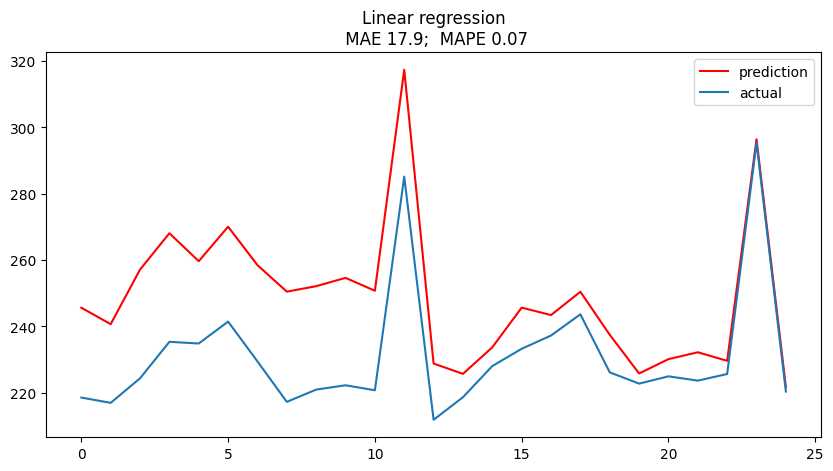

In [ ]:
# Поменяем лаг и посмотрим на честный прогноз модели (lag_start = 12, lag_end = 24)
X_train, X_test, y_train, y_test = preprocess_data(ts_wage, lag_start = 12, lag_end = 24)
print('X_train:', X_train.shape, 'X_test:', X_test.shape)

# Обучим модель
lr = LinearRegression().fit(X_train, y_train)
preds = lr.predict(X_test)
plt.figure(figsize=(10, 5))
plt.plot(preds, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.grid = True
plt.legend(loc="best")
plt.title(f"Linear regression\n MAE {mean_absolute_error(preds, y_test).round(2)};  MAPE {mean_absolute_percentage_error(preds, y_test).round(2)}");

##### 2) Прогнозирование стоимости биткоина на момент открытия торгов при помощи линейной регрессии  

В датасете хранится информация о стоимости биткоина на 5-минутном интервале

(4608, 5)
2023-06-18 00:00:00
2023-07-03 23:55:00


open     high       low     close   volume
timestamp                                                          
2023-06-18 00:00:00  26519.10  26542.5  26501.76  26515.80  35.4498
2023-06-18 00:05:00  26508.01  26535.0  26506.13  26511.30   7.4262
2023-06-18 00:10:00  26511.30  26551.0  26508.77  26519.62  18.9461
2023-06-18 00:15:00  26519.44  26550.0  26464.43  26511.99  89.2364
2023-06-18 00:20:00  26513.33  26541.0  26414.28  26439.52  90.0204

<Axes: xlabel='timestamp'>

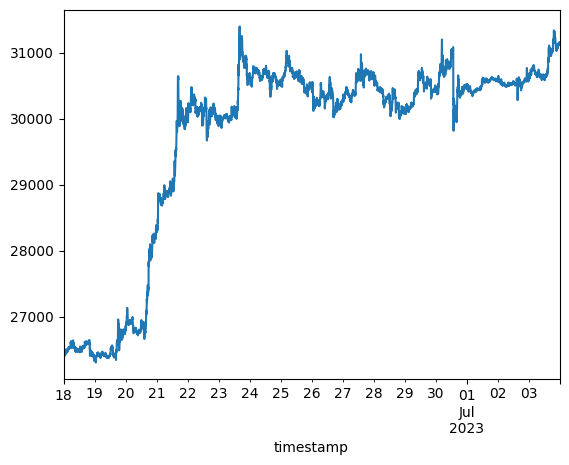

In [ ]:
# Загрузим и посмотрим на данные
data = pd.read_csv("https://raw.githubusercontent.com/aiedu-courses/stepik_applied_tasks/main/datasets/BTC_5min_sample.csv",
                   parse_dates = True, index_col = 'timestamp')
data.sort_index(inplace = True)
print(data.shape)
print(data.index.min(), data.index.max(), sep = '\n')

display(data.head())
data['open'].plot()

In [ ]:
def preprocessing(data, real_col = 'open', lag_start = 5, lag_end = 20, test_size = 0.15, short_feature_list = 0):
    '''
    Простая предобработка датасета, добавление новых признаков
    '''
    df = data.copy()
    # Добавляем признак скользящее среднее. Возьмем окна размером 3, 10 и 15
    df['moving_avg_3'] = df.rolling(window=3)['open'].mean().shift(1)
    df['moving_avg_10'] = df.rolling(window=10)['open'].mean().shift(1)
    df['moving_avg_15'] = df.rolling(window=15)['open'].mean().shift(1)

    # Добавляем признак тренд
    res = sm.tsa.seasonal_decompose(df[['open']], extrapolate_trend = 'freq', period = 50)
    df['trend'] = res.trend.shift(1)
    df = df.dropna()

    # Добавляем лаговые признаки
    for i in range(lag_start, lag_end):
        df.loc[:, f'lag_{i}'] = df[real_col].shift(i)
    for i in range(lag_start, lag_end):
        df.loc[:, f'lag_high_{i}'] = df['high'].shift(i)
    for i in range(lag_start, lag_end):
        df.loc[:, f'lag_low_{i}'] = df['low'].shift(i)
    df = df.dropna()

    # Добавляем признаки: средние значение по часу, дню недели, флаг - выходной ли день (1\0)
    # Считаем средние только по тренировочной части, чтобы избежать data leak
    def code_mean(data, feature2group, real_col = 'open'):
        return dict(data.groupby(feature2group)[real_col].mean().round(2))

    border = int(df.shape[0]*(1-test_size))
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['is_weekend'] = df['dayofweek'].between(5, 6).astype('int')

    df['dayofweek_cost_mean'] = list(map(code_mean(df[:border], 'dayofweek').get, df['dayofweek']))
    df['hour_cost_mean'] = list(map(code_mean(df[:border], 'hour').get, df['hour']))
#     train_mean = code_mean(df[:border], 'dayofweek', 'open')
#     df['dayofweek_cost_mean'] = df['dayofweek'].apply(lambda x: train_mean[x])
#     df['dayofweek_cost_mean'] = df['dayofweek'].map(train_mean)
    if not short_feature_list: df = pd.get_dummies(data = df, columns = ['dayofweek'], drop_first = True, dtype = 'int')

    # Удаляем ненужный столбец/столбцы и разбиваем весь датасет на тренировочную и тестовую выборку
    df.drop(['hour', 'high', 'low', 'close', 'volume'], axis = 1, inplace = True, errors='ignore')
    if short_feature_list: df.drop(['dayofweek', 'is_weekend', 'hour_cost_mean', 'dayofweek_cost_mean'], axis = 1, inplace = True, errors='ignore')
    # X_train, X_test = train_test_split(X, test_size=0.15, shuffle=False)
    X_train = df.iloc[:border].drop(real_col, axis=1)
    y_train = df.iloc[:border][real_col]
    X_test = df.iloc[border:].drop(real_col, axis=1)
    y_test = df.iloc[border:][real_col]

    return X_train, X_test, y_train, y_test

In [ ]:
def find_best_lags(data, start_a=1, start_b=20, end_a=20, end_b=40, flag_print=0, short_feature_list=0):
    '''
    Перебор различных значений лагов (lag_start, lag_end)
    '''
    lag_error_dict = {}
    for lag_start in range(start_a, start_b):
        for lag_end in range(end_a, end_b):
            if lag_start > lag_end: continue
            data_new = data.copy()
            X_train, X_test, y_train, y_test = preprocessing(data_new, real_col='open', short_feature_list=short_feature_list,
                                                             lag_start = lag_start, lag_end = lag_end, test_size = 0.15)
            lr_new = LinearRegression().fit(X_train, y_train)
            y_pred = lr_new.predict(X_test)
            mae = mean_absolute_error(y_test, y_pred).round(5)
            mape = mean_absolute_percentage_error(y_test, y_pred).round(5)
            lag_error_dict[(lag_start, lag_end)] = (mae, mape)

            if flag_print:
                if not any([lag_start % 5, lag_end % 5]):
                    print(f'params: lag_start: {lag_start}, lag_end: {lag_end},  MAE: {mae}')

    best_lags = sorted(lag_error_dict.items(), key = lambda x: x[1])[0]
    if flag_print: print(f'\nbest_lags: {best_lags[0]}, \nMAE: {best_lags[1][0]}; MAPE: {best_lags[1][1]}')
    lag_start, lag_end = best_lags[0][0], best_lags[0][1]
    mae, mape = best_lags[1][0], best_lags[1][1]

    return lag_start, lag_end, mae, mape

In [ ]:
# Переберём различные варианты lag_start, lag_end и посмотрим на результат линейной регрессии
lag_start, lag_end, mae, mape = find_best_lags(data, start_a=1, start_b=20, end_a=20, end_b=40, flag_print=1)

params: lag_start: 5, lag_end: 20,  MAE: 19.1598
params: lag_start: 5, lag_end: 25,  MAE: 19.2199
params: lag_start: 5, lag_end: 30,  MAE: 19.49636
params: lag_start: 5, lag_end: 35,  MAE: 19.7448
params: lag_start: 10, lag_end: 20,  MAE: 19.22896
params: lag_start: 10, lag_end: 25,  MAE: 19.09404
params: lag_start: 10, lag_end: 30,  MAE: 19.45968
params: lag_start: 10, lag_end: 35,  MAE: 19.58537
params: lag_start: 15, lag_end: 20,  MAE: 17.60716
params: lag_start: 15, lag_end: 25,  MAE: 18.13709
params: lag_start: 15, lag_end: 30,  MAE: 18.5624
params: lag_start: 15, lag_end: 35,  MAE: 18.75798

best_lags: (1, 38), 
MAE: 9.4306; MAPE: 0.00031


MAE 8.778; MAPE 0.00029.


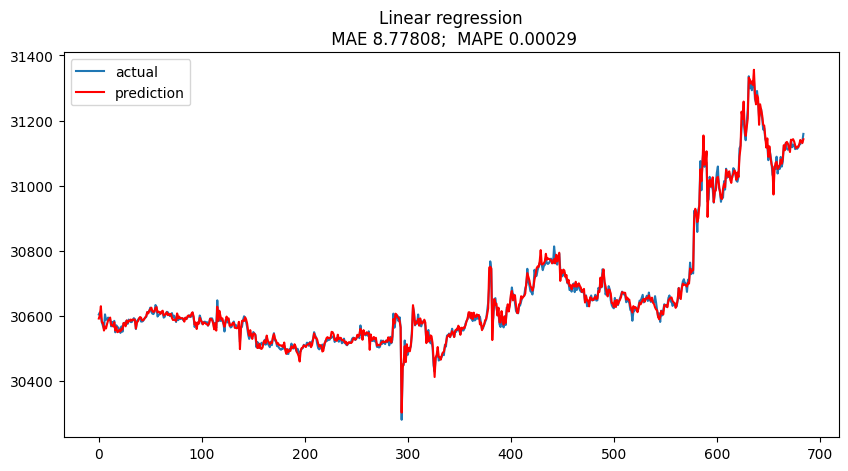

In [ ]:
# При обучении модели только с лаговыми признаками, трендом и скользящими средними результат оказался лучше: MAE = 8.77
lag_start, lag_end, mae, mape = find_best_lags(data, start_a=1, start_b=20, end_a=20, end_b=40,
                                               flag_print=0, short_feature_list = 1)
X_train, X_test, y_train, y_test = preprocessing(data, lag_start = lag_start, lag_end = lag_end, short_feature_list=1)
lr = LinearRegression().fit(X_train, y_train)
preds = lr.predict(X_test)
print(f"MAE {mean_absolute_error(preds, y_test).round(3)}; MAPE {mean_absolute_percentage_error(preds, y_test).round(5)}.")

plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label = "actual")
plt.plot(preds, "r", label = "prediction")
plt.grid = True
plt.legend(loc = "best")
plt.title(f"Linear regression\n MAE {mean_absolute_error(preds, y_test).round(5)};  MAPE {mean_absolute_percentage_error(preds, y_test).round(5)}");

##### 3) Прогнозирование среднесуточной дневной температуре в г.Дели (meantemp) при помощи линейной регрессии

In [ ]:
# Набор данных по среднесуточной дневной температуре в городе Дели за несколько лет
df = pd.read_csv('https://raw.githubusercontent.com/aiedu-courses/stepik_applied_tasks/main/datasets/DailyDelhiClimateTrain.csv')
print(df.shape)
print(df['date'].agg(['min', 'max']))
df['date'] = pd.to_datetime(df['date'])
df = df[['date','meantemp']].set_index('date')
display(df[:3])

(1461, 5)
min    2013-01-01
max    2016-12-31
Name: date, dtype: object


meantemp
date                 
2013-01-01  10.000000
2013-01-02   7.400000
2013-01-03   7.166667

In [ ]:
def find_average(data, cat_feature, real_feature):
    return dict(data.groupby(cat_feature)[real_feature].mean())

def preprocess_data(data, lag_start=5, lag_end=20, test_size=0.15):
    data = pd.DataFrame(data.copy())
    test_index = int(len(data) * (1 - test_size))

    # Добавляем лаги исходного ряда
    for i in range(lag_start, lag_end):    
        data[f"lag_{i}"] = data.meantemp.shift(i)

    data["weekday"] = data.index.weekday
#    data["week"] = data.index.week
    data["month"] = data.index.month
    data["year"] = data.index.year

    # Считаем средние только по тренировочной части, чтобы data leak
    data["weekday_average"] = list(map(find_average(data[:test_index], "weekday", "meantemp").get, data.weekday))
#    data["week_average"] = list(map(find_average(data[:test_index], "week", "meantemp").get, data.week))
    data["month_average"] = list(map(find_average(data[:test_index], "month", "meantemp").get, data.month))
    data["year_average"] = list(map(find_average(data[:test_index], "year", "meantemp").get, data.year))

    data.drop(["weekday", 'month', 'year'], axis=1, inplace=True)  # Удаляем закодированные средними признаки
    data = data.dropna()
    data = data.reset_index(drop=True)

    X_train = data.loc[:test_index].drop(["meantemp"], axis=1)     # Разбиваем  датасет на train и test
    y_train = data.loc[:test_index]["meantemp"]
    X_test = data.loc[test_index:].drop(["meantemp"], axis=1)
    y_test = data.loc[test_index:]["meantemp"]

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = preprocess_data(df, test_size=0.3, lag_start=3, lag_end=10)
X_train.head(3)

lag_3     lag_4  lag_5     lag_6     lag_7     lag_8      lag_9  \
0   7.000000  7.000000    6.0  8.666667  7.166667  7.400000  10.000000   
1   8.857143  7.000000    7.0  6.000000  8.666667  7.166667   7.400000   
2  14.000000  8.857143    7.0  7.000000  6.000000  8.666667   7.166667   

   weekday_average  month_average  year_average  
0        25.440460      12.738377     24.791494  
1        25.372054      12.738377     24.791494  
2        25.331414      12.738377     24.791494

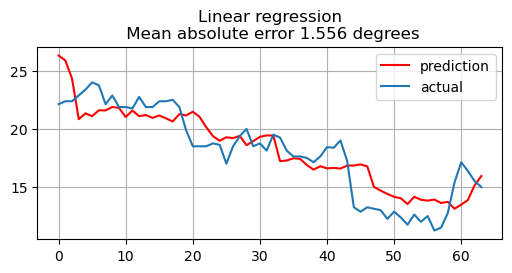

In [ ]:
lr_deli = LinearRegression()
lr_deli.fit(X_train, y_train)
preds_deli = lr_deli.predict(X_test)

plt.figure(figsize=(6, 2.5))
plt.plot(preds_deli, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Linear regression\n Mean absolute error {mean_absolute_error(preds_deli, y_test).round(3)} degrees");

In [ ]:
coef_table = pd.DataFrame({'features' : list(X_train.columns), 'weights' : list(lr_deli.coef_)}).sort_values('weights', ascending = False)
coef_table

features   weights
7  weekday_average  1.371299
8    month_average  0.459795
0            lag_3  0.377216
1            lag_4  0.096807
9     year_average  0.069241
3            lag_6  0.038893
2            lag_5  0.027257
5            lag_8  0.016994
4            lag_7 -0.008115
6            lag_9 -0.017693

**Учет экзогенных факторов**

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/aiedu-courses/stepik_applied_tasks/main/datasets/DailyDelhiClimateTrain.csv')
df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d')
df = df[['date', 'meantemp', 'meanpressure']].set_index('date')
df.head(2)

meantemp  meanpressure
date                              
2013-01-01      10.0   1015.666667
2013-01-02       7.4   1017.800000

In [ ]:
def find_average(data, cat_feature, real_feature):
    return dict(data.groupby(cat_feature)[real_feature].mean())

def preprocess_data_exog(data, lag_start=5, lag_end=20, test_size=0.15):
    exog = "meanpressure"
    data = pd.DataFrame(data.copy())
    test_index = int(len(data) * (1 - test_size))

    # Добавляем лаги
    for i in range(lag_start, lag_end):
        data[f"lag_{i}"] = data['meantemp'].shift(i)
        data[f"lag_exog_{i}"] = data[exog].shift(i)

    data["weekday"] = data.index.weekday  # data.index.dayofweek
    data["week"] = data.index.week
    data["month"] = data.index.month
    data["year"] = data.index.year

    # считаем средние только по тренировочной части, чтобы избежать data leak
    data["weekday_average"] = list(map(find_average(data[:test_index], "weekday", "meantemp").get, data.weekday))
    data["week_average"] = list(map(find_average(data[:test_index], "week", "meantemp").get, data.week))
    data["month_average"] = list(map(find_average(data[:test_index], "month", "meantemp").get, data.month))
    data["year_average"] = list(map(find_average(data[:test_index], "year", "meantemp").get, data.year))

    data["weekday_average_exog"] = list(map(find_average(data[:test_index], "weekday", exog).get, data.weekday))
    data["week_average_exog"] = list(map(find_average(data[:test_index], "week", exog).get, data.week))
    data["month_average_exog"] = list(map(find_average(data[:test_index], "month", exog).get, data.month))
    data["year_average_exog"] = list(map(find_average(data[:test_index], "year", exog).get, data.year))

    # выкидываем закодированные средними признаки
    data.drop(["weekday", "week", "month", "year", exog], axis=1, inplace=True)

    data = data.dropna()
    data = data.reset_index(drop=True)

    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["meantemp"], axis=1)
    y_train = data.loc[:test_index]["meantemp"]
    X_test = data.loc[test_index:].drop(["meantemp"], axis=1)
    y_test = data.loc[test_index:]["meantemp"]

    return X_train, X_test, y_train, y_test

X_train_new, X_test_new, y_train_new, y_test_new = preprocess_data_exog(df, test_size=0.3, lag_start=3, lag_end=10)
X_train, X_test, y_train, y_test = preprocess_data(df, test_size=0.3, lag_start=3, lag_end=10)
X_train_new.head()

lag_3   lag_exog_3      lag_4   lag_exog_4      lag_5   lag_exog_5  \
0   7.000000  1020.000000   7.000000  1018.000000   6.000000  1016.500000   
1   8.857143  1018.714286   7.000000  1020.000000   7.000000  1018.000000   
2  14.000000  1017.000000   8.857143  1018.714286   7.000000  1020.000000   
3  11.000000  1015.666667  14.000000  1017.000000   8.857143  1018.714286   
4  15.714286  1016.142857  11.000000  1015.666667  14.000000  1017.000000   

      lag_6   lag_exog_6     lag_7   lag_exog_7  ...      lag_9   lag_exog_9  \
0  8.666667  1017.166667  7.166667  1018.666667  ...  10.000000  1015.666667   
1  6.000000  1016.500000  8.666667  1017.166667  ...   7.400000  1017.800000   
2  7.000000  1018.000000  6.000000  1016.500000  ...   7.166667  1018.666667   
3  7.000000  1020.000000  7.000000  1018.000000  ...   8.666667  1017.166667   
4  8.857143  1018.714286  7.000000  1020.000000  ...   6.000000  1016.500000   

   weekday_average  week_average  month_average  year_average  \
0        25.440460     11.925454      12.738377     24.791494   
1        25.372054     11.925454      12.738377     24.791494   
2        25.331414     11.925454      12.738377     24.791494   
3        25.202210     11.925454      12.738377     24.791494   
4        25.499234     13.067177      12.738377     24.791494   

   weekday_average_exog  week_average_exog  month_average_exog  \
0           1007.715550        1017.573980         1018.552483   
1           1007.542990        1017.573980         1018.552483   
2           1007.585645        1017.573980         1018.552483   
3           1007.803264        1017.573980         1018.552483   
4           1007.899013        1018.442744         1018.552483   

   year_average_exog  
0        1007.642172  
1        1007.642172  
2        1007.642172  
3        1007.642172  
4        1007.642172  

[5 rows x 22 columns]

In [ ]:
# лин.регр на исходных данных без экзогенных признаков 
lr = LinearRegression()
lr.fit(X_train, y_train)
preds = lr.predict(X_test)
print(f"LR without exogenous features. MAE {mean_absolute_error(preds, y_test).round(3)} degrees")

# лин.регр на данных с экзогенными факторами для сравнения (weekday_average_exog, week_average_exog, month_average_exog, year_average_exog)
lr = LinearRegression()
lr.fit(X_train_new, y_train_new)
preds_new = lr.predict(X_test_new)
print(f"LR with exogenous features. MAE {mean_absolute_error(preds_new, y_test_new).round(3)} degrees")

LR without exogenous features. MAE 1.456 degrees
LR with exogenous features. MAE 1.341 degrees


In [ ]:
coef_table = pd.DataFrame({'features' : list(X_train_new.columns), 'weights' : lr.coef_}).sort_values(by='weights', ascending=False)
coef_table

features   weights
14       weekday_average  1.103748
15          week_average  0.734624
0                  lag_3  0.221381
21     year_average_exog  0.088747
18  weekday_average_exog  0.065935
2                  lag_4  0.055325
17          year_average  0.051289
16         month_average  0.031276
5             lag_exog_5  0.030651
1             lag_exog_3  0.021729
10                 lag_8  0.013476
11            lag_exog_8  0.010108
9             lag_exog_7  0.007471
20    month_average_exog  0.005108
6                  lag_6  0.004960
4                  lag_5  0.003910
13            lag_exog_9 -0.002883
3             lag_exog_4 -0.006093
8                  lag_7 -0.016592
7             lag_exog_6 -0.019726
19     week_average_exog -0.044474
12                 lag_9 -0.052149

##### 3) Прогнозирование среднесуточной дневной температуры в г.Дели при помощи решающего дерева и случайного леса  
- модель с дефолтными параметрами
- модель с подобранными гиперпараметрами Optuna

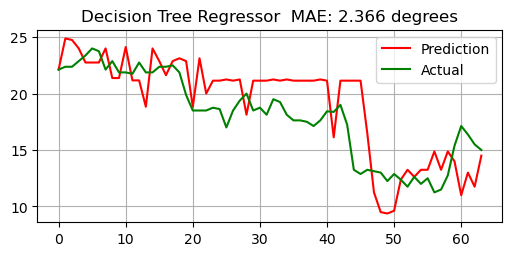

In [ ]:
# Default Decision Tree
dt = DecisionTreeRegressor().fit(X_train, y_train)
preds = dt.predict(X_test)

plt.figure(figsize = (6, 2.5))
plt.plot(preds, color = 'red', label = 'Prediction')
plt.plot(y_test.values, color = 'green', label = 'Actual')
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Decision Tree Regressor  MAE: {mean_absolute_error(preds, y_test).round(3)} degrees");
plt.show()

In [ ]:
# Tuned Decision Tree
import optuna, logging

def objective_dt(trial):
    model = DecisionTreeRegressor(max_depth = trial.suggest_int("max_depth", 2, 20),
                                  min_samples_split = trial.suggest_int("min_samples_split", 2, 15),
                                  min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 15),
                                  max_features = trial.suggest_categorical("max_features", [None, 'auto', 'sqrt', 'log2']),
                                  random_state = RANDOM_SEED)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    return mae

# logging.getLogger("optuna").setLevel(logging.ERROR)   # Отключить логирование
RANDOM_SEED = 42
study_dt = optuna.create_study(study_name = 'Study_dt_ts_deli', direction='minimize')
study_dt.optimize(objective_dt, n_trials=200, show_progress_bar=True)

best_params_dt = study_dt.best_params
best_score_dt = study_dt.best_value
print(f"Best Hyperparameters: {best_params_dt}")
print(f"MAE: {best_score_dt:.3f}")

# optuna.visualization.plot_optimization_history(study_dt)
# optuna.visualization.plot_slice(study_dt, params=['n_estimators', 'max_depth', ])

100%|██████████| 200/200 [00:02<00:00, 84.06it/s]

Best Hyperparameters: {'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 14, 'max_features': None}
MAE: 1.264


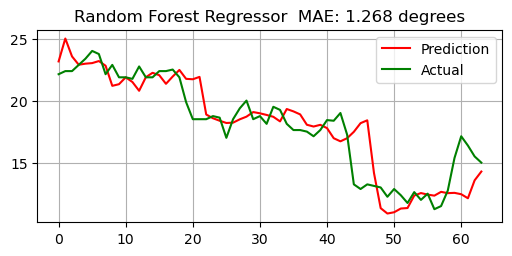

In [ ]:
# Default Random Forest
rf_simple = RandomForestRegressor().fit(X_train, y_train)
preds = rf_simple.predict(X_test)

plt.figure(figsize = (6, 2.5))
plt.plot(preds, color = 'red', label = 'Prediction')
plt.plot(y_test.values, color = 'green', label = 'Actual')
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Random Forest Regressor  MAE: {mean_absolute_error(preds, y_test).round(3)} degrees");
plt.show()

In [ ]:
# Tuned Random Forest
def objective_rf(trial):
    model = RandomForestRegressor(n_estimators = trial.suggest_int("n_estimators", 10, 300),
                                  max_depth = trial.suggest_int("max_depth", 2, 20),
                                  max_features = trial.suggest_categorical('max_features', [None, 'auto', 'sqrt', 'log2']),
                                  min_samples_split = trial.suggest_int("min_samples_split", 2, 10),
                                  min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10),
                                  n_jobs = -1, random_state = RANDOM_SEED)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    return mae


# logging.getLogger("optuna").setLevel(logging.ERROR)   # Отключить логирование
RANDOM_SEED = 42
study_rf = optuna.create_study(study_name = 'Study_rf_ts_deli', direction='minimize')
study_rf.optimize(objective_rf, n_trials=200, show_progress_bar=True)

best_params_rf = study_rf.best_params
best_score_rf = study_rf.best_value
print(f"Best Hyperparameters: {best_params_rf}")
print(f"MAE: {best_score_rf:.3f}")

# optuna.visualization.plot_optimization_history(study_rf)
# optuna.visualization.plot_slice(study_rf, params=['n_estimators', 'max_depth', max_features, min_samples_split, min_samples_leaf])

100%|██████████| 200/200 [01:46<00:00,  1.88it/s]

Best Hyperparameters: {'n_estimators': 118, 'max_depth': 5, 'max_features': None, 'min_samples_split': 9, 'min_samples_leaf': 5}
MAE: 1.150


##### 3) Прогнозирование среднесуточной дневной температуре в г.Дели (meantemp) при помощи библиотеки градиентного бустинга CatBoost  
- модель с дефолтными параметрами
- модель с подобранными гиперпараметрами Optuna

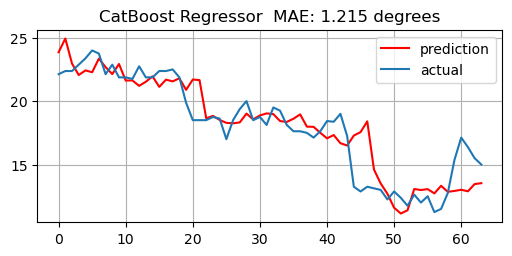

In [ ]:
# Default CatBoost
cb = CatBoostRegressor(verbose = 0).fit(X_train, y_train)
preds = cb.predict(X_test)

plt.figure(figsize=(6, 2.5))
plt.plot(preds, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"CatBoost Regressor  MAE: {mean_absolute_error(preds, y_test).round(3)} degrees");

In [ ]:
coef_table = pd.DataFrame({'features' : list(X_train.columns), 'importance' : cb.feature_importances_}).sort_values(by='importance')
coef_table

features  importance
7  weekday_average    1.910394
9     year_average    2.887779
5            lag_8    6.717282
3            lag_6    8.960905
6            lag_9    8.979116
2            lag_5    9.926165
4            lag_7   10.298564
1            lag_4   12.741074
8    month_average   18.398823
0            lag_3   19.179899

In [ ]:
# X = pd.concat([X_train, X_test], axis = 0, ignore_index=True)
# y = pd.concat([y_train, y_test], axis = 0, ignore_index=True)

# # Tuned CatBoost
# tscv = TimeSeriesSplit(n_splits=5)

# def objective_cb(trial):
#     params = {
#         'n_estimators' : trial.suggest_int('n_estimators', 100, 400),
#         'learning_rate': trial.suggest_float("learning_rate", 1e-3, 1.0, log=True),
#         'max_depth' : trial.suggest_int('max_depth', 2, 15),
#         'random_strength' : trial.suggest_int("random_strength", 0, 10)
#     }

#     model = CatBoostRegressor(**params,verbose = 0, random_seed = RANDOM_SEED  )

#     # Кросс-валидация TimeSeriesSplit
#     mae_errors = []
#     for train_index, test_index in tscv.split(X):
#         X_train, X_test = X.values[train_index], X.values[test_index]
#         y_train, y_test = y.values[train_index], y.values[test_index]
#         model.fit(X_train, y_train)
#         y_pred = model.predict(X_test)
#         mae_errors.append(mean_absolute_error(y_test, y_pred))

#     return np.mean(mae_errors)

# RANDOM_SEED =42
# study = optuna.create_study(study_name = 'Study_cb_ts_deli', direction='minimize')
# study.optimize(objective_cb, n_trials=300, show_progress_bar=True)

# best_params = study.best_params
# best_score = study.best_value
# print(f"Best Hyperparameters: {best_params}")
# print(f"MAE: {best_score:.3f}")

In [ ]:
# Tuned CatBoost
def objective_cb(trial):
    params = {
        'n_estimators' : trial.suggest_int('n_estimators', 100, 400),
        'learning_rate': trial.suggest_float("learning_rate", 1e-3, 1.0, log=True),
        'max_depth' : trial.suggest_int('max_depth', 2, 15),
        'random_strength' : trial.suggest_int("random_strength", 0, 10),
        # 'boosting_type' : trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        # 'l2_leaf_reg' :  trial.suggest_int("l2_leaf_reg", 0, 100, step = 1),
        # 'bootstrap_type' : trial.suggest_categorical("bootstrap_type", ["MVS", "Bayesian", "Bernoulli"]),
        # 'bootstrap' : trial.suggest_categorical("bootstrap", [True, False])
    }
    model = CatBoostRegressor(**params, verbose = 0, random_seed = RANDOM_SEED)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    return mae


# logging.getLogger("optuna").setLevel(logging.ERROR)   # Отключить логирование
RANDOM_SEED = 42
study = optuna.create_study(study_name = 'Study_cb_ts_deli', direction='minimize')
study.optimize(objective_cb, n_trials=700, show_progress_bar=True)

best_params = study.best_params
best_score = study.best_value
print(f"Best Hyperparameters: {best_params}")
print(f"MAE: {best_score:.3f}")

# optuna.visualization.plot_optimization_history(study)
# optuna.visualization.plot_slice(study, params=['n_estimators', 'max_depth', 'learning_rate', 'random_strength'])

# Best Hyperparameters: {'n_estimators': 168, 'learning_rate': 0.04534214554016629, 'max_depth': 8, 'random_strength': 0}
# Best MAE: 1.164

100%|██████████| 700/700 [44:59<00:00,  3.86s/it]   

Best Hyperparameters: {'n_estimators': 368, 'learning_rate': 0.08802368863476565, 'max_depth': 3, 'random_strength': 10}
MAE: 1.152


In [ ]:
# Посмотрим на лучшие наборы параметров (наиболее низкое значение MAE)
display(study.trials_dataframe().sort_values('value')[:15])

number     value             datetime_start          datetime_complete  \
599     599  1.151842 2025-03-15 19:52:28.133321 2025-03-15 19:52:28.813556   
594     594  1.152537 2025-03-15 19:52:25.168383 2025-03-15 19:52:25.711253   
413     413  1.160306 2025-03-15 19:39:20.874209 2025-03-15 19:39:21.187542   
587     587  1.160874 2025-03-15 19:52:21.154838 2025-03-15 19:52:21.686009   
490     490  1.161667 2025-03-15 19:48:32.052801 2025-03-15 19:48:32.535113   
195     195  1.162650 2025-03-15 19:26:30.281786 2025-03-15 19:26:30.489729   
425     425  1.164366 2025-03-15 19:39:26.029512 2025-03-15 19:39:26.354690   
153     153  1.165605 2025-03-15 19:26:11.703421 2025-03-15 19:26:12.147406   
154     154  1.168127 2025-03-15 19:26:12.148403 2025-03-15 19:26:12.540846   
306     306  1.168869 2025-03-15 19:33:53.427180 2025-03-15 19:33:53.823571   
239     239  1.170130 2025-03-15 19:32:30.248496 2025-03-15 19:32:30.806019   
549     549  1.170138 2025-03-15 19:51:51.297601 2025-03-15 19:51:51.746110   
234     234  1.170179 2025-03-15 19:32:03.814162 2025-03-15 19:32:04.345679   
482     482  1.170562 2025-03-15 19:48:26.657821 2025-03-15 19:48:27.333648   
267     267  1.170828 2025-03-15 19:33:30.090411 2025-03-15 19:33:30.630572   

                  duration  params_learning_rate  params_max_depth  \
599 0 days 00:00:00.680235              0.088024                 3   
594 0 days 00:00:00.542870              0.087572                 3   
413 0 days 00:00:00.313333              0.098300                 3   
587 0 days 00:00:00.531171              0.084296                 3   
490 0 days 00:00:00.482312              0.106829                 3   
195 0 days 00:00:00.207943              0.114354                 3   
425 0 days 00:00:00.325178              0.110153                 3   
153 0 days 00:00:00.443985              0.084450                 3   
154 0 days 00:00:00.392443              0.084562                 3   
306 0 days 00:00:00.396391              0.108415                 3   
239 0 days 00:00:00.557523              0.086622                 3   
549 0 days 00:00:00.448509              0.092832                 3   
234 0 days 00:00:00.531517              0.089022                 3   
482 0 days 00:00:00.675827              0.080964                 3   
267 0 days 00:00:00.540161              0.083356                 3   

     params_n_estimators  params_random_strength     state  
599                  368                      10  COMPLETE  
594                  364                      10  COMPLETE  
413                  261                       8  COMPLETE  
587                  365                      10  COMPLETE  
490                  377                      10  COMPLETE  
195                  173                      10  COMPLETE  
425                  188                       8  COMPLETE  
153                  374                      10  COMPLETE  
154                  343                      10  COMPLETE  
306                  352                       8  COMPLETE  
239                  362                      10  COMPLETE  
549                  364                      10  COMPLETE  
234                  364                      10  COMPLETE  
482                  374                      10  COMPLETE  
267                  359                      10  COMPLETE

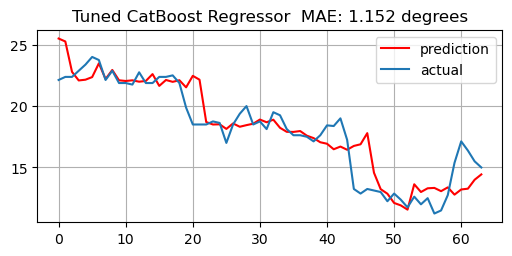

In [ ]:
# joblib.dump(study, 'Study_ts_dali_CatBoost.pkl')    # Сохраним параметры
trial_cb = study.best_trial
cb_model = CatBoostRegressor(**trial_cb.params,       # Обучим модель с лучшими параметрами из подобранных
                              random_seed = RANDOM_SEED,
                              task_type = "CPU",
                              silent = True)
cb_model.fit(X_train, y_train, verbose_eval = 0)
y_prds_cb = cb_model.predict(X_test)

plt.figure(figsize=(6, 2.5))
plt.plot(y_prds_cb, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Tuned CatBoost Regressor  MAE: {mean_absolute_error(y_prds_cb, y_test).round(3)} degrees");

In [ ]:
coef_table = pd.DataFrame({'features' : list(X_train.columns), 'importance' : cb.feature_importances_}).sort_values(by='importance', ascending = False)
display(coef_table)

features  importance
8    month_average   20.383182
0            lag_3   17.748921
1            lag_4   12.442181
4            lag_7   11.321736
3            lag_6   10.718071
2            lag_5    8.789507
6            lag_9    7.934825
5            lag_8    5.971401
9     year_average    2.808518
7  weekday_average    1.881659

### Основные фреймворки для работы с временными рядами   
- ETNA
- Orbit  
- Tsfresh   
- FeatureTools
- Prophet
- SkTime

### ETNA  

Библиотека прогнозирования временных рядов, разработанная компанией Тинькофф. В ней реализовано множество подходов к анализу и прогнозированию временных рядов. Она содержит классические модели прогнозирования, модели из других фреймворков, а также DL-модели.  
В библиотеке ETNA реализованы:    
- Naive Model, Moving Average, Seasonal Moving Average, Holt-Winters
- ARIMA, AutoARIMA, SARIMAX, AutoETS, Prophet           
- Linear Model, CatBoost, Neural Networks и др.

In [4]:
# !pip install etna -q
from etna.datasets.tsdataset import TSDataset
from etna.models import NaiveModel, CatBoostMultiSegmentModel, LinearPerSegmentModel, SARIMAXModel, ProphetModel
from etna.transforms import (STLTransform, LagTransform, MeanSegmentEncoderTransform, LogTransform, MeanTransform, SegmentEncoderTransform, 
                             DateFlagsTransform, LinearTrendTransform, DensityOutliersTransform)
from etna.analysis import plot_forecast, plot_backtest, plot_residuals, acf_plot, get_residuals, plot_anomalies, stl_plot
from etna.analysis.outliers import get_anomalies_density
from etna.pipeline import Pipeline
from etna.metrics import SMAPE, MAE, MSE
from tqdm import tqdm

In [5]:
%config InlinaBackend.figure_format = 'svg'
from pylab import rcParams
rcParams['figure.figsize'] = 7, 5

import warnings
warnings.filterwarnings(action="ignore", message="Torchmetrics v0.9")

##### End-to-end пайнлайн для решения ts-задачи в ETNA

In [6]:
url = "https://drive.google.com/file/d/1vw7qfMwE5jq7x-ErgskpEAcqiSEUP49S/view?usp=share_link"
output = "data.zip"
gdown.download(url=url, output=output, quiet=False, fuzzy=True)
with zipfile.ZipFile("data.zip", "r") as zip_ref:
    zip_ref.extractall("./")
os.remove("data.zip")

Downloading...
From: https://drive.google.com/uc?id=1vw7qfMwE5jq7x-ErgskpEAcqiSEUP49S
To: C:\Users\user\1.My Materials\2.Time Series\data.zip
100%|██████████| 5.77k/5.77k [00:00<00:00, 382kB/s]


In [7]:
NFOLDS = 40
sns.reset_orig()

In [8]:
df = pd.read_csv("data.csv")
df.head()

f_0       f_1       f_2       f_3    target segment   timestamp
0 -0.196658 -0.381908 -0.463617 -1.036998  5.122664    main  2020-01-01
1 -0.649385 -1.220483  0.310150 -1.846336  5.548333    main  2020-01-02
2 -0.962326 -0.975947  1.687106 -2.816835  5.423648    main  2020-01-03
3 -1.219058 -0.493233  2.375747 -4.381200  4.871951    main  2020-01-04
4 -0.865619 -0.900665  0.744983 -4.036739  4.650783    main  2020-01-05

- f_i - time series, которые могут быть использованы для анализа или в качестве признаков в моделях    
- segment - название сегмента для моделирования, в данной задаче принимает единственное значение main    
- target - целевая переменная    
- timestamp - временная шкала

In [9]:
df.isna().sum()

f_0          0
f_1          0
f_2          0
f_3          0
target       1
segment      0
timestamp    0
dtype: int64

In [10]:
df[df.target.isna()]

f_0       f_1       f_2       f_3  target segment   timestamp
99  9.181458 -4.745966  9.210712  9.041758     NaN    main  2020-04-09

f_0         f_1         f_2         f_3     target
count  100.000000  100.000000  100.000000  100.000000  99.000000
mean     3.070329    0.398380    2.118071   -1.127272  16.364582
std      2.263931    2.540592    2.859025    7.245372  15.231086
min     -1.431537   -4.745966   -1.739895  -12.323881   1.345481
25%      1.387638   -1.334088    0.287262   -8.302886   5.748214
50%      2.935997    0.156904    0.872667   -3.003978   9.032371
75%      4.472277    2.443423    3.228293    6.345087  23.057769
max      9.181458    5.043954    9.748184   10.404256  70.780019

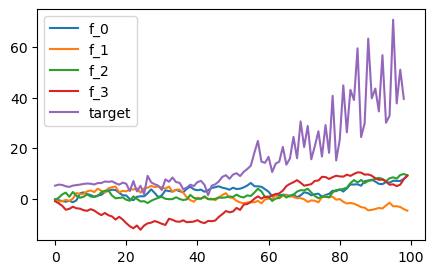

In [11]:
# В целевой переменной присутствует тренд, а также возможно наличие выбросов и периодичности, увеличение дисперсии
# Целевая переменная принимает только положительные значения
display(df.describe())
df.plot(figsize = (5, 3))
plt.show()

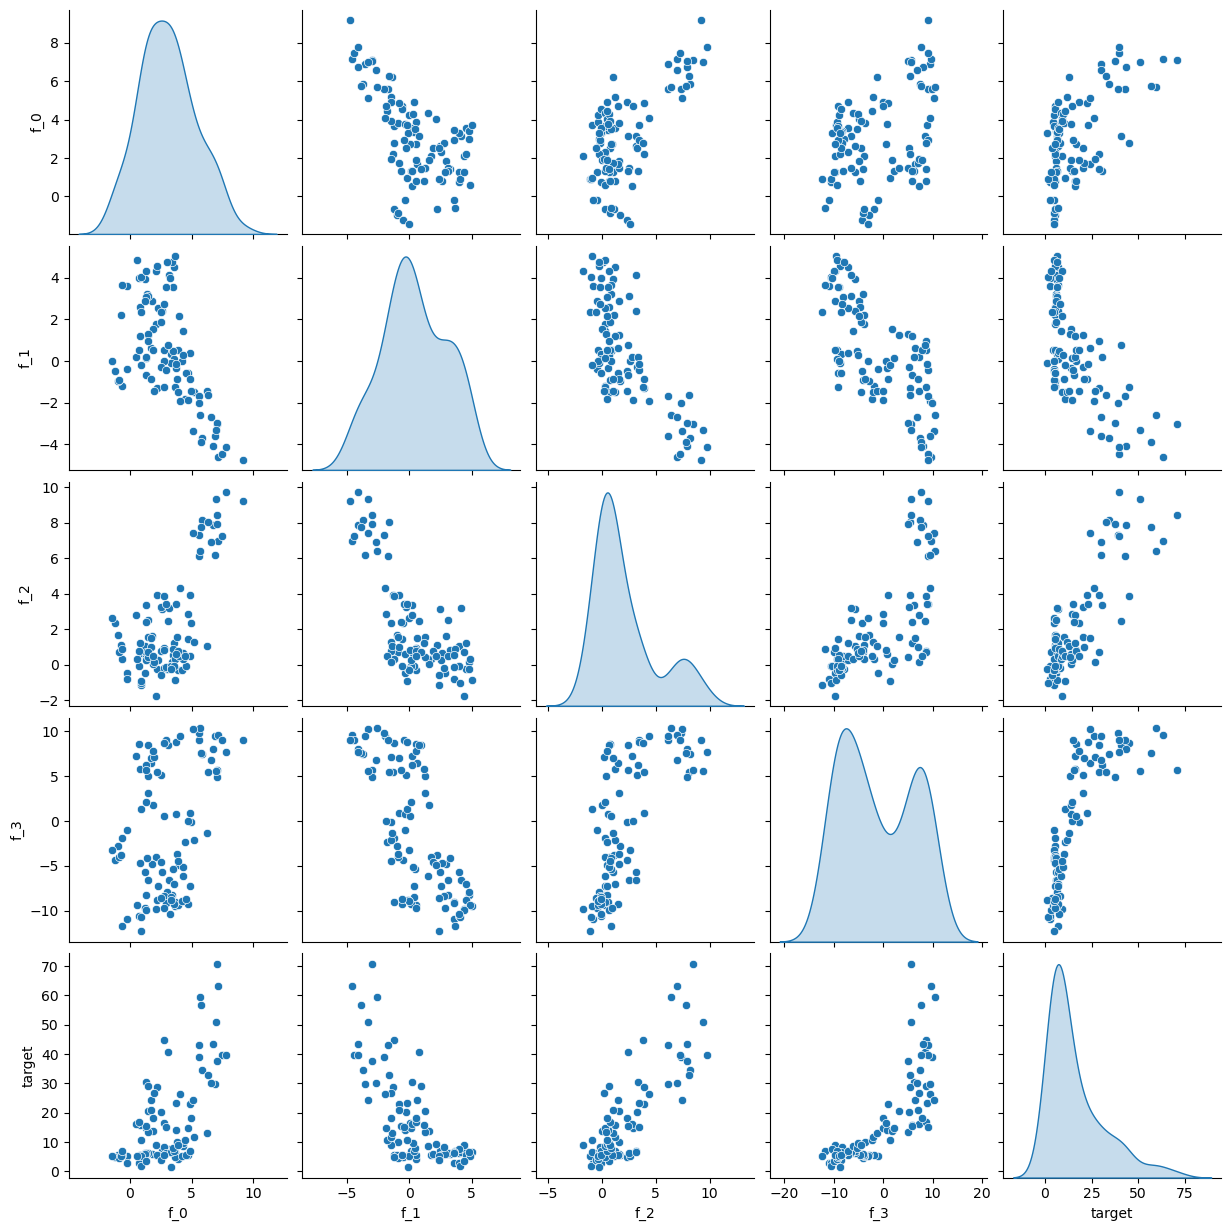

In [12]:
# Изучим совместные распределения рядов
sns.pairplot(df, diag_kind="kde")
plt.show()

Можно отметить наличие корреляции в данных. Посмотрим ближе на данную статистику

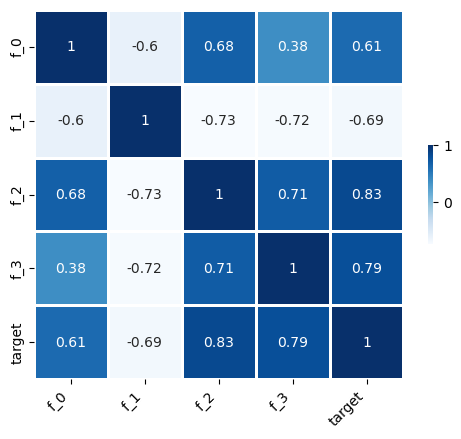

In [735]:
# Отметим наличие линейной зависимости между переменными f_i и target
heatmap = sns.heatmap(df.corr().round(3), annot=True, square=True,
                        cmap="Blues",                      # использовать синюю цветовую карту
                        cbar_kws={"fraction": 0.01},       # боковой колор-бар (shrink colour bar)
                        linewidth=2,                       # пространство между клетками
                        )

heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment="right")
plt.show()

**Формат данных для ETNA**:

* колонка `timestamp` - время в формате datetime
* колонка `target` - целевая переменная (прогнозируемый ряд)
* колонка `segment` - названия целевых столбцов при наличии нескольких прогнозируемых временных рядов, в случае одной целевой переменной - `main`

In [13]:
df_target = TSDataset.to_dataset(df=df[["target", "segment", "timestamp"]])
df_target.dropna(inplace=True)
display(df_target[:3])

df_exog = TSDataset.to_dataset(df=df.drop(columns=["target"]))
display(df_exog[:3])


segment         main
feature       target
timestamp           
2020-01-01  5.122664
2020-01-02  5.548333
2020-01-03  5.423648

segment         main                              
feature          f_0       f_1       f_2       f_3
timestamp                                         
2020-01-01 -0.196658 -0.381908 -0.463617 -1.036998
2020-01-02 -0.649385 -1.220483  0.310150 -1.846336
2020-01-03 -0.962326 -0.975947  1.687106 -2.816835

In [737]:
# Передадим подготовленные данные в конструктор TSDataset
train_ts = TSDataset(df=df_target, df_exog=df_exog, known_future="all", freq="D")
train_ts.head(2)

segment         main                                       
feature          f_0       f_1       f_2       f_3   target
timestamp                                                  
2020-01-01 -0.196658 -0.381908 -0.463617 -1.036998 5.122664
2020-01-02 -0.649385 -1.220483  0.310150 -1.846336 5.548333

In [738]:
train_ts.describe()

start_timestamp end_timestamp  length  num_missing  num_segments  \
segments                                                                    
main          2020-01-01    2020-04-08      99            0             1   

          num_exogs  num_regressors  num_known_future freq  
segments                                                    
main              4               4                 4    D

**Pipeline, Backtest**    
Pipeline позволяет ускорить и упростить обучение и валидацию модели. Разбиение на train и test при запуске кросс валидации в таком случае будет производиться автоматически. Также достоинством использования Pipeline является автоматическое прямое и обратное преобразование данных.     


Параметры Pipeline:    
- model - модель, которая будет обучаться и тестироваться;    
- horizon - горизонт прогнозирования;    
- transforms - список преобразований, которые нужно применить к данным.
  
Кросс валидацию на исторических данных можно запустить при помощи метода **backtest**.

In [739]:
# Базовый пайплайн прогнозирования
pipeline = Pipeline(model=LinearPerSegmentModel())
metrics, forecast, backtest_periods = pipeline.backtest(ts=train_ts, metrics=[MAE(), MSE()], n_folds=NFOLDS, aggregate_metrics=True)

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   6 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  10 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  11 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  13 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  14 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  15 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Do

In [743]:
metrics

segment      MAE        MSE
0    main 7.970842 120.778685

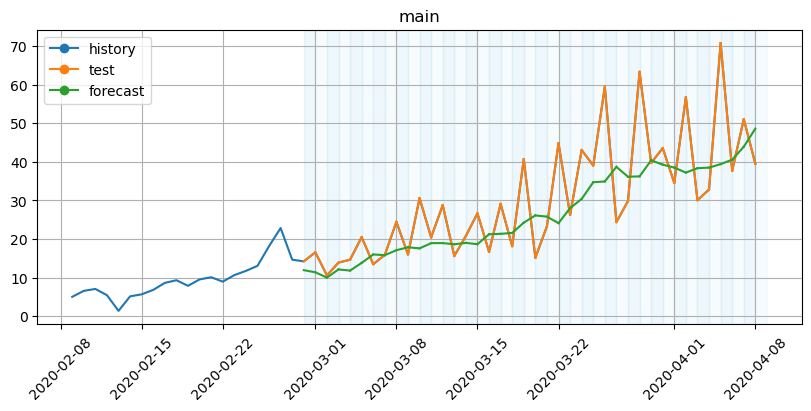

In [746]:
# Результаты бэктеста с помощью plot_backtest
# Модели удалось спрогнозировать общее направление тренда. Однако особенности ряда не учтены
plot_backtest(forecast_df=forecast, ts=train_ts, history_len=20, figsize = (8, 4))
plt.show()

residuals: mean=3.877427011487633, std=10.414203576534836


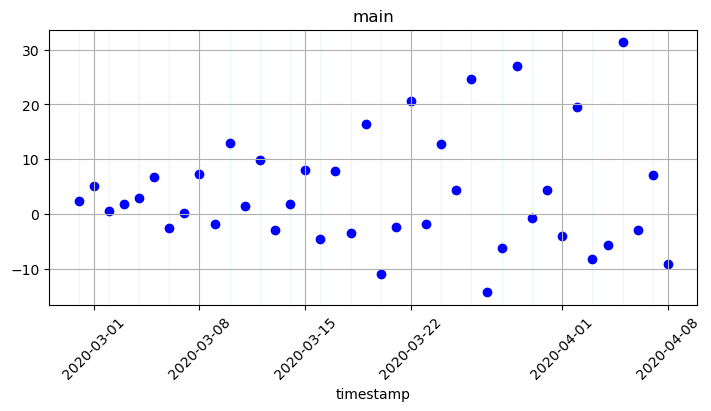

In [749]:
# Остатки прогноза
residuals = get_residuals(forecast_df=forecast, ts=train_ts)
print(f'residuals: mean={residuals[:, :, "target"].mean().item()}, std={residuals[:, :, "target"].std().item()}')
plot_residuals(forecast_df=forecast, ts=train_ts, figsize = (7, 4))
plt.show()

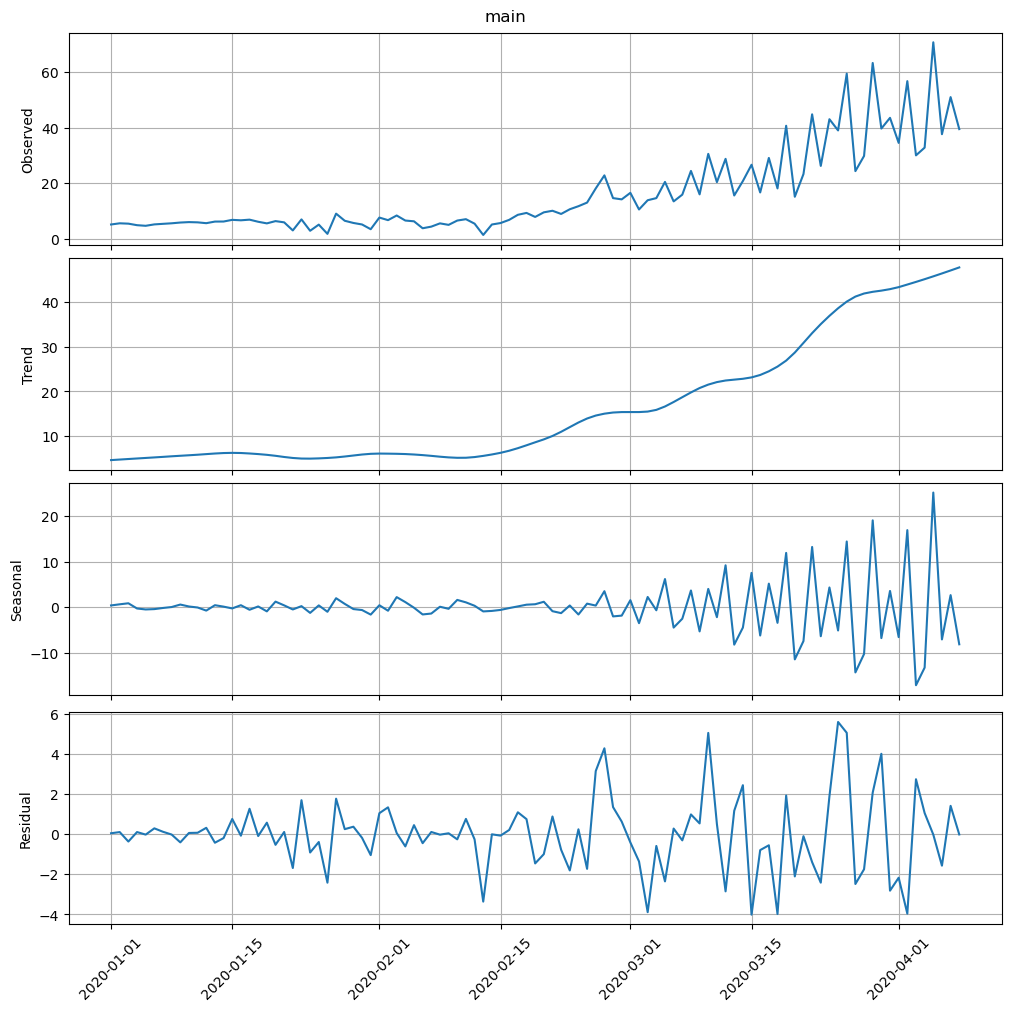

In [756]:
# Моделирование сезонности. Результаты предыдущих моделей могут свидетельствовать о наличии тренда и сезонности
# Для учёта этих эффектов воспользуемся STL декомпозицией (STL – Seasonal and Trend decomposition using LOESS)
# Данный метод позволяет выделить из ряда трендовую и сезонную составляющие 
# Метод работает с различными периодами сезонности, устойчив к выбросам

stl_plot(ts=train_ts, period=7) # график STL разложения, период сезонности 7
plt.show()

LOESS (locally estimated scatterplot smoothing) – непараметрический метод, основанный на обучении полиномиальных регрессий сравнительно невысокой степени на последовательных скользящих окнах. Другими словами, происходит обучение несложных моделей на последовательных подвыборках данных, и точка за точкой конкатенируем получаемые результаты. Таким образом, мы можем выделить основную тенденцию ряда, не делая никаких изначальных предпосылок о данных (другое название – фильтр Савицкого-Голея).

In [758]:
# Добавим STLTransform в пайплайн и построим новую модель
pipeline = Pipeline(transforms=[STLTransform(in_column="target", period=7, model="arima")],
                    model=LinearPerSegmentModel())
metrics, forecast, backtest_periods = pipeline.backtest(ts=train_ts, metrics=[MAE(), MSE()], n_folds=NFOLDS, aggregate_metrics=True)

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   6 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done   8 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  10 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  11 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done  13 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done  14 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done  15 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done  16 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Do

In [759]:
metrics

segment      MAE       MSE
0    main 4.941858 39.395582

Использование STL декомпозиции позволило улучшить качество прогноза

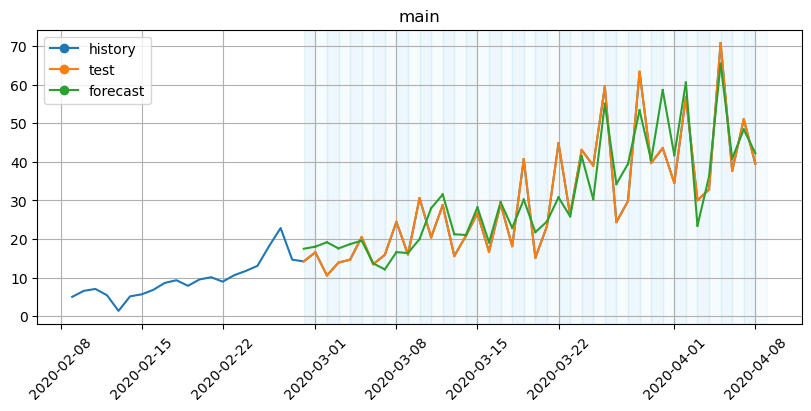

In [765]:
plot_backtest(forecast_df=forecast, ts=train_ts, history_len=20, figsize = (8, 4))
plt.show()

Residuals: mean=-0.5707105815520709, std=6.330218229159325


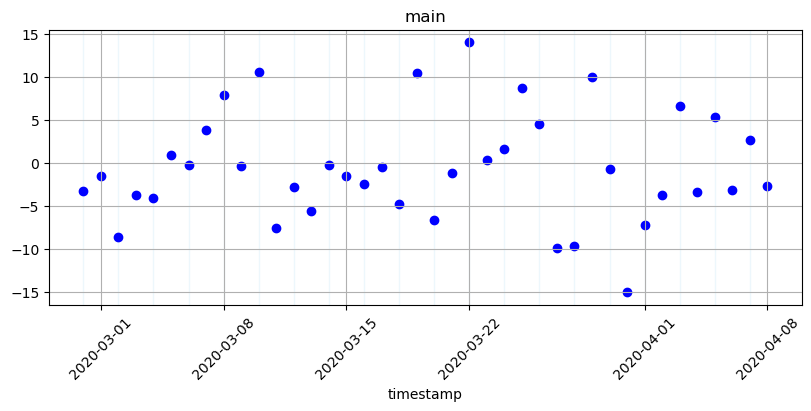

In [768]:
residuals = get_residuals(forecast_df=forecast, ts=train_ts)
print(f'Residuals: mean={residuals[:, :, "target"].mean().item()}, std={residuals[:, :, "target"].std().item()}')
plot_residuals(forecast_df=forecast, ts=train_ts, figsize = (8, 4))
plt.show()

Полученная модель намного лучше учитывает динамику целевой переменной, однако можно заметить несколько выделяющихся наблюдений.

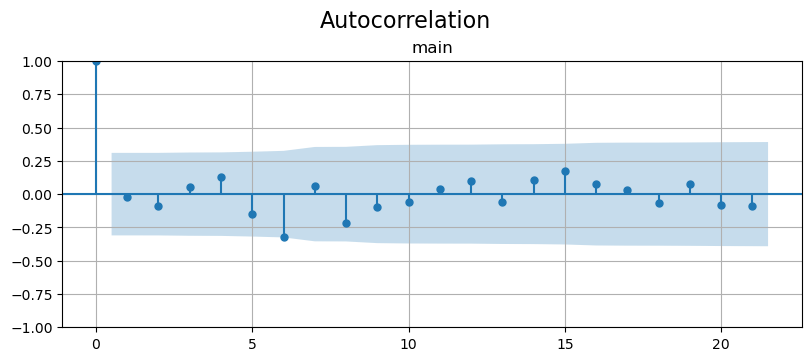

In [782]:
# график автокорреляции остатков
acf_plot(residuals, figsize = (8, 3.5))  # Значимой автокорреляции не наблюдается

Анализ аномалий   
Поиск аномалий в данных осуществляется на основе локальной плотности. В библиотеке ETNA данный метод реализован в функции get_anomalies_density. Преобразование для пайплайна - DensityOutliersTransform.

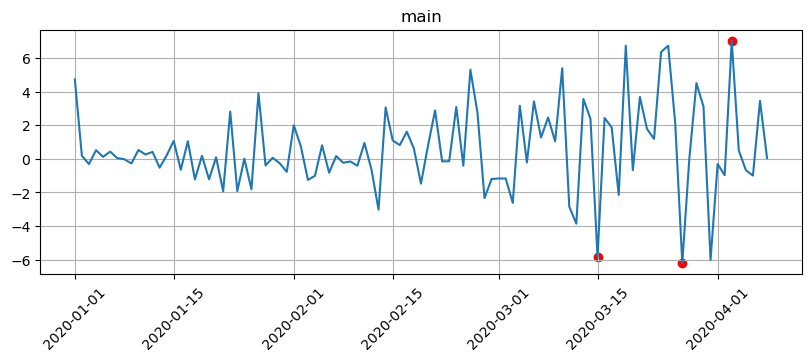

In [779]:
# Посмотрим какие точки были выбраны в качестве выбросов после применения STL декомпозиции
from copy import deepcopy
transformed_train_ts = deepcopy(train_ts)
transformed_train_ts.fit_transform([STLTransform(in_column="target", period=7, model="arima")])

plot_anomalies(ts=transformed_train_ts, anomaly_dict=get_anomalies_density(ts=transformed_train_ts, window_size=5), figsize = (8, 3.5))
plt.show()

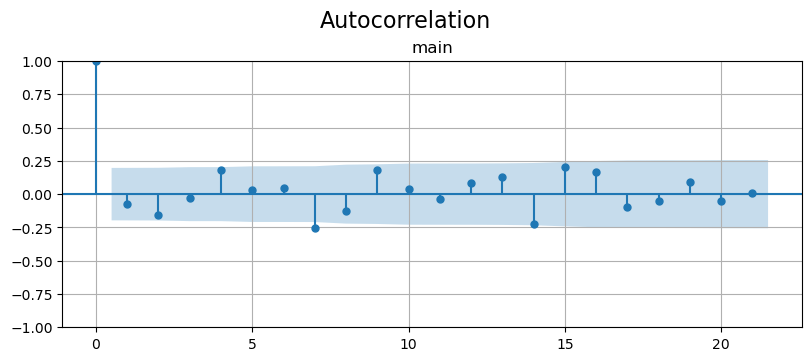

In [781]:
# Проверим отсутствие автокорреляции в данных после преобразования
acf_plot(transformed_train_ts, figsize = (8, 3.5))  # Значимой автокорреляции не наблюдается

In [785]:
# Финальная модель
pipeline = Pipeline(
    transforms=[STLTransform(in_column="target", period=7, model="arima"),
                DensityOutliersTransform(in_column="target", window_size=5)],
    model=LinearPerSegmentModel())
metrics, forecast, backtest_periods = pipeline.backtest(ts=train_ts, metrics=[MAE(), MSE()], n_folds=NFOLDS, aggregate_metrics=True)

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done   6 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done   8 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done   9 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  10 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done  11 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done  13 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done  14 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done  15 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done  16 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Do

segment      MAE       MSE
0    main 4.904237 38.701036

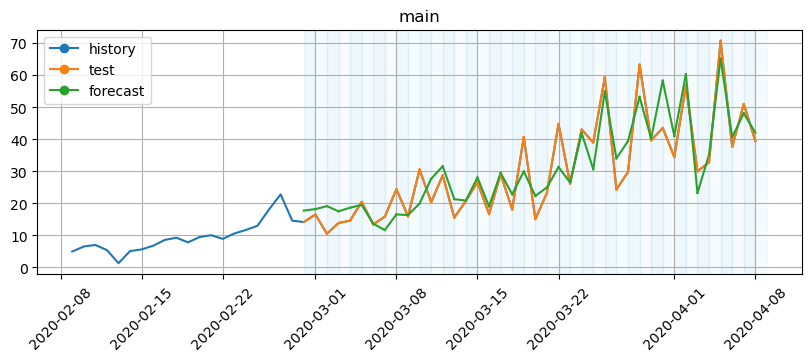

In [792]:
display(metrics)
plot_backtest(forecast_df=forecast, ts=train_ts, history_len=20, figsize = (8, 3.5))
plt.show()

##### Прогнозирование объемов продаж, ETNA

In [93]:
df = pd.read_csv("monthly-australian-wine-sales.csv")
print(df.shape)
df.head(3)

(176, 2)


month  sales
0  1980-01-01  15136
1  1980-02-01  16733
2  1980-03-01  20016

*Приведем данные к формату, с которым работает ETNA*:

* колонка `timestamp` - время в формате datetime
* колонка `target` - целевая переменная (прогнозируемый ряд)
* колонка `segment` - названия целевых столбцов при наличии нескольких прогнозируемых временных рядов, в случае одной целевой переменной - `main`

In [94]:
df["timestamp"] = pd.to_datetime(df["month"])
df["target"] = df["sales"]
df.drop(columns=["month", "sales"], inplace=True)
df["segment"] = "main"
df.head()

timestamp  target segment
0 1980-01-01   15136    main
1 1980-02-01   16733    main
2 1980-03-01   20016    main
3 1980-04-01   17708    main
4 1980-05-01   18019    main

In [95]:
df = TSDataset.to_dataset(df)  # Встроенный в ETNA класс для работы с временными рядами - TSDataset, приведем данные к этому формату
print(df.shape)
print(type(df))
print(df.columns)
df.head(3)

(176, 1)
<class 'pandas.core.frame.DataFrame'>
MultiIndex([('main', 'target')],
           names=['segment', 'feature'])


segment      main
feature    target
timestamp        
1980-01-01  15136
1980-02-01  16733
1980-03-01  20016

In [96]:
# ts = TSDataset(df, freq="1M")
ts = TSDataset(df, freq="MS")   # Укажем временной шаг - частота измерения 
print(type(ts))  
display(ts.head(3))

<class 'etna.datasets.tsdataset.TSDataset'>


segment      main
feature    target
timestamp        
1980-01-01  15136
1980-02-01  16733
1980-03-01  20016

In [97]:
ts.info()

<class 'etna.datasets.TSDataset'>
num_segments: 1
num_exogs: 0
num_regressors: 0
num_known_future: 0
freq: MS
         start_timestamp end_timestamp  length  num_missing
segments                                                   
main          1980-01-01    1994-08-01     176            0


start_timestamp end_timestamp  length  num_missing  num_segments  \
segments                                                                    
main          1980-01-01    1994-08-01     176            0             1   

          num_exogs  num_regressors  num_known_future freq  
segments                                                    
main              0               0                 0   MS

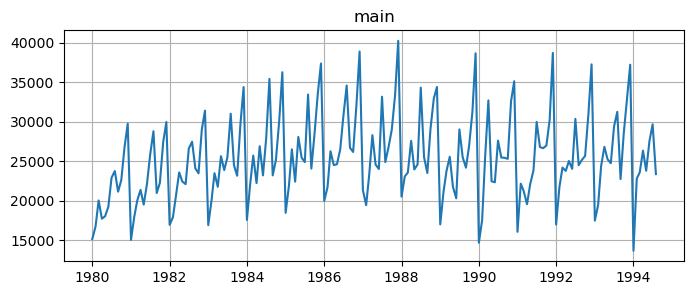

In [98]:
display(ts.describe())
ts.plot(figsize = (8, 3))

In [99]:
# Разбиваем данные на тренировочную и тестовую части встроенной в ETNA train_test_split
train_ts, test_ts = ts.train_test_split(train_start="1980-01-01", train_end="1993-12-01", test_start="1994-01-01", test_end="1994-08-01")

**NaiveModel**

SMAPE: 11.492


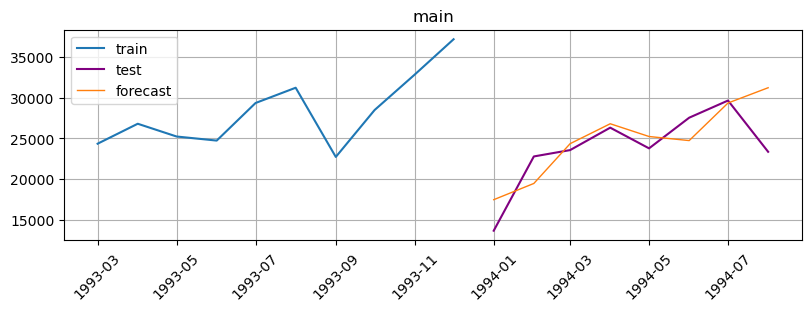

In [100]:
# В библиотеке ETNA реализовано множество различных моделей - от классической SARIMAX до нейронных сетей
# Обучим самую простую модель - NaiveModel. Наивная модель предсказывает текущее значение, равное значению ряда несколько периодов назад (lag)
HORIZON = 8
model = NaiveModel(lag=12).fit(train_ts)   
future_ts = train_ts.make_future(future_steps=HORIZON, tail_steps=model.context_size)
forecast_ts = model.forecast(future_ts, prediction_size=HORIZON)
smape = SMAPE()  
print(f'SMAPE: {round(list(smape(y_true=test_ts, y_pred=forecast_ts).values())[0], 3)}')
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=10, figsize = (8, 3))

**Prophet**

11:04:29 - cmdstanpy - INFO - Chain [1] start processing
11:04:29 - cmdstanpy - INFO - Chain [1] done processing


SMAPE: 10.634


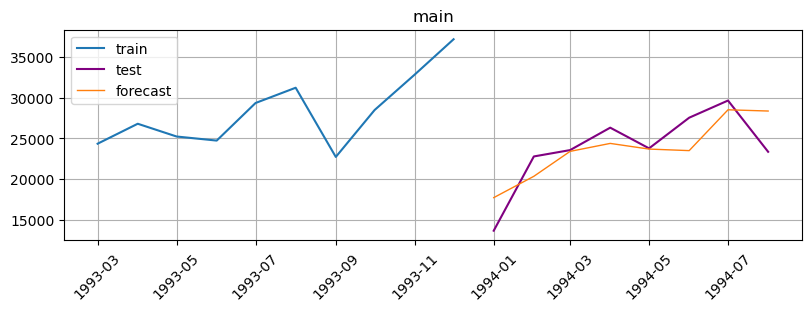

In [101]:
# Propheht использует аддитивную модель временного ряда, состоящего из тренда, сезонности, праздн. эффектов и шумов
model = ProphetModel().fit(train_ts)
future_ts = train_ts.make_future(HORIZON)
forecast_ts = model.forecast(future_ts)
smape = SMAPE()  
print(f'SMAPE: {round(list(smape(y_true=test_ts, y_pred=forecast_ts).values())[0], 3)}')
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=10, figsize = (8, 3))

**Catboost**

SMAPE: 10.657


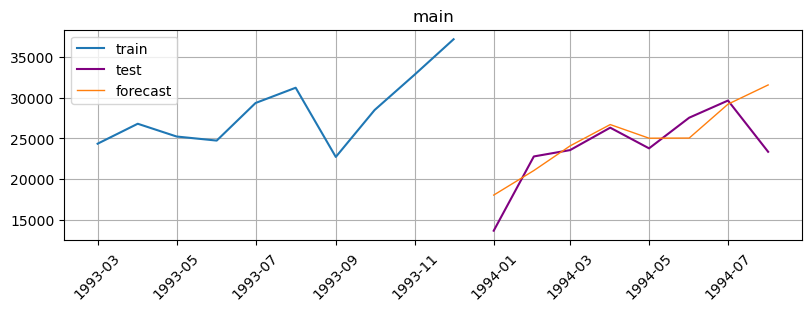

In [109]:
lags = LagTransform(in_column="target", lags=list(range(8, 24, 1)))  # Трансформируем данные. Определим лаги временного ряда
log = LogTransform(in_column="target")                               # Логарифмируетм значения
transforms = [log, lags]
train_ts.fit_transform(transforms)

model = CatBoostMultiSegmentModel().fit(train_ts)
future_ts = train_ts.make_future(future_steps=HORIZON, transforms=transforms)
forecast_ts = model.forecast(future_ts)
forecast_ts.inverse_transform(transforms)
smape = SMAPE()  
print(f'SMAPE: {round(list(smape(y_true=test_ts, y_pred=forecast_ts).values())[0], 3)}')
train_ts.inverse_transform(transforms)
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=10, figsize = (8, 3))

**Multiple time series**

In [159]:
df = pd.read_csv("example_dataset.csv")
print(df.segment.unique())
df

['segment_a' 'segment_b' 'segment_c' 'segment_d']


timestamp    segment  target
0     2019-01-01  segment_a     170
1     2019-01-02  segment_a     243
2     2019-01-03  segment_a     267
3     2019-01-04  segment_a     287
4     2019-01-05  segment_a     279
...          ...        ...     ...
1331  2019-11-26  segment_d     941
1332  2019-11-27  segment_d     949
1333  2019-11-28  segment_d     896
1334  2019-11-29  segment_d     905
1335  2019-11-30  segment_d     721

[1336 rows x 3 columns]

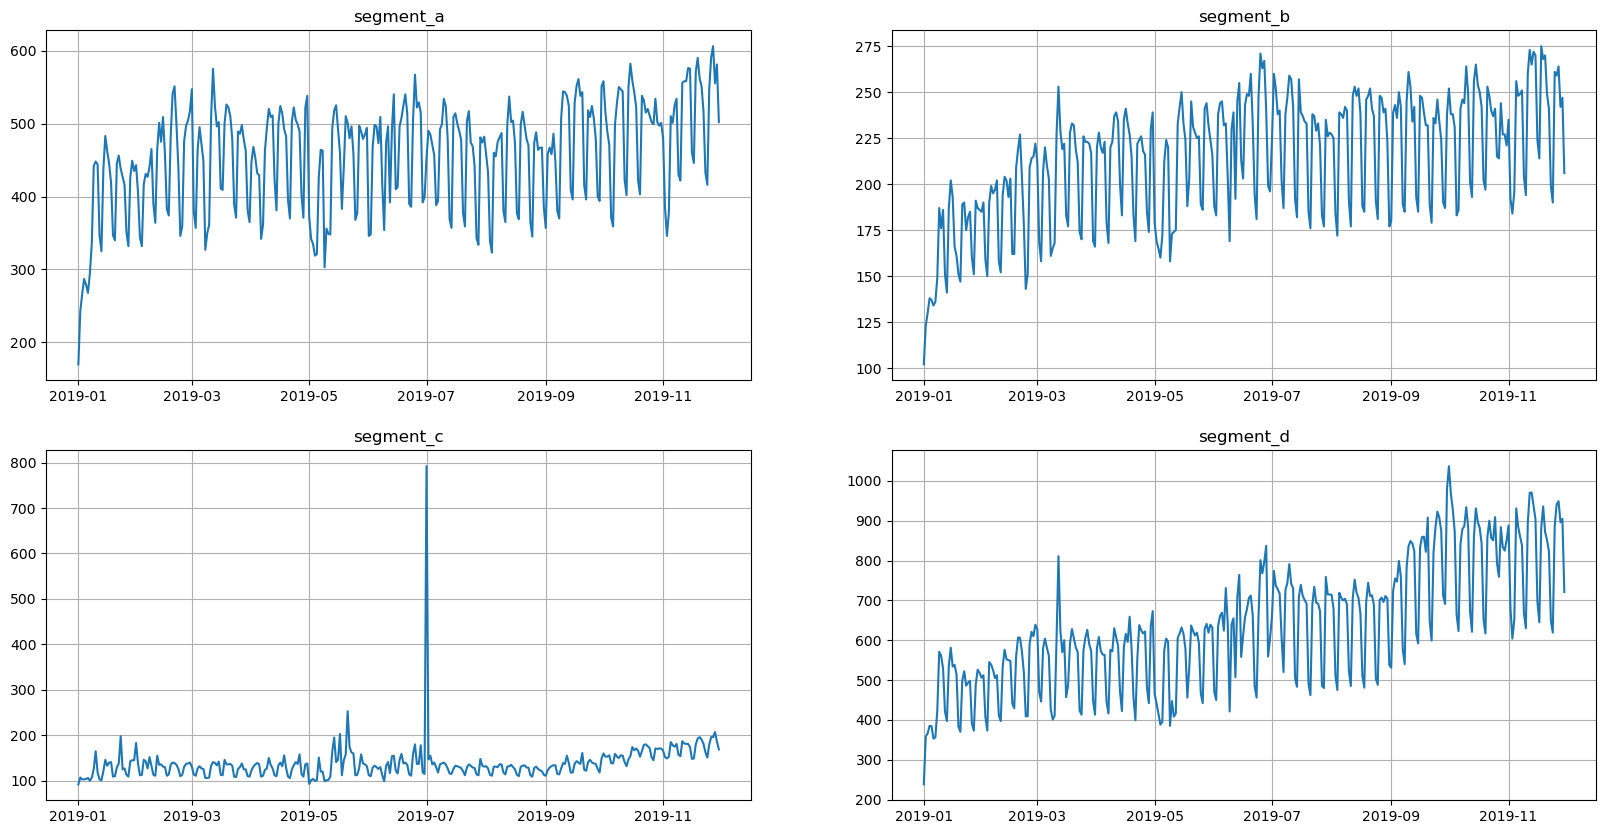

In [160]:
df = TSDataset.to_dataset(df)
ts = TSDataset(df, freq="D")
ts.plot()

In [161]:
display(ts.head(3))

segment    segment_a segment_b segment_c segment_d
feature       target    target    target    target
timestamp                                         
2019-01-01       170       102        92       238
2019-01-02       243       123       107       358
2019-01-03       267       130       103       366

In [162]:
ts.info()

<class 'etna.datasets.TSDataset'>
num_segments: 4
num_exogs: 0
num_regressors: 0
num_known_future: 0
freq: D
          start_timestamp end_timestamp  length  num_missing
segments                                                    
segment_a      2019-01-01    2019-11-30     334            0
segment_b      2019-01-01    2019-11-30     334            0
segment_c      2019-01-01    2019-11-30     334            0
segment_d      2019-01-01    2019-11-30     334            0


In [163]:
log = LogTransform(in_column="target")
trend = LinearTrendTransform(in_column="target")
seg = SegmentEncoderTransform()
lags = LagTransform(in_column="target", lags=list(range(30, 96, 1)))
d_flags = DateFlagsTransform(day_number_in_week=True,
                             day_number_in_month=True,
                             week_number_in_month=True,
                             week_number_in_year=True,
                             month_number_in_year=True,
                             year_number=True,
                             special_days_in_week=[5, 6])
mean30 = MeanTransform(in_column="target", window=30)
transforms = [log, trend, lags, d_flags, seg, mean30]
transforms

[LogTransform(in_column = 'target', base = 10, inplace = True, out_column = None, ),
 LinearTrendTransform(in_column = 'target', poly_degree = 1, ),
 LagTransform(in_column = 'target', lags = [30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95], out_column = None, ),
 DateFlagsTransform(day_number_in_week = True, day_number_in_month = True, day_number_in_year = False, week_number_in_month = True, week_number_in_year = True, month_number_in_year = True, season_number = False, year_number = True, is_weekend = True, special_days_in_week = [5, 6], special_days_in_month = (), out_column = None, in_column = None, ),
 SegmentEncoderTransform(),
 MeanTransform(in_column = 'target', window = 30, seasonality = 1, alpha = 1, min_periods = 1, fillna = 0, out_column = None, )]

In [164]:
HORIZON = 30   
train_ts, test_ts = ts.train_test_split(train_start="2019-01-01", train_end="2019-10-31", test_start="2019-11-01", test_end="2019-11-30")
train_ts.fit_transform(transforms)

In [165]:
train_ts

segment                                                                                                                                                                                                                                                                                                                                                             segment_a  \
feature    DateFlagsTransform(day_number_in_week = False, day_number_in_month = False, day_number_in_year = False, week_number_in_month = False, week_number_in_year = False, month_number_in_year = False, season_number = False, year_number = False, is_weekend = False, special_days_in_week = [5, 6], special_days_in_month = (), out_column = None, in_column = None, )   
timestamp                                                                                                                                                                                                                                                                                                                                                                       
2019-01-01                                              False                                                                                                                                                                                                                                                                                                                   
2019-01-02                                              False                                                                                                                                                                                                                                                                                                                   
2019-01-03                                              False                                                                                                                                                                                                                                                                                                                   
2019-01-04                                              False                                                                                                                                                                                                                                                                                                                   
2019-01-05                                               True                                                                                                                                                                                                                                                                                                                   
...                                                       ...                                                                                                                                                                                                                                                                                                                   
2019-10-27                                               True                                                                                                                                                                                                                                                                                                                   
2019-10-28                                              False                                                                                                                                                                                                                                                         

In [166]:
train_ts.info()

<class 'etna.datasets.TSDataset'>
num_segments: 4
num_exogs: 76
num_regressors: 75
num_known_future: 0
freq: D
          start_timestamp end_timestamp  length  num_missing
segments                                                    
segment_a      2019-01-01    2019-10-31     304            0
segment_b      2019-01-01    2019-10-31     304            0
segment_c      2019-01-01    2019-10-31     304            0
segment_d      2019-01-01    2019-10-31     304            0


In [167]:
test_ts.head()

segment    segment_a segment_b segment_c segment_d
feature       target    target    target    target
timestamp                                         
2019-11-01       480       235       166       888
2019-11-02       384       192       152       680
2019-11-03       346       184       149       604
2019-11-04       378       196       153       652
2019-11-05       510       256       185       931

In [168]:
test_ts.info()

<class 'etna.datasets.TSDataset'>
num_segments: 4
num_exogs: 0
num_regressors: 0
num_known_future: 0
freq: D
          start_timestamp end_timestamp  length  num_missing
segments                                                    
segment_a      2019-11-01    2019-11-30      30            0
segment_b      2019-11-01    2019-11-30      30            0
segment_c      2019-11-01    2019-11-30      30            0
segment_d      2019-11-01    2019-11-30      30            0


In [174]:
model = CatBoostMultiSegmentModel().fit(train_ts)
future_ts = train_ts.make_future(future_steps=HORIZON, transforms=transforms)
forecast_ts = model.forecast(future_ts)
forecast_ts.inverse_transform(transforms)
smape = SMAPE()
smape(y_true=test_ts, y_pred=forecast_ts)

{'segment_a': 5.8968916688777995,
 'segment_b': 4.397964779952168,
 'segment_c': 10.435207629641658,
 'segment_d': 5.085585717990846}

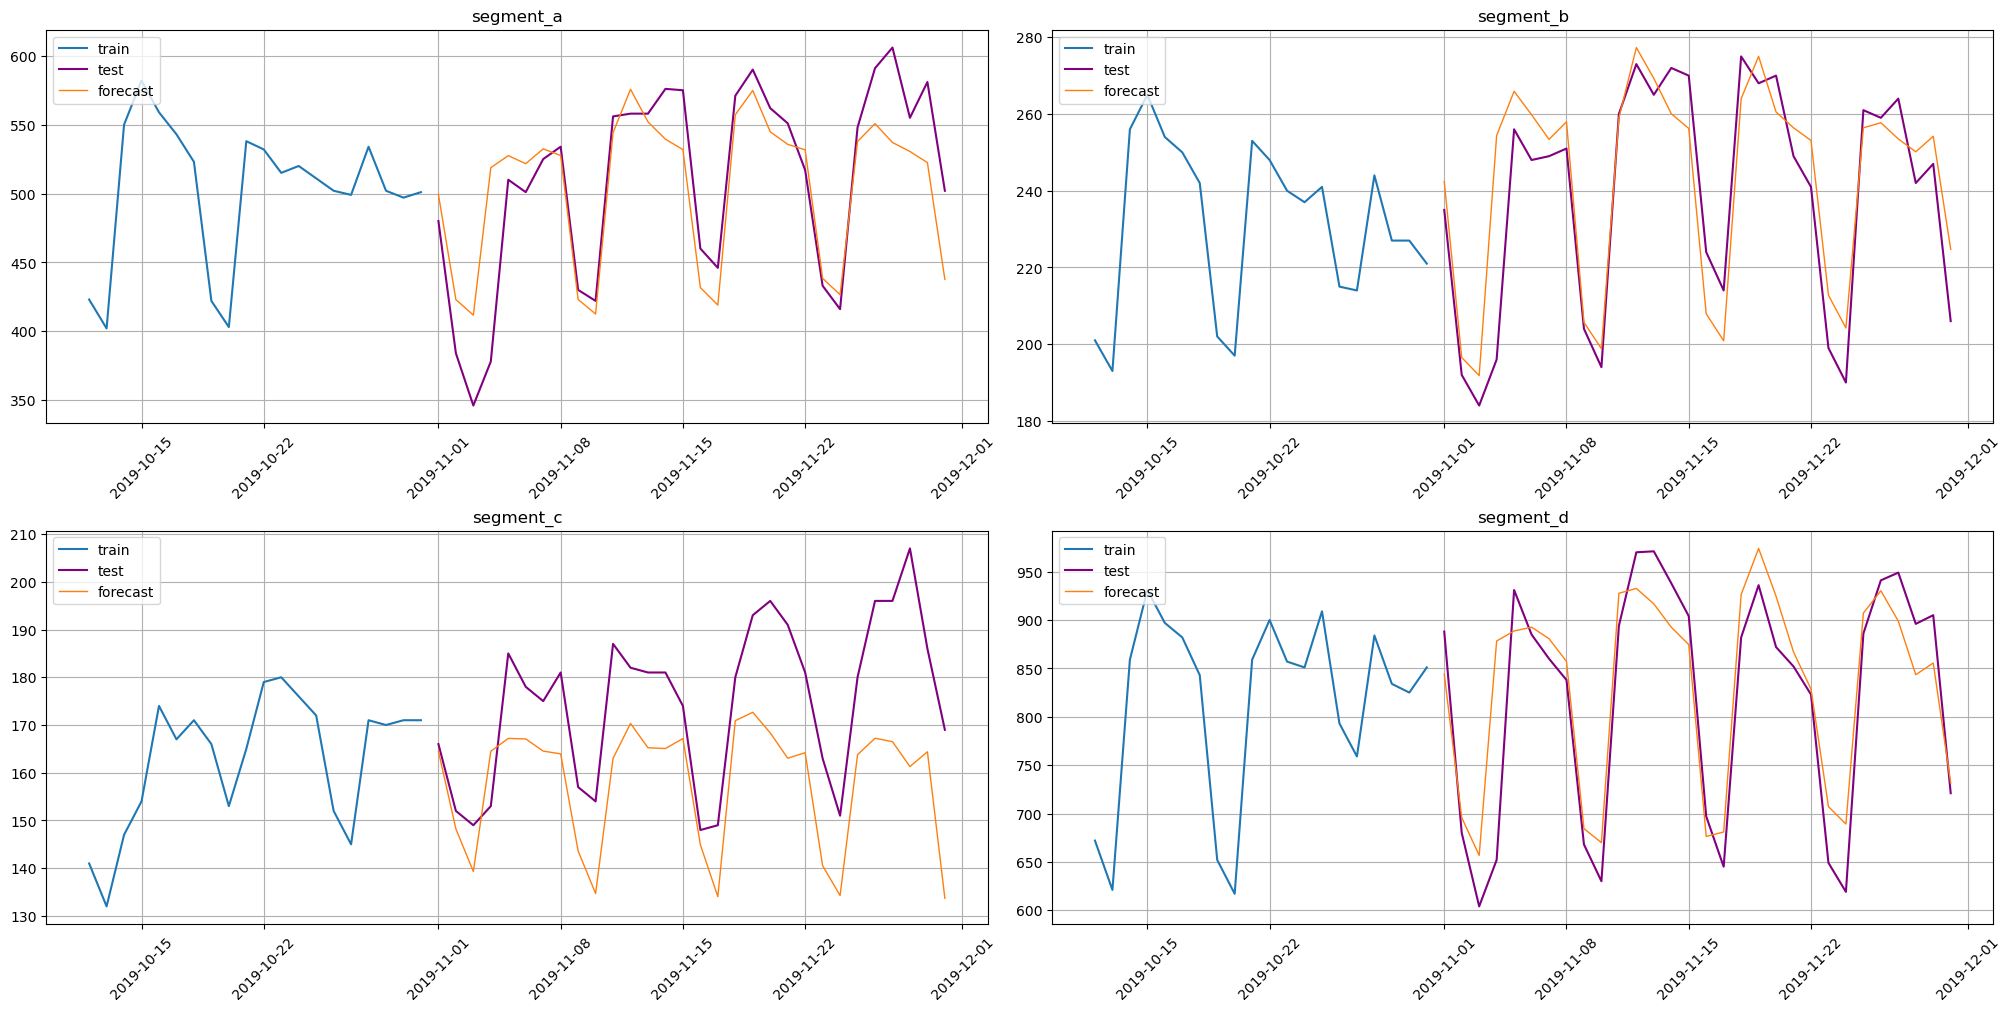

In [175]:
train_ts.inverse_transform(transforms)
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=20)

**Pipeline, Backtest**    

In [177]:
ts.head(3)

segment    segment_a segment_b segment_c segment_d
feature       target    target    target    target
timestamp                                         
2019-01-01       170       102        92       238
2019-01-02       243       123       107       358
2019-01-03       267       130       103       366

In [182]:
print('HORIZON:', HORIZON)
transforms

HORIZON: 30


[LogTransform(in_column = 'target', base = 10, inplace = True, out_column = None, ),
 LinearTrendTransform(in_column = 'target', poly_degree = 1, ),
 LagTransform(in_column = 'target', lags = [30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95], out_column = None, ),
 DateFlagsTransform(day_number_in_week = True, day_number_in_month = True, day_number_in_year = False, week_number_in_month = True, week_number_in_year = True, month_number_in_year = True, season_number = False, year_number = True, is_weekend = True, special_days_in_week = [5, 6], special_days_in_month = (), out_column = None, in_column = None, ),
 SegmentEncoderTransform(),
 MeanTransform(in_column = 'target', window = 30, seasonality = 1, alpha = 1, min_periods = 1, fillna = 0, out_column = None, )]

In [183]:
# Pipeline
train_ts, test_ts = ts.train_test_split(train_start="2019-01-01", train_end="2019-10-31", test_start="2019-11-01", test_end="2019-11-30")

model = Pipeline(model=CatBoostMultiSegmentModel(), transforms=transforms, horizon=HORIZON).fit(train_ts)
forecast_ts = model.forecast()
smape = SMAPE()
smape(y_true=test_ts, y_pred=forecast_ts)

{'segment_a': 5.8968916688777995,
 'segment_b': 4.397964779952168,
 'segment_c': 10.435207629641658,
 'segment_d': 5.085585717990846}

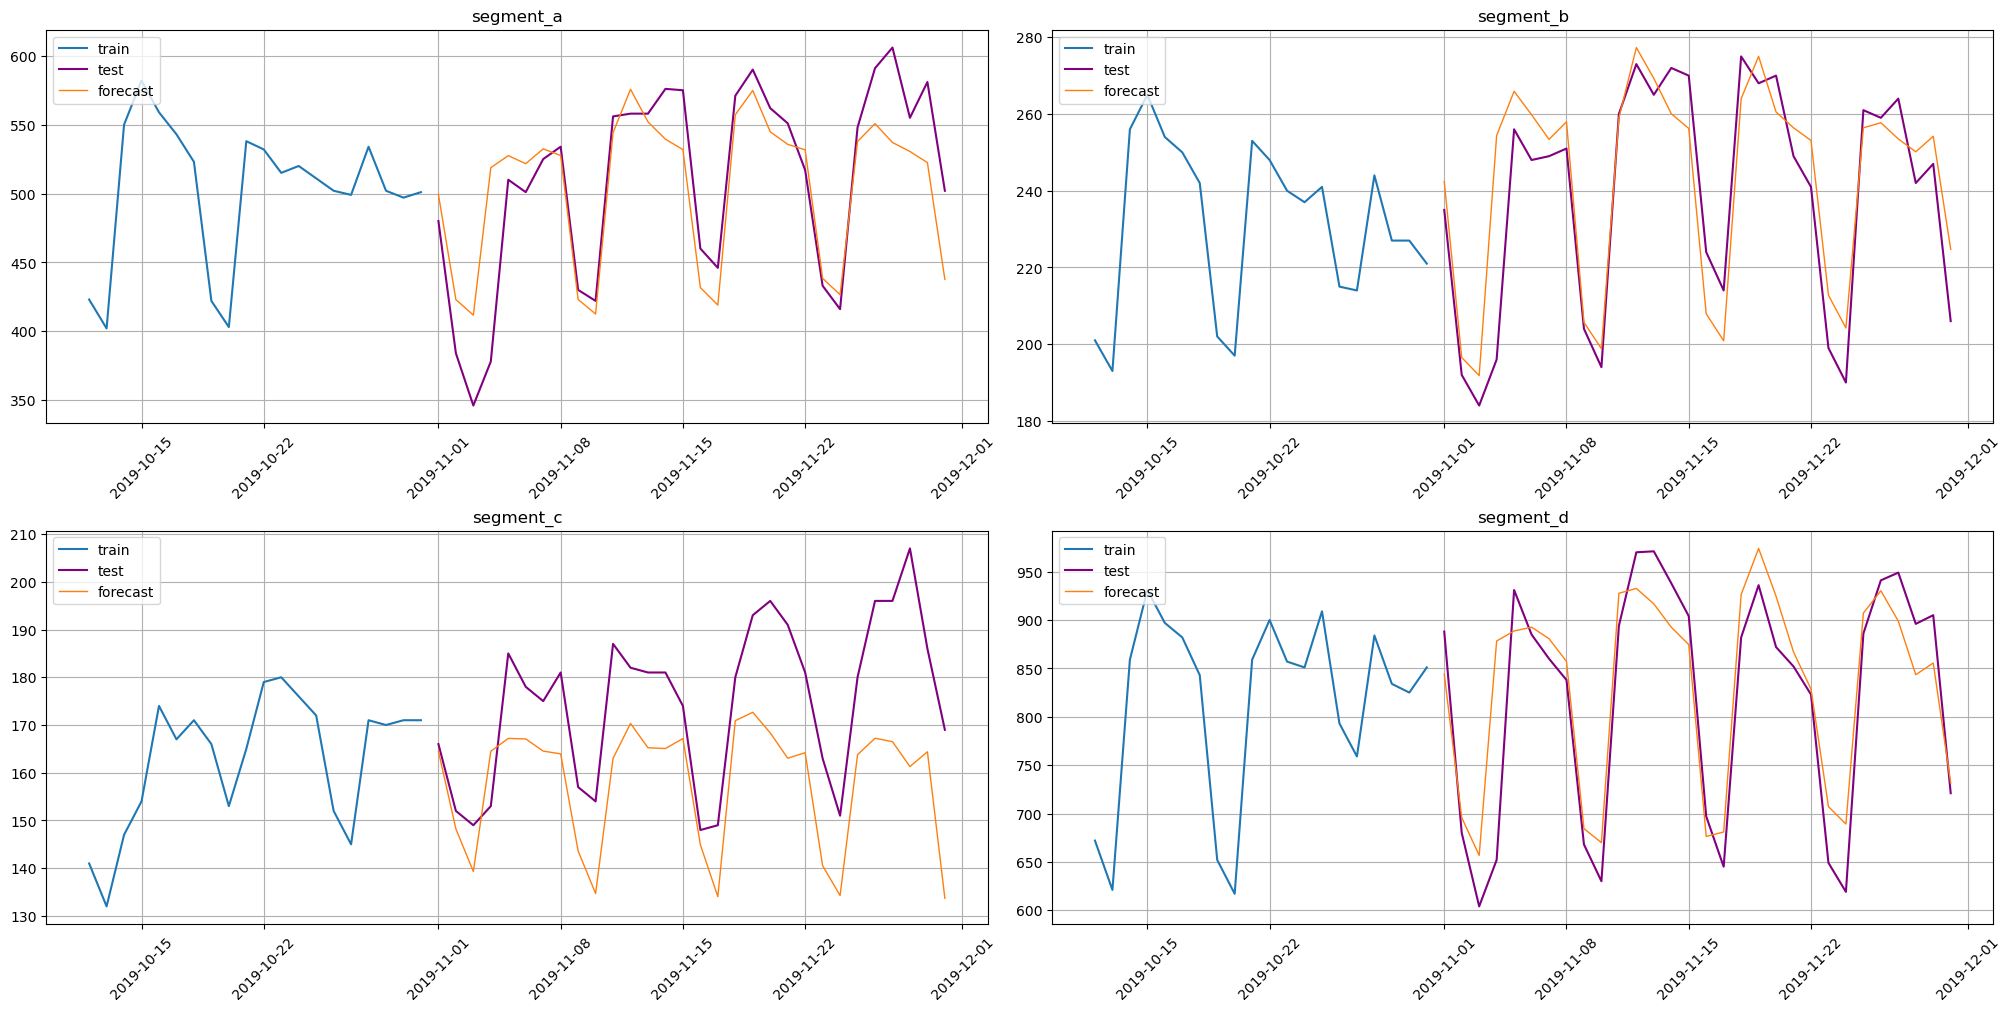

In [184]:
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=20)

##### Прогнозирование среднесуточной дневной температуре в г.Дели, ETNA

In [79]:
df = pd.read_csv('https://raw.githubusercontent.com/aiedu-courses/stepik_applied_tasks/main/datasets/DailyDelhiClimateTrain.csv')
df = df[['date', 'meantemp']]

print(df.shape)
print(df['meantemp'].describe())
display(df[:3])
print(df['date'].agg(['min', 'max']))

(1461, 2)
count    1461.000000
mean       25.506127
std         7.339416
min         6.000000
25%        18.857143
50%        27.714286
75%        31.312500
max        38.714286
Name: meantemp, dtype: float64


date   meantemp
0  2013-01-01  10.000000
1  2013-01-02   7.400000
2  2013-01-03   7.166667

min    2013-01-01
max    2016-12-31
Name: date, dtype: object


*Приведем данные к формату, с которым работает ETNA*:

* колонка `timestamp` - время в формате datetime
* колонка `target` - целевая переменная (прогнозируемый ряд)
* колонка `segment` - названия целевых столбцов при наличии нескольких прогнозируемых временных рядов, в случае одной целевой переменной - `main`

In [ ]:
df['timestamp'] = pd.to_datetime(df['date'])   
df.drop(['date'], axis=1, inplace=True)
df.rename(columns = {'meantemp' : 'target'}, inplace=True)
df['segment'] = 'main'

df = TSDataset.to_dataset(df)       # Встроенный в ETNA класс для работы с временными рядами - TSDataset, приведем данные к нужному формату
ts_df = TSDataset(df, freq = 'D')   # Укажем временной шаг - частота измерения "день"
display(ts_df.head())
display(ts_df.info())

# try:
#     ts = TSDataset(df, freq="D")
#     print("TSDataset успешно создан")
# except Exception as e:
#     print(f"Ошибка при создании TSDataset: {e}")

segment          main
feature        target
timestamp            
2013-01-01  10.000000
2013-01-02   7.400000
2013-01-03   7.166667
2013-01-04   8.666667
2013-01-05   6.000000

<class 'etna.datasets.TSDataset'>
num_segments: 1
num_exogs: 0
num_regressors: 0
num_known_future: 0
freq: D
         start_timestamp end_timestamp  length  num_missing
segments                                                   
main          2013-01-01    2016-12-31    1461            0


None

start_timestamp end_timestamp  length  num_missing  num_segments  \
segments                                                                    
main          2013-01-01    2016-12-31    1461            0             1   

          num_exogs  num_regressors  num_known_future freq  
segments                                                    
main              0               0                 0    D

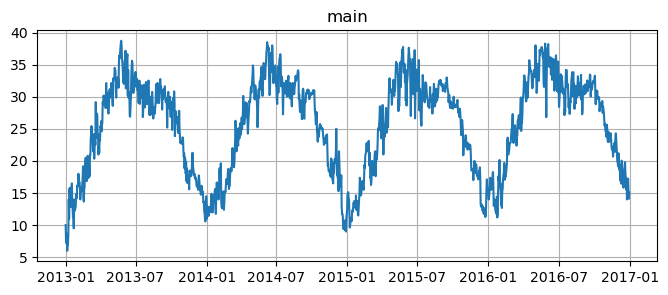

In [ ]:
display(ts_df.describe())
ts_df.plot(figsize = (8, 3))
plt.show()

In [ ]:
# Разбиваем данные на тренировочную и тестовую части встроенной в ETNA train_test_split
train_ts, test_ts = ts_df.train_test_split(train_start="2013-01-01", train_end="2015-12-31", test_start="2016-01-01", test_end="2016-12-31")
display(train_ts.head(3))

segment          main
feature        target
timestamp            
2013-01-01  10.000000
2013-01-02   7.400000
2013-01-03   7.166667

**NaiveModel**

SMAPE: 50.068


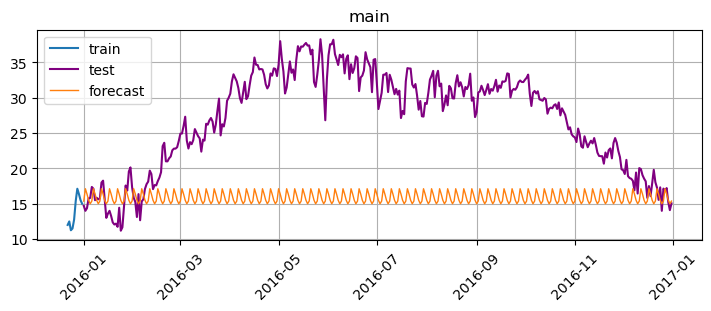

In [ ]:
HORIZON = 366   
model1 = NaiveModel(lag=5)
model1.fit(train_ts)
future_ts = train_ts.make_future(future_steps = HORIZON, tail_steps = model1.context_size)  
forecast_ts = model1.forecast(future_ts, prediction_size = HORIZON)
smape = SMAPE()  
smape_error = smape(y_true = test_ts, y_pred = forecast_ts)
print(f'SMAPE: {round(list(smape_error.values())[0], 3)}')
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples = 10, figsize = (7, 3))  # Результат наивной модели

**Prophet**

20:09:23 - cmdstanpy - INFO - Chain [1] start processing
20:09:23 - cmdstanpy - INFO - Chain [1] done processing


SMAPE: 10.463


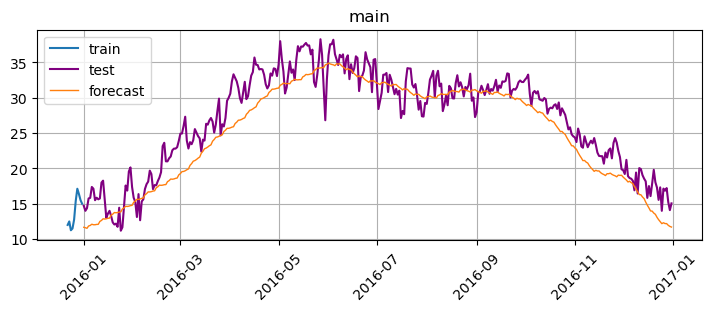

In [ ]:
# Prophet использует аддитивную модель временного ряда, состоящего из тренда, сезонности, праздн. эффектов и шумов
model2 = ProphetModel()
model2.fit(train_ts)
future_ts = train_ts.make_future(HORIZON)
forecast_ts = model2.forecast(future_ts)
smape = SMAPE()
smape_error = smape(y_true = test_ts, y_pred = forecast_ts)
print(f'SMAPE: {round(list(smape_error.values())[0], 3)}')
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples = 10, figsize = (7, 3))

**LinearPerSegmentModel, Pipeline, Backtest**

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/aiedu-courses/stepik_applied_tasks/main/datasets/DailyDelhiClimateTrain.csv')
df = df[['date', 'meantemp']]

# Преобразование данных к формату, с которым работает ETNA, определение временного шага
df['timestamp'] = pd.to_datetime(df['date'])
df.drop(['date'], axis=1, inplace=True)
df.rename(columns = {'meantemp' : 'target'}, inplace=True)
df['segment'] = 'main'

try:
    ts = TSDataset(df, freq="D")
    print("TSDataset успешно создан")
except Exception as e:
    print(f"Ошибка при создании TSDataset: {e}")

# Формирование пайплайна для обучения LinearPerSegmentModel
pipe = Pipeline(transforms = [
                   STLTransform(in_column = 'target', period = 7, model = 'arima'),  # Выделяем тренд, сезонность и шумовую компоненту при помощи ARIMA
                   LagTransform(in_column = 'target', lags = list(range(3, 10, 1))), # Выделяем лаговые признаки, начиная с лага 3 и до 10
                  ],
                model = LinearPerSegmentModel(),  # Используем линейную модель с горизонтом прогнозирования 3. Прогнозируем ряд на три периода вперед
                horizon = 3)
# Кросс-валидация на временных рядах
metrics, forecast, backtest_periods = pipe.backtest(ts = ts, metrics = [MAE(), SMAPE()], n_folds = 5)

TSDataset успешно создан


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    2.9s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    3.6s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    3.6s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    2.6s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    3.6s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    4.5s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    4.5s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

In [ ]:
print(pipe)

Pipeline(model = LinearPerSegmentModel(fit_intercept = True, ), transforms = [STLTransform(in_column = 'target', period = 7, model = 'arima', robust = False, model_kwargs = None, stl_kwargs = None, ), LagTransform(in_column = 'target', lags = [3, 4, 5, 6, 7, 8, 9], out_column = None, )], horizon = 3, )


In [ ]:
metrics

segment       MAE      SMAPE  fold_number
0    main  0.956865   5.492141            0
0    main  1.679161   9.454322            1
0    main  1.986150  12.403313            2
0    main  0.500228   2.888707            3
0    main  0.352171   2.309867            4

In [ ]:
backtest_periods

train_start_time train_end_time test_start_time test_end_time  fold_number
0       2013-01-01     2016-12-16      2016-12-17    2016-12-19            0
1       2013-01-01     2016-12-19      2016-12-20    2016-12-22            1
2       2013-01-01     2016-12-22      2016-12-23    2016-12-25            2
3       2013-01-01     2016-12-25      2016-12-26    2016-12-28            3
4       2013-01-01     2016-12-28      2016-12-29    2016-12-31            4

In [ ]:
df.timestamp.agg(['min', 'max'])

min   2013-01-01
max   2016-12-31
Name: timestamp, dtype: datetime64[ns]

In [ ]:
print(forecast.shape)
forecast

(15, 9)


segment                                                                   main  \
feature    LagTransform(in_column = 'target', lags = [3], out_column = None, )   
timestamp                                                                        
2016-12-17                                          -0.072020                    
2016-12-18                                           0.242676                    
2016-12-19                                          -1.740735                    
2016-12-20                                           0.891218                    
2016-12-21                                          -1.451009                    
2016-12-22                                           0.111875                    
2016-12-23                                           1.036520                    
2016-12-24                                          -0.464254                    
2016-12-25                                          -0.300411                    
2016-12-26                                          -0.050624                    
2016-12-27                                           0.463926                    
2016-12-28                                          -1.323686                    
2016-12-29                                          -0.056361                    
2016-12-30                                          -0.927380                    
2016-12-31                                           0.399825                    

segment                                                                         \
feature    LagTransform(in_column = 'target', lags = [4], out_column = None, )   
timestamp                                                                        
2016-12-17                                          -0.400106                    
2016-12-18                                          -0.072020                    
2016-12-19                                           0.242676                    
2016-12-20                                          -1.876787                    
2016-12-21                                           0.891218                    
2016-12-22                                          -1.451009                    
2016-12-23                                           0.219093                    
2016-12-24                                           1.036520                    
2016-12-25                                          -0.464254                    
2016-12-26                                          -0.283752                    
2016-12-27                                          -0.050624                    
2016-12-28                                           0.463926                    
2016-12-29                                          -1.418493                    
2016-12-30                                          -0.056361                    
2016-12-31                                          -0.927380                    

segment                                                                         \
feature    LagTransform(in_column = 'target', lags = [5], out_column = None, )   
timestamp                                                                        
2016-12-17                                           0.380579                    
2016-12-18                                          -0.400106                    
2016-12-19                                          -0.072020                    
2016-12-20                                           0.116817                    
2016-12-21                                          -1.876787                    
2016-12-22                                           0.891218                    
2016-12-23                                          -1.360038                    
2016-12-24                                           0.219093                    
2016-12-25                                           1.036520                    
2016-12-26                                          -0.443490 

In [ ]:
mae_value = metrics.mean().to_dict()['MAE']
smape_value = metrics.mean().to_dict()['SMAPE']
print(f'MAE: {round(mae_value, 3)}  SMAPE: {round(smape_value, 3)}')  # MAE: 1.095  SMAPE: 6.51

MAE: 1.095  SMAPE: 6.51


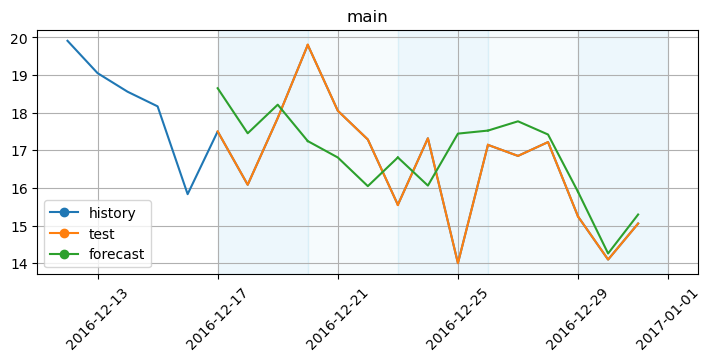

In [ ]:
plot_backtest(forecast_df = forecast, ts = ts, history_len = 5, figsize = (7, 3.5))

**CatBoostMultiSegmentModel, Pipeline, Backtest**

In [ ]:
# Формирование пайплайна для обучения CatBoostMultiSegmentModel
pipe2 = Pipeline(transforms = [STLTransform(in_column = 'target', period = 7, model = 'arima'),
                               LagTransform(in_column = 'target', lags = list(range(3, 10, 1)))],
                model = CatBoostMultiSegmentModel(n_estimators = 1000, learning_rate = 0.01),
                horizon = 3)
# Кросс-валидация на временных рядах
metrics2, forecast2, backtest_periods2 = pipe2.backtest(ts = ts,  metrics = [MAE(), SMAPE()],  n_folds=5)
metrics2

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    3.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    6.7s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    9.8s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:   14.1s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:   18.8s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:   18.8s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    2.5s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    4.3s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    4.3s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

segment       MAE      SMAPE  fold_number
0    main  0.606679   3.509500            0
0    main  1.688889   9.534459            1
0    main  2.000959  12.491365            2
0    main  0.399407   2.309858            3
0    main  0.238378   1.558969            4

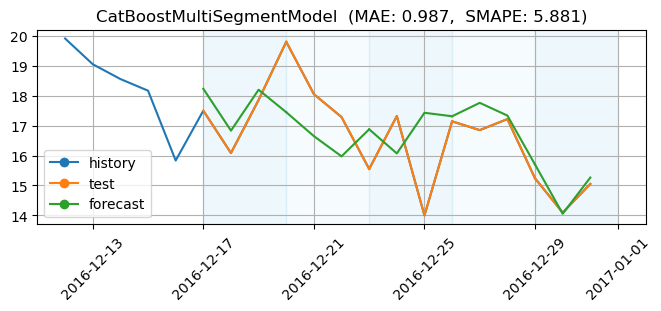

In [ ]:
# Результат модели CatBoostMultiSegmentModel
mae_value2 = metrics2.mean().to_dict()['MAE']
smape_value2 = metrics2.mean().to_dict()['SMAPE']

plot_backtest(forecast_df = forecast2, ts=ts, history_len = 5, figsize = (6.5, 3))
plt.title(f'CatBoostMultiSegmentModel  (MAE: {round(mae_value2, 3)},  SMAPE: {round(smape_value2, 3)})')
plt.show()

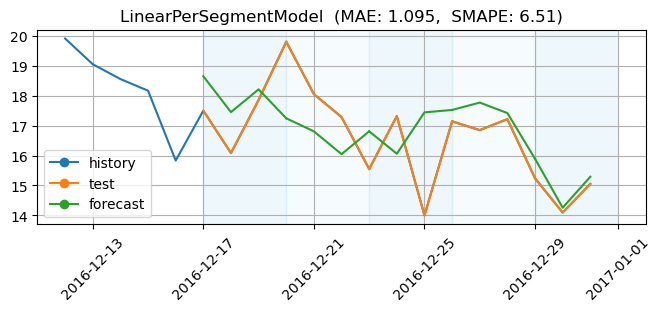

In [ ]:
# Результат модели LinearPerSegmentModel
plot_backtest(forecast_df = forecast, ts=ts, history_len = 5, figsize = (6.5, 3))
plt.title(f'LinearPerSegmentModel  (MAE: {round(mae_value, 3)},  SMAPE: {round(smape_value, 3)})')
plt.show()

### ORBIT

Библиотека прогнозирования временных рядов, разработанная компанией Uber, предоставляет набор инструментов для создания и обучения моделей. В библиотеке реализовано множество алгоритмов, среди которых представители экспоненциального семейства моделей (DLT, ETS, LGT):    
1. Damped Local Trend (DLT) - модель, учитывающая динамику тренда и сезонности в данных временных рядов. Она представляет собой динамическую линейную модель, которая применяется к временным рядам с общим трендом и сезонностью. DLT модель автоматически определяет оптимальное количество сезонных компонентов и динамически обновляет параметры модели во время прогнозирования.    
    Основные компоненты DLT модели:
    - Глобальный тренд: линейный тренд, который меняется с течением времени.   
    - Сезонные компоненты: ряд компонентов, которые повторяются с фиксированной периодичностью (например, сезонность по месяцам).   
    - Ошибка: случайные изменения, которые не объясняются трендом или сезонностью и рассматриваются как случайные шумы.    
2. Local Global Trend (LGT) - расширение DLT модели, которое добавляет локальные составляющие для более гибкого учета локальных аномалий или событий, которые могут повлиять на временной ряд. LGT модель способна автоматически обнаруживать и адаптироваться к локальным изменениям тренда в данных временных рядов.      
    Основные компоненты LGT модели:   
    - Глобальный тренд: линейный тренд, который меняется с течением времени.   
    - Локальный тренд: линейный тренд, который изменяется в зависимости от обнаруженных локальных аномалий или событий.   
    - Сезонные компоненты: ряд компонентов, которые повторяются с фиксированной периодичностью (например, сезонность по месяцам).   
    - Ошибка: случайные изменения, которые не объясняются глобальным и локальным трендом или сезонностью и рассматриваются как случайные шумы.   
    Обе модели DLT и LGT предоставляют простой и эффективный способ анализа и прогнозирования временных рядов с динамическими трендами и сезонностью, а также учета локальных изменений и аномалий в данных.    
3. Exponential Smoothing (ETS)    
4. Kernel-based Time-varying Regression (KTR) и др.

In [ ]:
# !pip install orbit-ml -q
import orbit
from orbit.utils.dataset import load_iclaims
from orbit.models import ETS, DLT, LGT
from orbit.diagnostics.plot import plot_predicted_data

In [ ]:
df = load_iclaims()
date_col = 'week'
response_col = 'claims'
print(df.shape)
df[:3]

(443, 7)


week     claims  trend.unemploy  trend.filling  trend.job     sp500  \
0 2010-01-03  13.386595        0.219882      -0.318452   0.117500 -0.417633   
1 2010-01-10  13.624218        0.219882      -0.194838   0.168794 -0.425480   
2 2010-01-17  13.398741        0.236143      -0.292477   0.117500 -0.465229   

        vix  
0  0.122654  
1  0.110445  
2  0.532339

In [ ]:
df.dtypes

week              datetime64[ns]
claims                   float64
trend.unemploy           float64
trend.filling            float64
trend.job                float64
sp500                    float64
vix                      float64
dtype: object

In [ ]:
test_size = 52
train_df = df[:-test_size]
test_df = df[-test_size:]

##### ETS - Exponential Smoothing

In [ ]:
ets = ETS(response_col = response_col, date_col = date_col, seasonality = 52, seed = 8888)
ets.fit(df = train_df)
predicted_df1 = ets.predict(df=test_df)

print(predicted_df1.shape)
display(predicted_df1.head(3))
print('MAE:', round(mean_absolute_error(test_df[response_col], predicted_df1['prediction']), 3))

2025-03-25 09:33:06 - orbit - INFO - Sampling (CmdStanPy) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (CmdStanPy) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

                                                                                                                                                                                                                                                                                                                                                                                                                
(52, 4)


week  prediction_5  prediction  prediction_95
0 2017-07-02     12.273798   12.434343      12.585723
1 2017-07-09     12.403464   12.558639      12.708553
2 2017-07-16     12.266126   12.402713      12.548568


MAE: 0.064


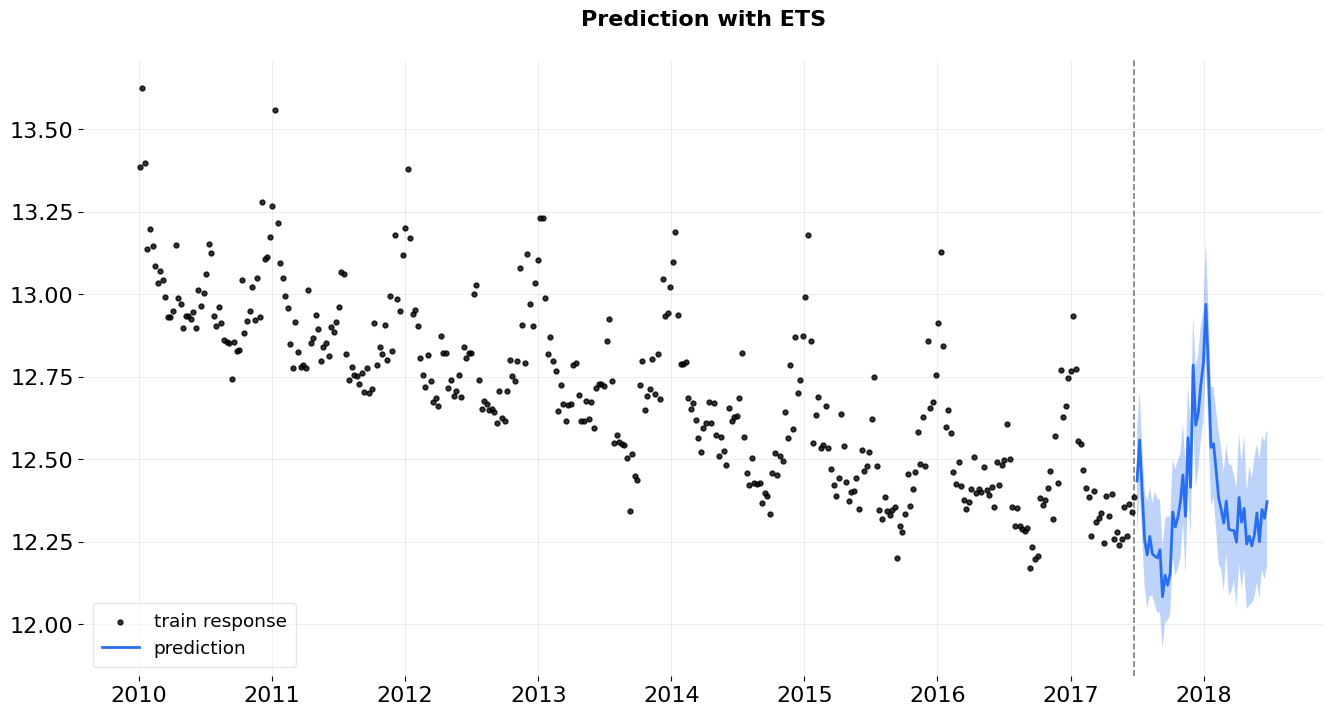

In [ ]:
pl = plot_predicted_data(train_df, predicted_df1, date_col, response_col, title='Prediction with ETS')

##### DLT - Damped Local Trend

In [ ]:
dlt = DLT(response_col = response_col, date_col = date_col, seasonality = 52, seed = 8888,
          estimator = 'stan-map', global_trend_option = 'linear', n_bootstrap_draws = 1000)
dlt.fit(df = train_df)
predicted_dlt_df = dlt.predict(df = test_df)

print(predicted_dlt_df.shape)
display(predicted_dlt_df.head(3))
print('MAE:', round(mean_absolute_error(test_df[response_col], predicted_dlt_df['prediction']), 3))

2025-03-25 09:43:26 - orbit - INFO - Optimizing (CmdStanPy) with algorithm: LBFGS.
INFO:orbit:Optimizing (CmdStanPy) with algorithm: LBFGS.


(52, 4)


week  prediction_5  prediction  prediction_95
0 2017-07-02     12.342564   12.425799      12.507144
1 2017-07-09     12.460336   12.545942      12.629393
2 2017-07-16     12.296962   12.382584      12.464478

MAE: 0.043


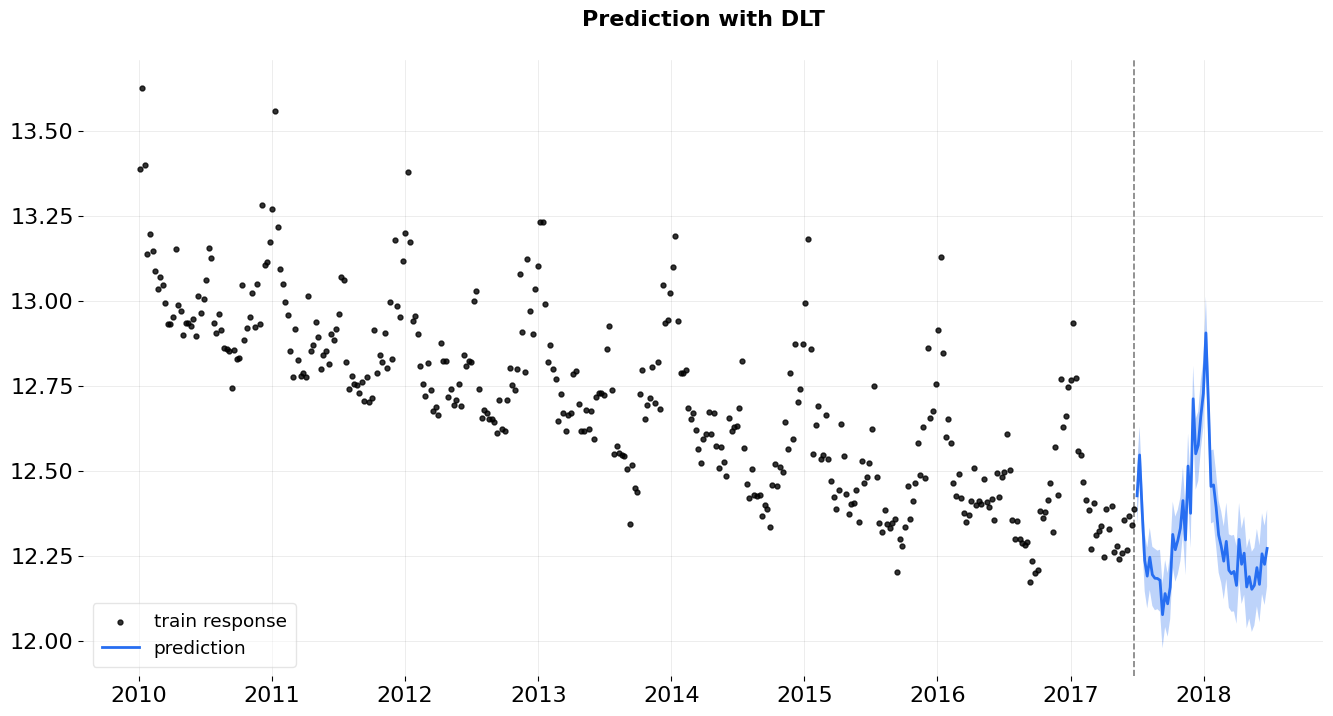

In [ ]:
pl = plot_predicted_data(train_df, predicted_dlt_df, date_col, response_col, title='Prediction with DLT')

##### LGT - Local Global Trend

In [ ]:
lgt = LGT(response_col=response_col, date_col=date_col, estimator='stan-map', seasonality=52, seed=8888)
lgt.fit(df=train_df)
predicted_lgt_df = lgt.predict(df=test_df)

print(predicted_lgt_df.shape)
display(predicted_lgt_df.head(3))
print('MAE:', round(mean_absolute_error(test_df[response_col], predicted_lgt_df['prediction']), 3))

2025-03-25 09:46:22 - orbit - INFO - Optimizing (CmdStanPy) with algorithm: LBFGS.
INFO:orbit:Optimizing (CmdStanPy) with algorithm: LBFGS.


(52, 2)


week  prediction
0 2017-07-02   12.416124
1 2017-07-09   12.533705
2 2017-07-16   12.374707


MAE: 0.046


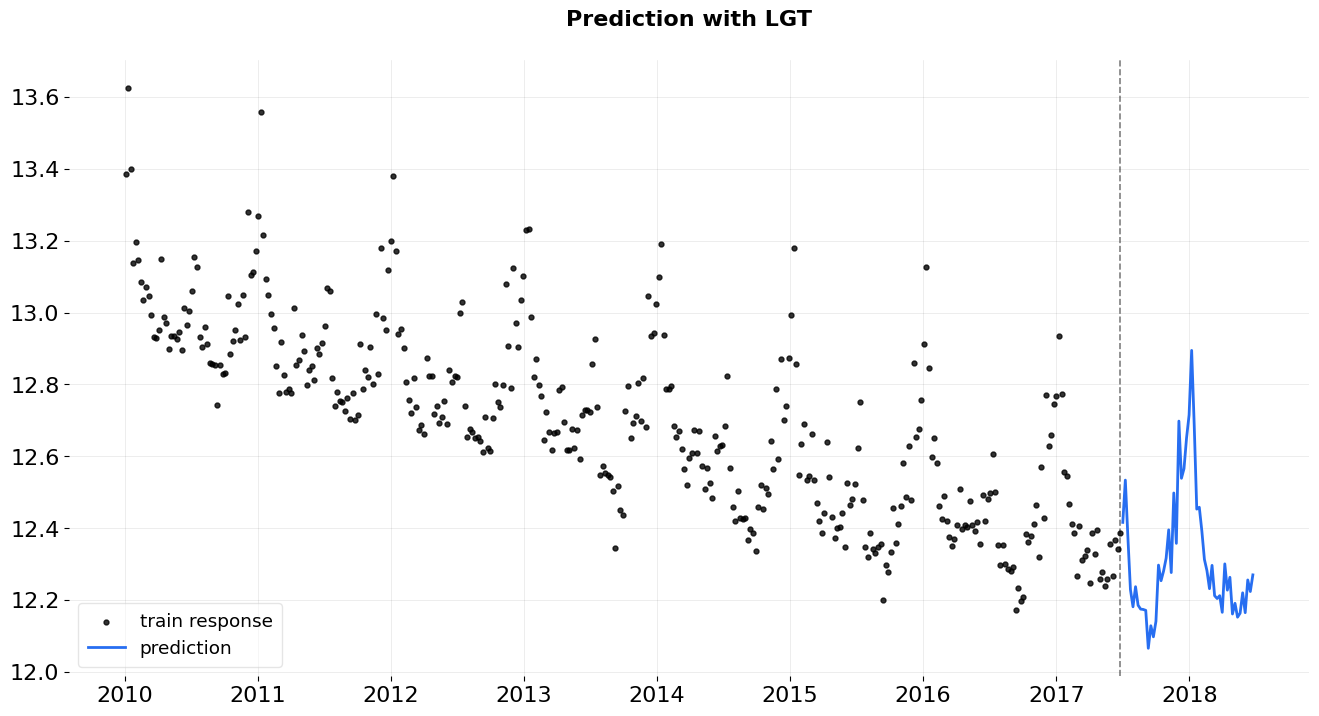

In [ ]:
pl = plot_predicted_data(train_df, predicted_lgt_df, date_col, response_col, title='Prediction with LGT');

##### Посмотрим на результат трех моделей (DLT, LGT и SARIMAX) с экзогенными признаками в задаче прогнозирвания количества проданного товара в Индии

In [ ]:
# Прогнозирование количества проданного товара в городе Бангалор, Индия (таргет - quantity)
pd.options.display.float_format = "{:.2f}".format
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (15, 15)

# Загрузка и подготовка данных
df = pd.read_csv("https://raw.githubusercontent.com/aiedu-courses/stepik_applied_tasks/main/datasets/market_arrivals_ind.csv")
df['date'] = pd.DatetimeIndex(df['date'])  #.to_period('M')
df = df.sort_values('date')
# df.index = pd.PeriodIndex(df['date'], freq = 'M')
ts = df.loc[df.city == "BANGALORE"][['date', 'quantity', 'priceMod']].copy()
date_col = 'date'
response_col = 'quantity'

# Разобьем данные на train и test (85% и 15%)
cut_ind = int(ts.shape[0] * 0.85)
train = ts.iloc[:cut_ind]
test = ts.iloc[cut_ind:]

print(ts.shape)
print(train.shape, test.shape)
print(ts['quantity'].describe())
display(train.head(2))

(146, 3)
(124, 3) (22, 3)
count       146.00
mean     523917.42
std      302369.03
min       63824.00
25%      329690.00
50%      403530.50
75%      661252.00
max     1639032.00
Name: quantity, dtype: float64


date  quantity  priceMod
1112 2004-01-01    227832       991
1130 2004-02-01    225133       793

In [ ]:
dlt = DLT(response_col = response_col, date_col = date_col, seasonality = 12, seed = 142,
          regressor_col = ['priceMod'], estimator = 'stan-map', global_trend_option = 'linear', n_bootstrap_draws = 1000).fit(df = train)
predicted_dlt_df = dlt.predict(df = test)

lgt = LGT(response_col=response_col, date_col=date_col, seasonality=12, seed=142,
          regressor_col = ['priceMod'], estimator='stan-map',).fit(df = train)
predicted_lgt_df = lgt.predict(df = test)

2025-03-25 12:35:20 - orbit - INFO - Optimizing (CmdStanPy) with algorithm: LBFGS.
INFO:orbit:Optimizing (CmdStanPy) with algorithm: LBFGS.
2025-03-25 12:35:20 - orbit - INFO - Optimizing (CmdStanPy) with algorithm: LBFGS.
INFO:orbit:Optimizing (CmdStanPy) with algorithm: LBFGS.


In [ ]:
print(f"DLT  MAPE: {round(mean_absolute_percentage_error(test[response_col], predicted_dlt_df['prediction']),2)}")
print(f"LGT  MAPE: {round(mean_absolute_percentage_error(test[response_col], predicted_lgt_df['prediction']),2)}")

DLT  MAPE: 0.17
LGT  MAPE: 0.18


Построим модель с экзогенным фактором при помощи statsmodels SARIMAX

MAPE (SARIMAX): 0.14


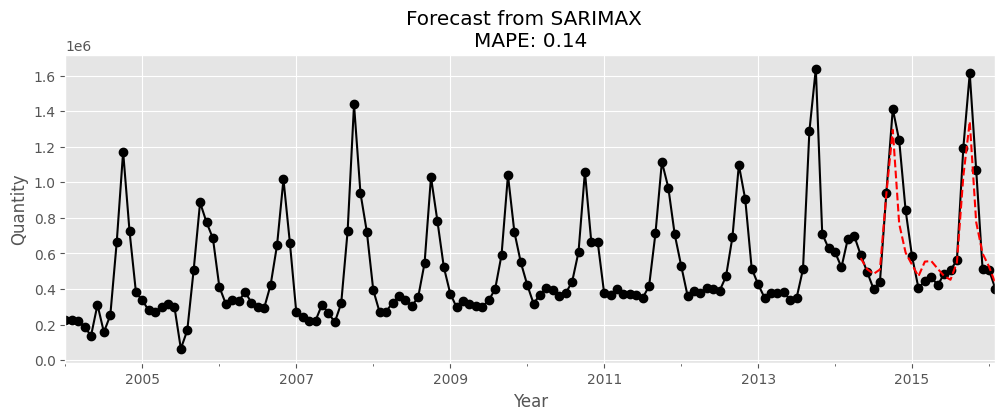

In [ ]:
# SARIMAX
from sklearn.metrics import mean_absolute_percentage_error
import statsmodels.api as sm
df = pd.read_csv("https://raw.githubusercontent.com/aiedu-courses/stepik_applied_tasks/main/datasets/market_arrivals_ind.csv")
df['date'] = pd.DatetimeIndex(df['date'])  #.to_period('M')
df = df.sort_values('date')
df.index = pd.PeriodIndex(df['date'], freq = 'M')
ts = df.loc[df.city == "BANGALORE"][['quantity', 'priceMod']].copy()

cut_ind = int(ts.shape[0] * 0.85)
train = ts.iloc[:cut_ind]
test = ts.iloc[cut_ind:]

sarimax_model = sm.tsa.SARIMAX(train['quantity'], exog=train[['priceMod']],  seasonal_order=(1, 1, 1, 12)).fit()
forecast = sarimax_model.get_forecast(steps=22, exog=test[['priceMod']])
predicted_mean = forecast.predicted_mean
print('MAPE (SARIMAX):', round(mean_absolute_percentage_error(test['quantity'], predicted_mean), 2))

ax = ts['quantity'].plot(figsize=(12, 4), marker="o", color="black", title=f"Forecast from SARIMAX  \nMAPE: {round(mean_absolute_percentage_error(test['quantity'], predicted_mean), 2)}",)
ax.set_ylabel("Quantity")
ax.set_xlabel("Year")
predicted_mean.plot(ax=ax, style="--", color="red")
plt.show()

#### Tsfresh  
Tsfresh (Time Series Feature extraction based on Scalable Hypothesis tests) - библиотека автоматичсекого извлечения признаков из временных рядов, удобный инструмент для работы с большим объемом данных. Tsfresh предлагает широкий набор статистических и информационных признаков, он может обрабатывать временные ряды с различными интервалами и неполные временные ряды.    

Некоторые методы, используемые в TSFRESH:   
- Предварительная обработка: фреймворк предварительно обрабатывает временные ряды, учитывает пропуски и делает интервалы однородными.   
- Агрегирование и сегментация: ts могут быть сегментированы на подинтервалы и агрегированы с различными функциями (mean, sum, min, max и тд).   
- Извлечение признаков: фреймворк умеет вычислять множество различных статистических и информационных признаков, таких как корреляция, энтропия, среднее значение, перцентиль и др.   
- Отбор признаков: фреймворк содержит методы для автоматического отбора наиболее информативных признаков с помощью статистических тестов и ML.    
- Многопоточность: фреймворк использует многопоточность для параллельного вычисления признаков, что повышает его производительность.

- **MinimalFCParameters** - базовый набор признаков, который представляет собой основные статистики, описывающие распределение значений: сумма, медиана, среднее, длина, стандартное отклонение, дисперсия, макс. и мин. значения каждого ряда.     
- **TimeBasedFCParameters** - подсчитывает линейный тренд, значение коэффициента R^2, intercept, slope, стандартную ошибку и p-value. Можно скомбинировать два словаря (Minimal и TimeBased) и получить достаточно рабочий набор признаков, который быстро посчитается.
- **EfficientFCParameters** и **ComprehensiveFCParameters** - наиболее информативные и эффективные наборы признаков. Однако, их подсчет на больших датасетах занимает значительное количество времени. 

In [1]:
from tsfresh.feature_selection.relevance import calculate_relevance_table
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import settings

In [6]:
print(dict(settings.MinimalFCParameters()).keys())
print(settings.TimeBasedFCParameters().keys())

dict_keys(['sum_values', 'median', 'mean', 'length', 'standard_deviation', 'variance', 'root_mean_square', 'maximum', 'absolute_maximum', 'minimum'])
KeysView({'linear_trend_timewise': [{'attr': 'pvalue'}, {'attr': 'rvalue'}, {'attr': 'intercept'}, {'attr': 'slope'}, {'attr': 'stderr'}]})


In [7]:
print(dict(settings.EfficientFCParameters()).keys())

dict_keys(['variance_larger_than_standard_deviation', 'has_duplicate_max', 'has_duplicate_min', 'has_duplicate', 'sum_values', 'abs_energy', 'mean_abs_change', 'mean_change', 'mean_second_derivative_central', 'median', 'mean', 'length', 'standard_deviation', 'variation_coefficient', 'variance', 'skewness', 'kurtosis', 'root_mean_square', 'absolute_sum_of_changes', 'longest_strike_below_mean', 'longest_strike_above_mean', 'count_above_mean', 'count_below_mean', 'last_location_of_maximum', 'first_location_of_maximum', 'last_location_of_minimum', 'first_location_of_minimum', 'percentage_of_reoccurring_values_to_all_values', 'percentage_of_reoccurring_datapoints_to_all_datapoints', 'sum_of_reoccurring_values', 'sum_of_reoccurring_data_points', 'ratio_value_number_to_time_series_length', 'maximum', 'absolute_maximum', 'minimum', 'benford_correlation', 'time_reversal_asymmetry_statistic', 'c3', 'cid_ce', 'symmetry_looking', 'large_standard_deviation', 'quantile', 'autocorrelation', 'agg_auto

In [8]:
print(dict(settings.ComprehensiveFCParameters()).keys())

dict_keys(['variance_larger_than_standard_deviation', 'has_duplicate_max', 'has_duplicate_min', 'has_duplicate', 'sum_values', 'abs_energy', 'mean_abs_change', 'mean_change', 'mean_second_derivative_central', 'median', 'mean', 'length', 'standard_deviation', 'variation_coefficient', 'variance', 'skewness', 'kurtosis', 'root_mean_square', 'absolute_sum_of_changes', 'longest_strike_below_mean', 'longest_strike_above_mean', 'count_above_mean', 'count_below_mean', 'last_location_of_maximum', 'first_location_of_maximum', 'last_location_of_minimum', 'first_location_of_minimum', 'percentage_of_reoccurring_values_to_all_values', 'percentage_of_reoccurring_datapoints_to_all_datapoints', 'sum_of_reoccurring_values', 'sum_of_reoccurring_data_points', 'ratio_value_number_to_time_series_length', 'sample_entropy', 'maximum', 'absolute_maximum', 'minimum', 'benford_correlation', 'time_reversal_asymmetry_statistic', 'c3', 'cid_ce', 'symmetry_looking', 'large_standard_deviation', 'quantile', 'autocorre

In [5]:
# Tsfresh для генерации признаков на датасете с информацией о среднесуточной температуре в г.Дели, target - meantemp 
df = pd.read_csv('https://raw.githubusercontent.com/aiedu-courses/stepik_applied_tasks/main/datasets/DailyDelhiClimateTrain.csv')
df['date'] =  pd.to_datetime(df['date'])
print(df.shape)  
display(df.date.agg(['min', 'max']))
df.head(3)

(1461, 5)


min   2013-01-01
max   2016-12-31
Name: date, dtype: datetime64[ns]

date   meantemp  humidity  wind_speed  meanpressure
0 2013-01-01  10.000000      84.5    0.000000   1015.666667
1 2013-01-02   7.400000      92.0    2.980000   1017.800000
2 2013-01-03   7.166667      87.0    4.633333   1018.666667

In [9]:
df['id'] = range(len(df))
df_long = df.melt(id_vars=['id', 'date'], value_name='value', var_name='variable')  # Преобразуем датасет в "длинный" формат
df_long = df_long[df_long['variable'] != 'meantemp']                                # Исключаем target 'meantemp'
df_long

id       date      variable        value
1461     0 2013-01-01      humidity    84.500000
1462     1 2013-01-02      humidity    92.000000
1463     2 2013-01-03      humidity    87.000000
1464     3 2013-01-04      humidity    71.333333
1465     4 2013-01-05      humidity    86.833333
...    ...        ...           ...          ...
5839  1456 2016-12-27  meanpressure  1017.200000
5840  1457 2016-12-28  meanpressure  1015.565217
5841  1458 2016-12-29  meanpressure  1016.904762
5842  1459 2016-12-30  meanpressure  1017.904762
5843  1460 2016-12-31  meanpressure  1016.100000

[4383 rows x 4 columns]

In [446]:
# Извлечение признаков
features = extract_features(df_long,
                            column_id='id', 
                            column_sort='date',
                            column_value='value', 
                            column_kind='variable',
                            default_fc_parameters=settings.EfficientFCParameters(),       
                            impute_function=impute,  # Функция для заполнения пропусков
                            n_jobs=5)   

Feature Extraction: 100%|██████████| 25/25 [01:17<00:00,  3.09s/it]


In [451]:
print(type(features))
print(features.shape)

<class 'pandas.core.frame.DataFrame'>
(1461, 2331)


In [464]:
y = df.set_index('id')['meantemp']

# Отбор признаков
selected_features = select_features(features, y)   
print(selected_features.shape)   
selected_features

(1461, 69)


meanpressure__quantile__q_0.8  meanpressure__median  meanpressure__mean  \
id                                                                              
0                       1015.666667           1015.666667         1015.666667   
1                       1017.800000           1017.800000         1017.800000   
2                       1018.666667           1018.666667         1018.666667   
3                       1017.166667           1017.166667         1017.166667   
4                       1016.500000           1016.500000         1016.500000   
...                             ...                   ...                 ...   
1456                    1017.200000           1017.200000         1017.200000   
1457                    1015.565217           1015.565217         1015.565217   
1458                    1016.904762           1016.904762         1016.904762   
1459                    1017.904762           1017.904762         1017.904762   
1460                    1016.100000           1016.100000         1016.100000   

      meanpressure__root_mean_square  meanpressure__maximum  \
id                                                            
0                        1015.666667            1015.666667   
1                        1017.800000            1017.800000   
2                        1018.666667            1018.666667   
3                        1017.166667            1017.166667   
4                        1016.500000            1016.500000   
...                              ...                    ...   
1456                     1017.200000            1017.200000   
1457                     1015.565217            1015.565217   
1458                     1016.904762            1016.904762   
1459                     1017.904762            1017.904762   
1460                     1016.100000            1016.100000   

      meanpressure__absolute_maximum  meanpressure__minimum  \
id                                                            
0                        1015.666667            1015.666667   
1                        1017.800000            1017.800000   
2                        1018.666667            1018.666667   
3                        1017.166667            1017.166667   
4                        1016.500000            1016.500000   
...                              ...                    ...   
1456                     1017.200000            1017.200000   
1457                     1015.565217            1015.565217   
1458                     1016.904762            1016.904762   
1459                     1017.904762            1017.904762   
1460                     1016.100000            1016.100000   

      meanpressure__quantile__q_0.1  meanpressure__quantile__q_0.2  \
id                                                                   
0                       1015.666667                    1015.666667   
1                       1017.800000                    1017.800000   
2                       1018.666667                    1018.666667   
3                       1017.166667                    1017.166667   
4                       1016.500000                    1016.500000   
...                             ...                            ...   
1456                    1017.200000                    1017.200000   
1457                    1015.565217                    1015.565217   
1458                    1016.904762                    1016.904762   
1459                    1017.904762                    1017.904762   
1460                    1016.100000                    1016.100000   

      meanpressure__quantile__q_0.3  meanpressure__quantile__q_0.4  \
id                                                                   
0                       1015.666667                    1015.666667   
1                       1017.800000                    1017.800000   
2                       1018.666667                    1018.666667   
3                       1017.166667                

In [465]:
# extract_relevant_features - генерация наиболее информативных признаков с заполнением пропусков (impute)
features_filtered_direct = extract_relevant_features(df.drop('meantemp', axis=1), y, 
                                                     column_id='id', column_sort='date', n_jobs=10)

Feature Extraction: 100%|██████████| 50/50 [01:35<00:00,  1.92s/it]


In [467]:
print(features_filtered_direct.shape)  # (1461, 69)
features_filtered_direct[:3]

(1461, 69)


meanpressure__fft_coefficient__attr_"abs"__coeff_0  \
0                                        1015.666667    
1                                        1017.800000    
2                                        1018.666667    

   meanpressure__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                         196.978172                      
1                                         197.391910                      
2                                         197.559991                      

   meanpressure__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                         278.569202                      
1                                         279.154316                      
2                                         279.392019                      

   meanpressure__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)  \
0                                         393.956343                     
1                                         394.783820                     
2                                         395.119982                     

   meanpressure__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)  \
0                                         622.899671                     
1                                         624.208027                     
2                                         624.739546                     

   meanpressure__quantile__q_0.9  meanpressure__quantile__q_0.8  \
0                    1015.666667                    1015.666667   
1                    1017.800000                    1017.800000   
2                    1018.666667                    1018.666667   

   meanpressure__quantile__q_0.7  meanpressure__quantile__q_0.6  \
0                    1015.666667                    1015.666667   
1                    1017.800000                    1017.800000   
2                    1018.666667                    1018.666667   

   meanpressure__fft_coefficient__attr_"real"__coeff_0  \
0                                        1015.666667     
1                                        1017.800000     
2                                        1018.666667     

   meanpressure__quantile__q_0.4  meanpressure__quantile__q_0.2  \
0                    1015.666667                    1015.666667   
1                    1017.800000                    1017.800000   
2                    1018.666667                    1018.666667   

   meanpressure__quantile__q_0.1  meanpressure__minimum  \
0                    1015.666667            1015.666667   
1                    1017.800000            1017.800000   
2                    1018.666667            1018.666667   

   meanpressure__absolute_maximum  meanpressure__maximum  \
0                     1015.666667            1015.666667   
1                     1017.800000            1017.800000   
2                     1018.666667            1018.666667   

   meanpressure__root_mean_square  meanpressure__mean  meanpressure__median  \
0                     1015.666667         1015.666667           1015.666667   
1                     1017.800000         1017.800000           1017.800000   
2                     1018.666667         1018.666667           1018.666667   

   meanpressure__quantile__q_0.3  meanpressure__sum_values  \
0                    1015.666667               1015.666667   
1                    1017.800000               1017.800000   
2                    1018.666667               1018.666667   

   meanpressure__abs_energy  humidity__fft_coefficient__attr_"abs"__coeff_0  \
0            1031578.777778                                       84.500000   
1            1035916.840000                                       92.000000   
2            1037681.777778                                       87.000000   

   humidity__abs_energy  humidity__median  humidity__mean  \
0           7140.250000         84.500000       84.500000   
1           8464.000000         92.000000       92.0000

In [472]:
calculate_relevance_table(features, y)[:10]

feature  type  p_value  \
feature                                                                         
meanpressure__quantile__q_0.8    meanpressure__quantile__q_0.8  real 0.000000   
meanpressure__median                      meanpressure__median  real 0.000000   
meanpressure__mean                          meanpressure__mean  real 0.000000   
meanpressure__root_mean_square  meanpressure__root_mean_square  real 0.000000   
meanpressure__maximum                    meanpressure__maximum  real 0.000000   
meanpressure__absolute_maximum  meanpressure__absolute_maximum  real 0.000000   
meanpressure__minimum                    meanpressure__minimum  real 0.000000   
meanpressure__quantile__q_0.1    meanpressure__quantile__q_0.1  real 0.000000   
meanpressure__quantile__q_0.2    meanpressure__quantile__q_0.2  real 0.000000   
meanpressure__quantile__q_0.3    meanpressure__quantile__q_0.3  real 0.000000   

                                relevant  
feature                                   
meanpressure__quantile__q_0.8       True  
meanpressure__median                True  
meanpressure__mean                  True  
meanpressure__root_mean_square      True  
meanpressure__maximum               True  
meanpressure__absolute_maximum      True  
meanpressure__minimum               True  
meanpressure__quantile__q_0.1       True  
meanpressure__quantile__q_0.2       True  
meanpressure__quantile__q_0.3       True

### FeatureTools  
Фреймворк позволяет автоматически генерировать новые признаки различной природы на основе существующих. Он использует концепцию *EntitySet*, что позволяет организовать и структурировать данные из нескольких источников. EntitySet может содержать несколько таблиц (или сущностей), которые могут быть связаны между собой. Это очень полезно, если имеется несколько таблиц с временными метками. *Deep Feature Synthesis (DFS)* - основная функция библиотеки, которая выполняет полное извлечение признаков по заданной сущности. DFS автоматически создает новые признаки, комбинируя и агрегируя существующие данные.
Фреймворк значительно упрощает процесс извлечения признаков для временных рядов, что может повысить производительность моделей машинного обучения. 

In [648]:
# FeatureTools для генерации признаков на датасете с информацией о среднесуточной температуре в г.Дели, target - meantemp 
import featuretools as ft
df = pd.read_csv('https://raw.githubusercontent.com/aiedu-courses/stepik_applied_tasks/main/datasets/DailyDelhiClimateTrain.csv')
df['date'] =  pd.to_datetime(df['date'])
df['id'] = df.index
print(df.shape)  # (1461, 5)
display(df.date.agg(['min', 'max']))
df.head(3)

(1461, 6)


min   2013-01-01
max   2016-12-31
Name: date, dtype: datetime64[ns]

date  meantemp  humidity  wind_speed  meanpressure  id
0 2013-01-01 10.000000 84.500000    0.000000   1015.666667   0
1 2013-01-02  7.400000 92.000000    2.980000   1017.800000   1
2 2013-01-03  7.166667 87.000000    4.633333   1018.666667   2

In [649]:
# Возможные варианты примитивов
ft.primitives.list_primitives()

name         type  dask_compatible  spark_compatible  \
0             percent_unique  aggregation            False             False   
1    n_most_common_frequency  aggregation            False             False   
2      max_consecutive_zeros  aggregation            False             False   
3                      count  aggregation             True              True   
4       count_inside_nth_std  aggregation            False             False   
..                       ...          ...              ...               ...   
198        natural_logarithm    transform             True              True   
199            expanding_std    transform            False             False   
200        punctuation_count    transform            False             False   
201       less_than_equal_to    transform             True              True   
202           percent_change    transform            False             False   

                                           description  \
0             Determines the percent of unique values.   
1    Determines the frequency of the n most common ...   
2    Determines the maximum number of consecutive z...   
3    Determines the total number of values, excludi...   
4    Determines the count of observations that lie ...   
..                                                 ...   
198        Computes the natural logarithm of a number.   
199  Computes the expanding standard deviation for ...   
200  Determines number of punctuation characters in...   
201  Determines if values in one list are less than...   
202  Determines the percent difference between valu...   

                                          valid_inputs  \
0        <ColumnSchema (Semantic Tags = ['category'])>   
1        <ColumnSchema (Semantic Tags = ['category'])>   
2    <ColumnSchema (Logical Type = Integer)>, <Colu...   
3           <ColumnSchema (Semantic Tags = ['index'])>   
4         <ColumnSchema (Semantic Tags = ['numeric'])>   
..                                                 ...   
198       <ColumnSchema (Semantic Tags = ['numeric'])>   
199  <ColumnSchema (Semantic Tags = ['numeric'])>, ...   
200    <ColumnSchema (Logical Type = NaturalLanguage)>   
201  <ColumnSchema (Semantic Tags = ['numeric'])>, ...   
202       <ColumnSchema (Semantic Tags = ['numeric'])>   

                                           return_type  
0    <ColumnSchema (Logical Type = Double) (Semanti...  
1    <ColumnSchema (Logical Type = Categorical) (Se...  
2    <ColumnSchema (Logical Type = Integer) (Semant...  
3    <ColumnSchema (Logical Type = IntegerNullable)...  
4    <ColumnSchema (Logical Type = Integer) (Semant...  
..                                                 ...  
198  <ColumnSchema (Logical Type = Double) (Semanti...  
199  <ColumnSchema (Logical Type = Double) (Semanti...  
200  <ColumnSchema (Logical Type = IntegerNullable)...  
201    <ColumnSchema (Logical Type = BooleanNullable)>  
202  <ColumnSchema (Logical Type = Double) (Semanti...  

[203 rows x 7 columns]

In [650]:
entity_set = ft.EntitySet(id = 'daily_meantempt')                                      # Создаем объект класса EntitySet
entity_set = entity_set.add_dataframe(dataframe_name = 'main_df',                      # Добавляем в entity_set основной датафрейм 
                                      dataframe = df.drop('meantemp', axis=1).copy(),  # logical_types = {"action": Categorical}
                                      time_index = 'date', index = 'id')
print(entity_set)

Entityset: daily_meantempt
  DataFrames:
    main_df [Rows: 1461, Columns: 5]
  Relationships:
    No relationships


In [651]:
# # Объявим отношения между сущностями
# relationships = ft.Relationship(entityset = entity_set,
#                                 parent_dataframe_name = 'train_df',
#                                 parent_column_name = 'user_id',
#                                 child_dataframe_name = 'events_data',
#                                 child_column_name = 'user_id')

# # Добавляем отношения
# entity_set = entity_set.add_relationship(relationship = relationships)
# print(entity_set)

In [652]:
# agg_primitives_list = ['num_unique', 'count', 'percent_true', 'avg_time_between', 'time_since_first',
#                        'time_since_last', 'trend', 'last', 'mean', 'min', 'max', 'std', 'mode', 'skew',
#                        'median',  'sum']
# where_primitives_list = ['percent_true', "avg_time_between", 'time_since_first', 'time_since_last',
#                          'percent_true', 'trend']

In [654]:
trans_primitives_list = ['hour', 'weekday', 'month', 'is_weekend',  'time_since', "time_since_previous"]
feature_matrix, features = ft.dfs(entityset = entity_set,
                                    target_dataframe_name = 'main_df', max_depth = 3, verbose = True, features_only = False,
                                    trans_primitives = trans_primitives_list,
                                    # agg_primitives = agg_primitives_list,
                                    # where_primitives = where_primitives_list,
                                    # relationships = relationships,
                                )  

Built 9 features
Elapsed: 00:00 | Progress: 100%|██████████


In [655]:
feature_matrix.dropna(axis = 1, thresh = 0.3, inplace=True)
feature_matrix.fillna(0, inplace=True)
print(feature_matrix.shape)
feature_matrix.head(3)

(1461, 9)


humidity  wind_speed  meanpressure HOUR(date)  IS_WEEKEND(date)  \
id                                                                    
0  84.500000    0.000000   1015.666667          0             False   
1  92.000000    2.980000   1017.800000          0             False   
2  87.000000    4.633333   1018.666667          0             False   

   MONTH(date)  TIME_SINCE(date)  TIME_SINCE_PREVIOUS(date) WEEKDAY(date)  
id                                                                         
0            1  389126214.183847                   0.000000             1  
1            1  389039814.183847               86400.000000             2  
2            1  388953414.183847               86400.000000             3

In [656]:
# Оценим значимость признаков при помощи f_classif - опирается на однофакторный дисперсионный анализ ANOVA  
# Основу процедуры составляет обобщение результатов двух выборочных t-тестов для независимых выборок (2-sample t)
importance = pd.Series(f_classif(feature_matrix[feature_matrix.columns.tolist()], df['meantemp'])[0], index = cols_list).sort_values(ascending = False)
importance_df = importance.reset_index().rename(columns = {'index' : 'features', 0 : 'importance'}).dropna()
print(importance_df.shape)
display(importance_df)

(8, 2)


features  importance
0               meanpressure  212.975424
1                   humidity    2.727695
2           TIME_SINCE(date)    2.445945
3                MONTH(date)    1.558652
4  TIME_SINCE_PREVIOUS(date)    1.368254
5                 wind_speed    1.168706
6           IS_WEEKEND(date)    0.936791
7              WEEKDAY(date)    0.918471

### **SkTime**     
Библиотека прогнозирования временных рядов, разработанная при поддержке Британского Совета по экономическим и социальным исследованиям, центра Consumer Data Research и Института Алана Тьюринга. В SkTime реализовано множество алгоритмов, среди которых:  
- ARIMA, SARIMA, AutoARIMA
- Exponential Smoothing   
- Theta method, AutoETS    
- K-Nearest Neighbors и др.

### **Prophet**   
Библиотека прогнозирования временных рядов, разработанная компанией Facebook. Prophet использует аддитивную модель для прогнозирования, которая предполагает, что значение временного ряда можно разложить на несколько компонент: тренд, сезонность, праздничные эффекты и остатки $y_t$ = $g_t$ + $s_t$ + $h_t$ + $e_t$.  
- $g_t$- тренд, моделирующий нелинейное изменение значения временного ряда во времени,  
- $s_t$ - сезонность, учитывающая повторяющиеся паттерны или циклы во временном ряду,   
- $h_t$ - праздничные эффекты, учитывающие влияние праздников и событий на временной ряд,   
- $e_t$ - остатки, которые, как предполагается, нормально распределены (шум).    

Тренд моделируется с использованием гибкой линейной модели, которая может аппроксимировать нелинейные изменения во временном ряду. Сезонность моделируется с помощью фурье-рядов, позволяющих учесть сезонные колебания с различными периодами. Праздничные эффекты - путем добавления индикаторов праздников в модель. Prophet автоматически настраивает гиперпараметры модели (гибкость тренда и сезонности, влияние праздников). Фреймворк также предоставляет возможность пользователю самостоятельно настраивать некоторые параметры.